# Task B: CNN

## 0. Load the preprocessed data
**We will use the preprocessed dataset after PCA. It characterizes 2 different classes (tumor or not) based on 200 features.** 

In [1]:
# Import necessary libraries
import pickle
import numpy as np
import pandas as pd

In [2]:
# Load preprocessed data with help of pickle.
with open('DataAfterProcess/label_AfterProcess.pickle', 'rb') as handle:
    label_TaskB = pickle.load(handle)
    
# Check result.
print(label_TaskB.shape) 

(3000,)


### Train Test Split

**Split data into a training set (90%) and a test set (10%). Note that the test set here comes from the dataset.zip file, not the test.zip file.**

In [3]:
# Import necessary libraries
import cv2
from glob import glob

In [4]:
images = [cv2.imread(image) 
          for image in glob('dataset/image/*.jpg')]

resize = 256
images_resized = [cv2.resize(images[i], (resize,resize))
                  for i in range(0, len(images))]

images_TaskB = np.array(images_resized)/255
print(images_TaskB.shape)

(3000, 256, 256, 3)


In [5]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [12]:
# Implement one-hot encoding to labels.
X = images_TaskB
y = to_categorical(label_TaskB)

print(X.shape)

# # Split data into a training set and a test set (90% training and 10% testing data).
# # Notice that all random state is chosen as 0 in this assignment to ensure reproducibility.
# X_train, X_test, y_train, y_test = train_test_split(X,y, 
#                                                     test_size=0.1, random_state=5)

# # Split training set into a new training set and a validation set (90% training and 10% validation data).
# X_train_new, X_val, y_train_new, y_val = train_test_split(X_train,y_train, 
#                                                     test_size=0.1, random_state=5)

# # Check result.
# print(X_train_new.shape, y_train_new.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape) 
# print('train set: {} | val set: {} | test set: {}'.format(round(len(y_train_new)/len(X),3), 
#                                                           round(len(y_val)/len(X),3),
#                                                           round(len(y_test)/len(X),3)))

(3000, 256, 256, 3)


## 1. Hyperparameter tuning: Trial and error
**In this part, we try to train a neural network and tune the hyperparameter by trial and error, which means we change the hyperparameter of model by checking training and validation loss**

In [13]:
# Import necessary libraries
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import optimizers, losses, metrics

import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# This function is used to plot traing loss and validation loss.
def plot_loss(training_history):    
    # Set new figure.
    plt.figure(figsize=(8,6))
    plt.grid()    
    
    # Read loss information wrt.loss from input.      
    history_dict = training_history.history

    tra_loss, val_loss = history_dict['loss'], history_dict['val_loss']
    epochs = range(1,len(tra_loss)+1)

    # Plot trainging loss and validation loss.
    plt.plot(epochs,tra_loss, 'bo', label='Training loss') 
    plt.plot(epochs,val_loss, 'b', label='Validation loss')

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

# ResNet

In [97]:
from tensorflow.keras.applications import ResNet50

height, width = X_train_new.shape[1], X_train_new.shape[2]
channels = X_train_new.shape[-1]

base_model_ResNet = ResNet50(weights='imagenet', 
                             include_top=False,  
                             input_shape=(height, width, channels))

base_model_ResNet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [88]:
train_feature_Res = base_model_ResNet.predict(X_train_new)
print(train_feature_Res.shape)

val_feature_Res = base_model_ResNet.predict(X_val)
print(val_feature_Res.shape)

test_feature_Res = base_model_ResNet.predict(X_test)
print(test_feature_Res.shape)

(2430, 4, 4, 2048)
(270, 4, 4, 2048)
(300, 4, 4, 2048)


In [89]:
X_train_Res_256 = train_feature_Res.reshape(2430, 
                                            train_feature_Res.shape[1]*train_feature_Res.shape[1]*train_feature_Res.shape[3])
X_val_Res_256 = val_feature_Res.reshape(270, 
                                        train_feature_Res.shape[1]*train_feature_Res.shape[1]*train_feature_Res.shape[3])
X_test_Res_256 = test_feature_Res.reshape(300,
                                          train_feature_Res.shape[1]*train_feature_Res.shape[1]*train_feature_Res.shape[3])


with open('DataAfterProcess/X_train_Res_256.pickle', 'wb') as handle:
    pickle.dump(X_train_Res_256, handle)
    
with open('DataAfterProcess/X_val_Res_256.pickle', 'wb') as handle:
    pickle.dump(X_val_Res_256, handle)
    
with open('DataAfterProcess/X_test_Res_256.pickle', 'wb') as handle:
    pickle.dump(X_test_Res_256, handle)

In [90]:
input_dim_Res = train_feature_Res.shape[1]*train_feature_Res.shape[1]*train_feature_Res.shape[3]

units_Res = 64

drop_Res = 0.2
C_Res = 0

epochs_Res = 100
batch_size_Res = 100


model_Res = models.Sequential()

model_Res.add(layers.Dense(units_Res, activation='relu', kernel_regularizer=regularizers.l2(C_Res), input_dim=input_dim_Res))
model_Res.add(layers.Dropout(drop_Res))
model_Res.add(layers.Dense(units_Res, activation='relu', kernel_regularizer=regularizers.l2(C_Res), input_dim=input_dim_Res))
model_Res.add(layers.Dropout(drop_Res))
model_Res.add(layers.Dense(units_Res, activation='relu', kernel_regularizer=regularizers.l2(C_Res), input_dim=input_dim_Res))
model_Res.add(layers.Dropout(drop_Res))
model_Res.add(layers.Dense(units_Res, activation='relu', kernel_regularizer=regularizers.l2(C_Res), input_dim=input_dim_Res))
model_Res.add(layers.Dropout(drop_Res))

model_Res.add(layers.Dense(4, activation='softmax'))

model_Res.compile(optimizer=optimizers.Adam(),
                  loss=losses.CategoricalCrossentropy(),
                  metrics=[metrics.CategoricalAccuracy()])

his_Res = model_Res.fit(X_train_Res_128,
                        y_train_new,
                        epochs=epochs_Res,
                        batch_size=batch_size_Res,
                        validation_data=(X_val_Res_128,y_val))

Train on 2430 samples, validate on 270 samples
Epoch 1/100
2430/2430 [==============================] - 1s 479us/sample - loss: 1.3694 - categorical_accuracy: 0.3136 - val_loss: 1.3108 - val_categorical_accuracy: 0.3259
Epoch 2/100
2430/2430 [==============================] - 1s 253us/sample - loss: 1.3129 - categorical_accuracy: 0.3568 - val_loss: 1.2306 - val_categorical_accuracy: 0.4185
Epoch 3/100
2430/2430 [==============================] - 1s 254us/sample - loss: 1.2326 - categorical_accuracy: 0.4152 - val_loss: 1.0691 - val_categorical_accuracy: 0.5259
Epoch 4/100
2430/2430 [==============================] - 1s 253us/sample - loss: 1.1431 - categorical_accuracy: 0.4658 - val_loss: 0.9684 - val_categorical_accuracy: 0.5741
Epoch 5/100
2430/2430 [==============================] - 1s 247us/sample - loss: 1.0858 - categorical_accuracy: 0.4901 - val_loss: 0.8727 - val_categorical_accuracy: 0.6259
Epoch 6/100
2430/2430 [==============================] - 1s 265us/sample - loss: 1.0002 

Epoch 48/100
2430/2430 [==============================] - 1s 300us/sample - loss: 0.8045 - categorical_accuracy: 0.6305 - val_loss: 0.6576 - val_categorical_accuracy: 0.6889
Epoch 49/100
2430/2430 [==============================] - 1s 310us/sample - loss: 0.8070 - categorical_accuracy: 0.6309 - val_loss: 0.6108 - val_categorical_accuracy: 0.7519
Epoch 50/100
2430/2430 [==============================] - 1s 298us/sample - loss: 0.7648 - categorical_accuracy: 0.6453 - val_loss: 0.6098 - val_categorical_accuracy: 0.7333
Epoch 51/100
2430/2430 [==============================] - 1s 310us/sample - loss: 0.7994 - categorical_accuracy: 0.6247 - val_loss: 0.6567 - val_categorical_accuracy: 0.6889
Epoch 52/100
2430/2430 [==============================] - 1s 312us/sample - loss: 0.7952 - categorical_accuracy: 0.6461 - val_loss: 0.6892 - val_categorical_accuracy: 0.7111
Epoch 53/100
2430/2430 [==============================] - 1s 304us/sample - loss: 0.8444 - categorical_accuracy: 0.6103 - val_loss

300/300 [==============================] - 0s 229us/sample - loss: 0.6890 - categorical_accuracy: 0.7167


[0.6889801494280497, 0.71666664]

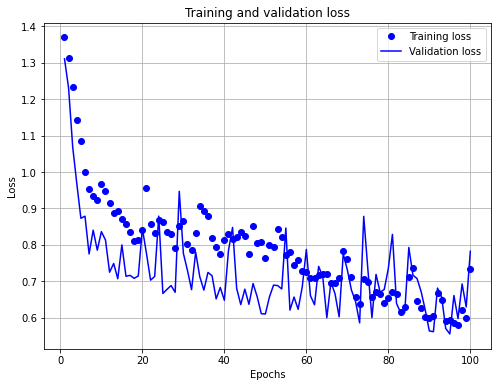

In [92]:
# Plot traing loss and validation loss
plot_loss(his_Res)

model_Res.evaluate(X_val_Res_128, y_val)
model_Res.evaluate(X_test_Res_128, y_test)

# VGG16

In [15]:
from tensorflow.keras.applications import vgg16

height, width, channel = X.shape[1], X.shape[2], X.shape[-1]

path_VGG16_weights='Model/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

base_model = vgg16.VGG16(weights = path_VGG16_weights,
                         include_top = False, 
                         input_shape = (height, width, channel))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [16]:
# train_feature = base_model.predict(X_train_new)
# print(train_feature.shape)

# val_feature = base_model.predict(X_val)
# print(val_feature.shape)

# test_feature = base_model.predict(X_test)
# print(test_feature.shape)

X_VGG =  base_model.predict(X)
print(X_VGG.shape)

(3000, 8, 8, 512)


In [18]:
X_VGG_256 = X_VGG.reshape(3000, 
                          X_VGG.shape[1]*X_VGG.shape[1]*X_VGG.shape[3])

In [21]:
with open('DataAfterProcess/X_VGG_256.pickle', 'wb') as handle:
    pickle.dump(X_VGG_256, handle)  
    
with open('DataAfterProcess/y.pickle', 'wb') as handle:
    pickle.dump(y, handle)


In [18]:
drop = 0
units = 256
epochs = 50
batch_size = 1000
C = 0

model = models.Sequential()
model.add(layers.Dense(units, activation='relu', kernel_regularizer=regularizers.l2(C), input_dim=512*64))
model.add(layers.Dropout(drop))
# model.add(layers.Dense(units, activation='relu', kernel_regularizer=regularizers.l2(C),))
# model.add(layers.Dropout(drop))
# model.add(layers.Dense(units, activation='relu', kernel_regularizer=regularizers.l2(C),))
# model.add(layers.Dropout(drop))
# model.add(layers.Dense(units, activation='relu', kernel_regularizer=regularizers.l2(C),))
# model.add(layers.Dropout(drop))
# model.add(layers.Dense(units, activation='relu', kernel_regularizer=regularizers.l2(C),))
# model.add(layers.Dropout(drop))
# model.add(layers.Dense(units, activation='relu', kernel_regularizer=regularizers.l2(C),))
# model.add(layers.Dropout(drop))
model.add(layers.Dense(4, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(),
              loss=losses.CategoricalCrossentropy(),
              metrics=[metrics.CategoricalAccuracy()])

his = model.fit(X_train_VGG_256,
                y_train_new,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_val_VGG_256,y_val))

Train on 2430 samples, validate on 270 samples
Epoch 1/50
2430/2430 [==============================] - 1s 464us/sample - loss: 26.0301 - categorical_accuracy: 0.2938 - val_loss: 51.3481 - val_categorical_accuracy: 0.1296
Epoch 2/50
2430/2430 [==============================] - 1s 261us/sample - loss: 27.3319 - categorical_accuracy: 0.2506 - val_loss: 2.6098 - val_categorical_accuracy: 0.5481
Epoch 3/50
2430/2430 [==============================] - 1s 291us/sample - loss: 5.1501 - categorical_accuracy: 0.3897 - val_loss: 8.3661 - val_categorical_accuracy: 0.3111
Epoch 4/50
2430/2430 [==============================] - 1s 288us/sample - loss: 6.5770 - categorical_accuracy: 0.3337 - val_loss: 1.4946 - val_categorical_accuracy: 0.5852
Epoch 5/50
2430/2430 [==============================] - 1s 274us/sample - loss: 2.0914 - categorical_accuracy: 0.5630 - val_loss: 4.9249 - val_categorical_accuracy: 0.6074
Epoch 6/50
2430/2430 [==============================] - 1s 261us/sample - loss: 2.8466 - c

300/300 [==============================] - 0s 286us/sample - loss: 0.5569 - categorical_accuracy: 0.8167


[0.5568637903531393, 0.81666666]

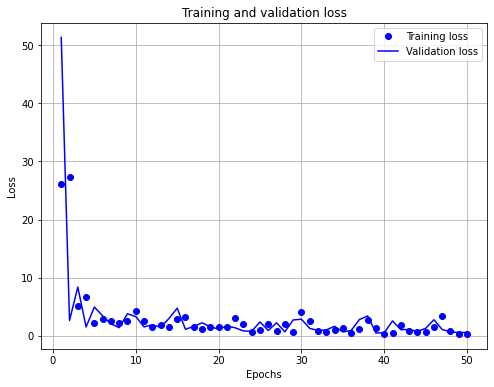

In [19]:
# Plot traing loss and validation loss
plot_loss(his)

model.evaluate(X_val_VGG_256, y_val)
model.evaluate(X_test_VGG_256, y_test)

### Formulate initial neural network

**Build a neural network with 3 layers: input layer, hidden layer and output layer.**
- Dense hidden layer with 16 units and relu as activation function;
- Epochs and batch size are chosen as 100 and 128;

In [8]:
# Defeine layer variable
hidden_units_1 = 16
drop = 0.5
C = 0


# Define training variable
epochs = 100
batch_size = 64

# Create the model.
model_vanilla = models.Sequential()

model_vanilla.add(layers.Convolution2D(filters=16,5,5, padding='same',strides=(2, input_shape=(resize,resize,1)))
model_vanilla.add(layers.Activation('relu'))
model_vanilla.add(layers.MaxPool2D((2,2), strides=2, padding='same'))
model_vanilla.add(layers.Dropout(drop))

model_vanilla.add(layers.Convolution2D(64,16,16, padding='same'))
model_vanilla.add(layers.Activation('relu'))
model_vanilla.add(layers.MaxPool2D((2,2), strides=2, padding='same'))
model_vanilla.add(layers.Dropout(drop))

# model_vanilla.add(layers.Convolution2D(32,3,3, padding='same'))
# model_vanilla.add(layers.Activation('relu'))
# model_vanilla.add(layers.MaxPool2D((2,2), strides=2, padding='same'))
# model_vanilla.add(layers.Dropout(drop))

# Flat
model_vanilla.add(layers.Flatten())

# 1st Fully connected layer
model_vanilla.add(layers.Dense(hidden_units_1, kernel_regularizer=regularizers.l2(C)))
model_vanilla.add(layers.Activation('relu'))
model_vanilla.add(layers.Dropout(drop))

model_vanilla.add(layers.Dense(hidden_units_1, kernel_regularizer=regularizers.l2(C)))
model_vanilla.add(layers.Activation('relu'))
model_vanilla.add(layers.Dropout(drop))

# 2nd Fully connected layer -- Also Output layer
model_vanilla.add(layers.Dense(4))
model_vanilla.add(layers.Activation('softmax'))

# Configure the model with optimizer, loss function and metrics.
model_vanilla.compile(optimizer=optimizers.Adam(),
                      loss=losses.CategoricalCrossentropy(),
                      metrics=[metrics.CategoricalAccuracy()])

# Check result.
print(model_vanilla.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 8)         80        
_________________________________________________________________
activation (Activation)      (None, 22, 22, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 16)          1168      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 16)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 16)          0

In [9]:
#  Train the model and evaluate with the validation set in every epoch.
his = model_vanilla.fit(X_train_new,
                  y_train_new,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(X_val,y_val))

Train on 2430 samples, validate on 270 samples
Epoch 1/100
2430/2430 [==============================] - 1s 427us/sample - loss: 1.3720 - categorical_accuracy: 0.3070 - val_loss: 1.3574 - val_categorical_accuracy: 0.2519
Epoch 2/100
2430/2430 [==============================] - 0s 116us/sample - loss: 1.3217 - categorical_accuracy: 0.3576 - val_loss: 1.2655 - val_categorical_accuracy: 0.4815
Epoch 3/100
2430/2430 [==============================] - ETA: 0s - loss: 1.2263 - categorical_accuracy: 0.47 - 0s 124us/sample - loss: 1.2225 - categorical_accuracy: 0.4704 - val_loss: 1.1321 - val_categorical_accuracy: 0.5185
Epoch 4/100
2430/2430 [==============================] - 0s 126us/sample - loss: 1.1310 - categorical_accuracy: 0.4951 - val_loss: 1.0553 - val_categorical_accuracy: 0.5407
Epoch 5/100
2430/2430 [==============================] - 0s 127us/sample - loss: 1.0696 - categorical_accuracy: 0.5206 - val_loss: 1.0044 - val_categorical_accuracy: 0.5556
Epoch 6/100
2430/2430 [===========

Epoch 92/100
2430/2430 [==============================] - 0s 119us/sample - loss: 0.3264 - categorical_accuracy: 0.8761 - val_loss: 0.5875 - val_categorical_accuracy: 0.7704
Epoch 93/100
2430/2430 [==============================] - 0s 135us/sample - loss: 0.3348 - categorical_accuracy: 0.8683 - val_loss: 0.5959 - val_categorical_accuracy: 0.7963
Epoch 94/100
2430/2430 [==============================] - 0s 129us/sample - loss: 0.3330 - categorical_accuracy: 0.8642 - val_loss: 0.5929 - val_categorical_accuracy: 0.7926
Epoch 95/100
2430/2430 [==============================] - 0s 129us/sample - loss: 0.3249 - categorical_accuracy: 0.8733 - val_loss: 0.6082 - val_categorical_accuracy: 0.7852
Epoch 96/100
2430/2430 [==============================] - 0s 134us/sample - loss: 0.3260 - categorical_accuracy: 0.8708 - val_loss: 0.6129 - val_categorical_accuracy: 0.7852
Epoch 97/100
2430/2430 [==============================] - 0s 131us/sample - loss: 0.3114 - categorical_accuracy: 0.8761 - val_loss

270/270 [==============================] - 0s 52us/sample - loss: 0.9752 - categorical_accuracy: 0.8000
[0.9752495491946185, 0.8]
300/300 [==============================] - 0s 54us/sample - loss: 1.0148 - categorical_accuracy: 0.8400
[1.0147549053033194, 0.84]


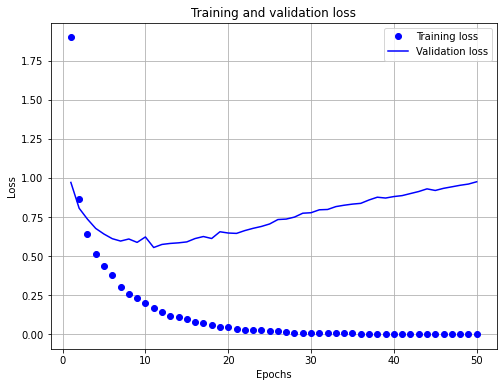

In [104]:
# Plot traing loss and validation loss
plot_loss(his)

# Evaluate model by using validation set.
print(model.evaluate(X_val_VGG,y_val))
print(model.evaluate(X_test_VGG,y_test))

### Formulate modified neural network
**According to the previous result, we modify the network deeper (more hidden layers) and bigger (more hidden units). To avoid the overfitting, the l2 regularization and drop out layer are also considered.**

In [144]:
# Defeine new layer variable. 
hidden_units_complex = 32
C_complex = 0.02
dropout_ratio_complex = 0.2

# Define training variable
epochs_complex = 200
batch_size_complex = 128

# Create the new model with l2 regularization and drop out layer.
model_complex = models.Sequential()
model_complex.add(layers.Dense(units=hidden_units_complex, activation='relu', 
                               kernel_regularizer=regularizers.l2(C_complex), input_shape=[input_units]))
model_complex.add(layers.Dropout(dropout_ratio_complex))
model_complex.add(layers.Dense(units=hidden_units_complex, activation='relu', 
                               kernel_regularizer=regularizers.l2(C_complex)))
model_complex.add(layers.Dropout(dropout_ratio_complex))
model_complex.add(layers.Dense(units=hidden_units_complex, activation='relu', 
                               kernel_regularizer=regularizers.l2(C_complex)))
model_complex.add(layers.Dropout(dropout_ratio_complex))
model_complex.add(layers.Dense(units=hidden_units_complex, activation='relu', 
                               kernel_regularizer=regularizers.l2(C_complex)))
model_complex.add(layers.Dropout(dropout_ratio_complex))
model_complex.add(layers.Dense(units=output_units, activation='softmax'))

# Configure the model with optimizer, loss function and metrics.
model_complex.compile(optimizer=optimizers.Adam(),
              loss=losses.CategoricalCrossentropy(),
              metrics=[metrics.CategoricalAccuracy()])

# Check result.
print(model_complex.summary())

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 32)                16416     
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_68 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_22 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 32)              

In [145]:
#  Train the model and evaluate with the validation set in every epoch.
history_complex = model_complex.fit(X_train_new,
                                    y_train_new,
                                    epochs=epochs_complex,
                                    batch_size=batch_size_complex,
                                    validation_data=(X_val,y_val))

ValueError: Error when checking input: expected dense_66_input to have 2 dimensions, but got array with shape (2430, 128, 128, 1)

In [ ]:
# Plot traing loss and validation loss
plot_loss(his)

# Evaluate model by using validation set.
print(model_complex.evaluate(X_val,y_val))
print(model_complex.evaluate(X_test,y_test))

### Model Evaluation
**Get predictions from the model, then create the confusion matrix, the classification report and check the accuracy score, cohen kappa score .**

In [42]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, cohen_kappa_score

In [43]:
# Get predictions from the model.
pred = model.predict(X_test_VGG_256_norm)

# Print model performance: Confusion matrix, accuracy score and classification report.
print('Confusion matrix: \n', confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1)), '\n')
print('Classification report: \n', classification_report(y_test.argmax(axis=1), pred.argmax(axis=1)), '\n') 
print('Accuracy on test set: ', accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)), '\n')
print('cohen_kappa score：',cohen_kappa_score(y_test.argmax(axis=1), pred.argmax(axis=1)))

Confusion matrix: 
 [[44  0  0  0]
 [ 2 85  6  1]
 [ 1  2 74  2]
 [ 0  0  5 78]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        44
           1       0.98      0.90      0.94        94
           2       0.87      0.94      0.90        79
           3       0.96      0.94      0.95        83

    accuracy                           0.94       300
   macro avg       0.94      0.95      0.94       300
weighted avg       0.94      0.94      0.94       300
 

Accuracy on test set:  0.9366666666666666 

cohen_kappa score： 0.9140478919114543


## 2. Hyperparameter tuning: GridsearchCV 
**Let's also try to tune the hyper-parameters of neural network with help of GridsearchCV(). We tune number of hidden units, drop out ratio and regularization parameter.**

In [114]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [115]:
# This function is used to build and compile model with genreal number of hidden units, drop out ratio and regularzation parameter  
def create_model(hidden_units=16, dropout_ratio=0.2, C=0.02):
    # Create the model.
    model = models.Sequential()    
    model.add(layers.Dense(units=hidden_units, activation='relu', 
                           kernel_regularizer=regularizers.l2(C), input_shape=[input_units]))
    model.add(layers.Dropout(dropout_ratio))
    model.add(layers.Dense(units=hidden_units, activation='relu', 
                           kernel_regularizer=regularizers.l2(C)))
    model.add(layers.Dropout(dropout_ratio))
    model.add(layers.Dense(units=hidden_units, activation='relu', 
                           kernel_regularizer=regularizers.l2(C)))
    model.add(layers.Dropout(dropout_ratio))
    model.add(layers.Dense(units=hidden_units, activation='relu', 
                           kernel_regularizer=regularizers.l2(C)))
    model.add(layers.Dropout(dropout_ratio))
    model.add(layers.Dense(units=output_units, activation='softmax'))

    # Configure the model with optimizer, loss function and metrics.
    model.compile(optimizer=optimizers.Adam(),
                  loss=losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model


# Create a model wrapper with help of KerasClassifier().
model_grid = KerasClassifier(build_fn=create_model, epochs=200,batch_size=128, verbose=1)

In [116]:
# Create a dictionary called param_grid and fill out some parameters for hidden units, C and drop out ratio.
hidden_units_grid = [16,32,64]
C_grid = [0.02,0.2]
dropout_ratio_grid = [0.1,0.2,0.5]

param_grid = dict(hidden_units=hidden_units_grid,
                  C=C_grid,
                  dropout_ratio=dropout_ratio_grid)

In [117]:
# Create a GridSearchCV() object and fit it to the training data, also evaluate with validation data.
grid = GridSearchCV(model_grid, param_grid=param_grid)
grid_result = grid.fit(X_train_new,
                       y_train_new,
                       validation_data=(X_val,y_val))

Train on 1944 samples, validate on 270 samples
Epoch 1/200
1944/1944 [==============================] - 1s 335us/sample - loss: 2.9320 - accuracy: 0.3529 - val_loss: 2.1615 - val_accuracy: 0.6630
Epoch 2/200
1944/1944 [==============================] - 0s 27us/sample - loss: 2.1086 - accuracy: 0.6718 - val_loss: 1.8685 - val_accuracy: 0.8074
Epoch 3/200
1944/1944 [==============================] - 0s 19us/sample - loss: 1.9055 - accuracy: 0.7809 - val_loss: 1.7475 - val_accuracy: 0.8333
Epoch 4/200
1944/1944 [==============================] - 0s 22us/sample - loss: 1.7800 - accuracy: 0.8225 - val_loss: 1.6488 - val_accuracy: 0.8407
Epoch 5/200
1944/1944 [==============================] - 0s 20us/sample - loss: 1.6568 - accuracy: 0.8395 - val_loss: 1.5610 - val_accuracy: 0.8444
Epoch 6/200
1944/1944 [==============================] - 0s 24us/sample - loss: 1.5734 - accuracy: 0.8503 - val_loss: 1.4811 - val_accuracy: 0.8481
Epoch 7/200
1944/1944 [==============================] - 0s 16us

Epoch 56/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.2334 - accuracy: 0.9918 - val_loss: 0.3502 - val_accuracy: 0.9593
Epoch 57/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.2283 - accuracy: 0.9897 - val_loss: 0.3511 - val_accuracy: 0.9593
Epoch 58/200
1944/1944 [==============================] - 0s 33us/sample - loss: 0.2280 - accuracy: 0.9877 - val_loss: 0.3479 - val_accuracy: 0.9481
Epoch 59/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.2206 - accuracy: 0.9907 - val_loss: 0.3367 - val_accuracy: 0.9519
Epoch 60/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.2175 - accuracy: 0.9902 - val_loss: 0.3246 - val_accuracy: 0.9556
Epoch 61/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.2199 - accuracy: 0.9871 - val_loss: 0.3295 - val_accuracy: 0.9593
Epoch 62/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.2064 - accuracy: 0.9928

Epoch 111/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.1274 - accuracy: 0.9938 - val_loss: 0.2711 - val_accuracy: 0.9556
Epoch 112/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1268 - accuracy: 0.9943 - val_loss: 0.2747 - val_accuracy: 0.9593
Epoch 113/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1306 - accuracy: 0.9923 - val_loss: 0.2735 - val_accuracy: 0.9593
Epoch 114/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1315 - accuracy: 0.9923 - val_loss: 0.2865 - val_accuracy: 0.9593
Epoch 115/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.1293 - accuracy: 0.9938 - val_loss: 0.2880 - val_accuracy: 0.9556
Epoch 116/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.1204 - accuracy: 0.9974 - val_loss: 0.2879 - val_accuracy: 0.9481
Epoch 117/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1287 - accuracy:

Epoch 19/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.9578 - accuracy: 0.8976 - val_loss: 0.9488 - val_accuracy: 0.8926
Epoch 20/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.9144 - accuracy: 0.9043 - val_loss: 0.9182 - val_accuracy: 0.9037
Epoch 21/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.8959 - accuracy: 0.9084 - val_loss: 0.8839 - val_accuracy: 0.9037
Epoch 22/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.8497 - accuracy: 0.9064 - val_loss: 0.8485 - val_accuracy: 0.9037
Epoch 23/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.8249 - accuracy: 0.9064 - val_loss: 0.8207 - val_accuracy: 0.9037
Epoch 24/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.7921 - accuracy: 0.9074 - val_loss: 0.7937 - val_accuracy: 0.9074
Epoch 25/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.7616 - accuracy: 0.9182

1944/1944 [==============================] - 0s 22us/sample - loss: 0.1295 - accuracy: 0.9938 - val_loss: 0.2342 - val_accuracy: 0.9667
Epoch 128/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.1304 - accuracy: 0.9907 - val_loss: 0.2198 - val_accuracy: 0.9667
Epoch 129/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1297 - accuracy: 0.9918 - val_loss: 0.2313 - val_accuracy: 0.9704
Epoch 130/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1244 - accuracy: 0.9928 - val_loss: 0.2352 - val_accuracy: 0.9630
Epoch 131/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1270 - accuracy: 0.9918 - val_loss: 0.2413 - val_accuracy: 0.9667
Epoch 132/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.1275 - accuracy: 0.9923 - val_loss: 0.2404 - val_accuracy: 0.9741
Epoch 133/200
1944/1944 [==============================] - 0s 15us/sample - loss: 0.1265 - accuracy: 0.9938 - val_

Epoch 182/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1077 - accuracy: 0.9918 - val_loss: 0.2330 - val_accuracy: 0.9704
Epoch 183/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.1104 - accuracy: 0.9918 - val_loss: 0.2407 - val_accuracy: 0.9630
Epoch 184/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.1073 - accuracy: 0.9938 - val_loss: 0.2531 - val_accuracy: 0.9630
Epoch 185/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.1127 - accuracy: 0.9907 - val_loss: 0.2596 - val_accuracy: 0.9593
Epoch 186/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.1074 - accuracy: 0.9949 - val_loss: 0.2566 - val_accuracy: 0.9704
Epoch 187/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.1028 - accuracy: 0.9959 - val_loss: 0.2428 - val_accuracy: 0.9704
Epoch 188/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1038 - accuracy:

Epoch 36/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.3385 - accuracy: 0.9691 - val_loss: 0.4218 - val_accuracy: 0.9519
Epoch 37/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.3238 - accuracy: 0.9722 - val_loss: 0.4124 - val_accuracy: 0.9519
Epoch 38/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.3063 - accuracy: 0.9769 - val_loss: 0.4077 - val_accuracy: 0.9519
Epoch 39/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.2991 - accuracy: 0.9733 - val_loss: 0.3987 - val_accuracy: 0.9519
Epoch 40/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.2825 - accuracy: 0.9799 - val_loss: 0.3820 - val_accuracy: 0.9519
Epoch 41/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.2797 - accuracy: 0.9799 - val_loss: 0.3818 - val_accuracy: 0.9519
Epoch 42/200
1944/1944 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.99 - 0s 17u

Epoch 90/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.1266 - accuracy: 0.9949 - val_loss: 0.2598 - val_accuracy: 0.9630
Epoch 91/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.1239 - accuracy: 0.9943 - val_loss: 0.2551 - val_accuracy: 0.9667
Epoch 92/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.1195 - accuracy: 0.9959 - val_loss: 0.2502 - val_accuracy: 0.9667
Epoch 93/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.1204 - accuracy: 0.9928 - val_loss: 0.2496 - val_accuracy: 0.9667
Epoch 94/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.1212 - accuracy: 0.9928 - val_loss: 0.2569 - val_accuracy: 0.9593
Epoch 95/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.1175 - accuracy: 0.9954 - val_loss: 0.2557 - val_accuracy: 0.9593
Epoch 96/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.1141 - accuracy: 0.9969

Epoch 145/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1007 - accuracy: 0.9959 - val_loss: 0.2417 - val_accuracy: 0.9519
Epoch 146/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.0997 - accuracy: 0.9954 - val_loss: 0.2373 - val_accuracy: 0.9630
Epoch 147/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.0955 - accuracy: 0.9964 - val_loss: 0.2403 - val_accuracy: 0.9630
Epoch 148/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.0960 - accuracy: 0.9954 - val_loss: 0.2370 - val_accuracy: 0.9593
Epoch 149/200
1944/1944 [==============================] - 0s 15us/sample - loss: 0.0971 - accuracy: 0.9938 - val_loss: 0.2293 - val_accuracy: 0.9593
Epoch 150/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.0977 - accuracy: 0.9954 - val_loss: 0.2344 - val_accuracy: 0.9556
Epoch 151/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.0955 - accuracy:

1944/1944 [==============================] - 0s 21us/sample - loss: 0.1898 - accuracy: 0.9902 - val_loss: 0.3632 - val_accuracy: 0.9519
Epoch 54/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1881 - accuracy: 0.9902 - val_loss: 0.3527 - val_accuracy: 0.9519
Epoch 55/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1880 - accuracy: 0.9897 - val_loss: 0.3446 - val_accuracy: 0.9556
Epoch 56/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1929 - accuracy: 0.9861 - val_loss: 0.3535 - val_accuracy: 0.9481
Epoch 57/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1852 - accuracy: 0.9887 - val_loss: 0.3529 - val_accuracy: 0.9481
Epoch 58/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1860 - accuracy: 0.9882 - val_loss: 0.3446 - val_accuracy: 0.9444
Epoch 59/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1784 - accuracy: 0.9902 - val_loss: 

Epoch 108/200
1944/1944 [==============================] - ETA: 0s - loss: 0.1082 - accuracy: 0.99 - 0s 13us/sample - loss: 0.1152 - accuracy: 0.9933 - val_loss: 0.3165 - val_accuracy: 0.9407
Epoch 109/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.1120 - accuracy: 0.9949 - val_loss: 0.3189 - val_accuracy: 0.9333
Epoch 110/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1142 - accuracy: 0.9938 - val_loss: 0.3002 - val_accuracy: 0.9370
Epoch 111/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.1149 - accuracy: 0.9969 - val_loss: 0.3006 - val_accuracy: 0.9407
Epoch 112/200
1944/1944 [==============================] - 0s 15us/sample - loss: 0.1127 - accuracy: 0.9969 - val_loss: 0.2899 - val_accuracy: 0.9444
Epoch 113/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1102 - accuracy: 0.9964 - val_loss: 0.2805 - val_accuracy: 0.9444
Epoch 114/200
1944/1944 [==============================] -

1944/1944 [==============================] - 0s 20us/sample - loss: 0.1032 - accuracy: 0.9943 - val_loss: 0.3230 - val_accuracy: 0.9370
Epoch 163/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.1056 - accuracy: 0.9949 - val_loss: 0.3099 - val_accuracy: 0.9407
Epoch 164/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.1085 - accuracy: 0.9928 - val_loss: 0.3137 - val_accuracy: 0.9370
Epoch 165/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.1057 - accuracy: 0.9938 - val_loss: 0.3186 - val_accuracy: 0.9333
Epoch 166/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.1089 - accuracy: 0.9913 - val_loss: 0.3205 - val_accuracy: 0.9370
Epoch 167/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.1099 - accuracy: 0.9923 - val_loss: 0.2987 - val_accuracy: 0.9370
Epoch 168/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.1064 - accuracy: 0.9928 - val_

Epoch 16/200
1944/1944 [==============================] - 0s 21us/sample - loss: 1.0649 - accuracy: 0.8894 - val_loss: 1.0755 - val_accuracy: 0.8889
Epoch 17/200
1944/1944 [==============================] - 0s 16us/sample - loss: 1.0334 - accuracy: 0.8837 - val_loss: 1.0381 - val_accuracy: 0.8926
Epoch 18/200
1944/1944 [==============================] - 0s 15us/sample - loss: 0.9989 - accuracy: 0.8951 - val_loss: 1.0014 - val_accuracy: 0.9000
Epoch 19/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.9568 - accuracy: 0.8920 - val_loss: 0.9637 - val_accuracy: 0.9000
Epoch 20/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.9026 - accuracy: 0.9007 - val_loss: 0.9316 - val_accuracy: 0.8963
Epoch 21/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.8778 - accuracy: 0.8966 - val_loss: 0.9028 - val_accuracy: 0.8852
Epoch 22/200
1944/1944 [==============================] - 0s 15us/sample - loss: 0.8426 - accuracy: 0.9079

Epoch 71/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.2291 - accuracy: 0.9866 - val_loss: 0.3823 - val_accuracy: 0.9407
Epoch 72/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.2226 - accuracy: 0.9866 - val_loss: 0.3748 - val_accuracy: 0.9370
Epoch 73/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.2185 - accuracy: 0.9887 - val_loss: 0.3624 - val_accuracy: 0.9444
Epoch 74/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.2206 - accuracy: 0.9866 - val_loss: 0.3675 - val_accuracy: 0.9370
Epoch 75/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.2091 - accuracy: 0.9918 - val_loss: 0.3719 - val_accuracy: 0.9370
Epoch 76/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.2069 - accuracy: 0.9918 - val_loss: 0.3877 - val_accuracy: 0.9370
Epoch 77/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.2030 - accuracy: 0.9887

Epoch 126/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1394 - accuracy: 0.9871 - val_loss: 0.3030 - val_accuracy: 0.9333
Epoch 127/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.1386 - accuracy: 0.9913 - val_loss: 0.3106 - val_accuracy: 0.9333
Epoch 128/200
1944/1944 [==============================] - 0s 14us/sample - loss: 0.1428 - accuracy: 0.9902 - val_loss: 0.2934 - val_accuracy: 0.9481
Epoch 129/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.1397 - accuracy: 0.9897 - val_loss: 0.2925 - val_accuracy: 0.9444
Epoch 130/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.1315 - accuracy: 0.9933 - val_loss: 0.2951 - val_accuracy: 0.9481
Epoch 131/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.1312 - accuracy: 0.9933 - val_loss: 0.2920 - val_accuracy: 0.9407
Epoch 132/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1264 - accuracy:

1944/1944 [==============================] - 0s 21us/sample - loss: 0.3184 - accuracy: 0.9866 - val_loss: 0.4776 - val_accuracy: 0.9481
Epoch 35/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.3056 - accuracy: 0.9835 - val_loss: 0.4594 - val_accuracy: 0.9444
Epoch 36/200
1944/1944 [==============================] - 0s 32us/sample - loss: 0.2895 - accuracy: 0.9887 - val_loss: 0.4622 - val_accuracy: 0.9481
Epoch 37/200
1944/1944 [==============================] - 0s 31us/sample - loss: 0.2790 - accuracy: 0.9851 - val_loss: 0.4362 - val_accuracy: 0.9407
Epoch 38/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.2681 - accuracy: 0.9861 - val_loss: 0.4424 - val_accuracy: 0.9407
Epoch 39/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.2548 - accuracy: 0.9913 - val_loss: 0.4421 - val_accuracy: 0.9407
Epoch 40/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.2519 - accuracy: 0.9887 - val_loss: 

1944/1944 [==============================] - 0s 20us/sample - loss: 0.1050 - accuracy: 0.9964 - val_loss: 0.2710 - val_accuracy: 0.9444
Epoch 90/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1038 - accuracy: 0.9974 - val_loss: 0.3093 - val_accuracy: 0.9370
Epoch 91/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1104 - accuracy: 0.9949 - val_loss: 0.2895 - val_accuracy: 0.9481
Epoch 92/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1063 - accuracy: 0.9954 - val_loss: 0.2915 - val_accuracy: 0.9370
Epoch 93/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.1021 - accuracy: 0.9964 - val_loss: 0.2922 - val_accuracy: 0.9444
Epoch 94/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1114 - accuracy: 0.9933 - val_loss: 0.3386 - val_accuracy: 0.9333
Epoch 95/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1209 - accuracy: 0.9918 - val_loss: 

Epoch 144/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.0930 - accuracy: 0.9959 - val_loss: 0.2917 - val_accuracy: 0.9407
Epoch 145/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.0887 - accuracy: 0.9969 - val_loss: 0.2676 - val_accuracy: 0.9407
Epoch 146/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.0866 - accuracy: 0.9974 - val_loss: 0.2698 - val_accuracy: 0.9444
Epoch 147/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.0884 - accuracy: 0.9964 - val_loss: 0.2759 - val_accuracy: 0.9444
Epoch 148/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.0838 - accuracy: 0.9979 - val_loss: 0.2575 - val_accuracy: 0.9444
Epoch 149/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.0867 - accuracy: 0.9964 - val_loss: 0.2476 - val_accuracy: 0.9444
Epoch 150/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.0836 - accuracy:

1944/1944 [==============================] - 0s 20us/sample - loss: 0.2088 - accuracy: 0.9949 - val_loss: 0.3418 - val_accuracy: 0.9667
Epoch 53/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.2019 - accuracy: 0.9949 - val_loss: 0.3397 - val_accuracy: 0.9630
Epoch 54/200
1944/1944 [==============================] - 0s 15us/sample - loss: 0.1990 - accuracy: 0.9938 - val_loss: 0.3399 - val_accuracy: 0.9593
Epoch 55/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.1983 - accuracy: 0.9943 - val_loss: 0.3442 - val_accuracy: 0.9593
Epoch 56/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1939 - accuracy: 0.9964 - val_loss: 0.3293 - val_accuracy: 0.9630
Epoch 57/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1883 - accuracy: 0.9949 - val_loss: 0.3278 - val_accuracy: 0.9556
Epoch 58/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1829 - accuracy: 0.9959 - val_loss: 

1944/1944 [==============================] - 0s 21us/sample - loss: 0.1168 - accuracy: 0.9979 - val_loss: 0.2786 - val_accuracy: 0.9593
Epoch 108/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1160 - accuracy: 0.9943 - val_loss: 0.2813 - val_accuracy: 0.9593
Epoch 109/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1155 - accuracy: 0.9943 - val_loss: 0.2781 - val_accuracy: 0.9593
Epoch 110/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1127 - accuracy: 0.9964 - val_loss: 0.2678 - val_accuracy: 0.9593
Epoch 111/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1091 - accuracy: 0.9969 - val_loss: 0.2748 - val_accuracy: 0.9593
Epoch 112/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1042 - accuracy: 0.9979 - val_loss: 0.2755 - val_accuracy: 0.9593
Epoch 113/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1041 - accuracy: 0.9995 - val_

Epoch 15/200
1944/1944 [==============================] - 0s 20us/sample - loss: 1.1045 - accuracy: 0.9280 - val_loss: 1.1133 - val_accuracy: 0.9333
Epoch 16/200
1944/1944 [==============================] - 0s 20us/sample - loss: 1.0238 - accuracy: 0.9357 - val_loss: 1.0357 - val_accuracy: 0.9333
Epoch 17/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.9513 - accuracy: 0.9388 - val_loss: 0.9722 - val_accuracy: 0.9370
Epoch 18/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.8728 - accuracy: 0.9450 - val_loss: 0.9269 - val_accuracy: 0.9370
Epoch 19/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.8133 - accuracy: 0.9480 - val_loss: 0.8764 - val_accuracy: 0.9370
Epoch 20/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.7629 - accuracy: 0.9496 - val_loss: 0.8239 - val_accuracy: 0.9407
Epoch 21/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.7005 - accuracy: 0.9588

Epoch 70/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.1195 - accuracy: 0.9959 - val_loss: 0.2657 - val_accuracy: 0.9593
Epoch 71/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1121 - accuracy: 0.9990 - val_loss: 0.2709 - val_accuracy: 0.9593
Epoch 72/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1117 - accuracy: 0.9979 - val_loss: 0.2593 - val_accuracy: 0.9593
Epoch 73/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.1115 - accuracy: 0.9974 - val_loss: 0.2761 - val_accuracy: 0.9593
Epoch 74/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1163 - accuracy: 0.9949 - val_loss: 0.2544 - val_accuracy: 0.9593
Epoch 75/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1243 - accuracy: 0.9923 - val_loss: 0.2600 - val_accuracy: 0.9556
Epoch 76/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1210 - accuracy: 0.9933

1944/1944 [==============================] - 0s 23us/sample - loss: 0.0714 - accuracy: 0.9985 - val_loss: 0.1962 - val_accuracy: 0.9630
Epoch 179/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.0704 - accuracy: 0.9990 - val_loss: 0.2283 - val_accuracy: 0.9593
Epoch 180/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.0770 - accuracy: 0.9985 - val_loss: 0.2222 - val_accuracy: 0.9593
Epoch 181/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.0918 - accuracy: 0.9913 - val_loss: 0.2209 - val_accuracy: 0.9593
Epoch 182/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.0899 - accuracy: 0.9943 - val_loss: 0.2317 - val_accuracy: 0.9630
Epoch 183/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.0870 - accuracy: 0.9969 - val_loss: 0.2470 - val_accuracy: 0.9593
Epoch 184/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.0895 - accuracy: 0.9949 - val_

Epoch 32/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.3614 - accuracy: 0.9877 - val_loss: 0.5210 - val_accuracy: 0.9444
Epoch 33/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.3492 - accuracy: 0.9856 - val_loss: 0.5042 - val_accuracy: 0.9407
Epoch 34/200
1944/1944 [==============================] - ETA: 0s - loss: 0.3297 - accuracy: 0.99 - 0s 25us/sample - loss: 0.3275 - accuracy: 0.9871 - val_loss: 0.4979 - val_accuracy: 0.9407
Epoch 35/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.3175 - accuracy: 0.9897 - val_loss: 0.5018 - val_accuracy: 0.9444
Epoch 36/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.3097 - accuracy: 0.9841 - val_loss: 0.4834 - val_accuracy: 0.9444
Epoch 37/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.2922 - accuracy: 0.9897 - val_loss: 0.4626 - val_accuracy: 0.9444
Epoch 38/200
1944/1944 [==============================] - 0s 22u

Epoch 87/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.1140 - accuracy: 0.9969 - val_loss: 0.3212 - val_accuracy: 0.9481
Epoch 88/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.1124 - accuracy: 0.9979 - val_loss: 0.3274 - val_accuracy: 0.9444
Epoch 89/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1127 - accuracy: 0.9974 - val_loss: 0.3280 - val_accuracy: 0.9481
Epoch 90/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1110 - accuracy: 0.9979 - val_loss: 0.3117 - val_accuracy: 0.9444
Epoch 91/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1063 - accuracy: 0.9990 - val_loss: 0.3160 - val_accuracy: 0.9519
Epoch 92/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1117 - accuracy: 0.9964 - val_loss: 0.3106 - val_accuracy: 0.9444
Epoch 93/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1166 - accuracy: 0.9954

Epoch 142/200
1944/1944 [==============================] - 0s 31us/sample - loss: 0.0960 - accuracy: 0.9954 - val_loss: 0.3125 - val_accuracy: 0.9407
Epoch 143/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.0982 - accuracy: 0.9938 - val_loss: 0.3182 - val_accuracy: 0.9370
Epoch 144/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.0951 - accuracy: 0.9954 - val_loss: 0.3152 - val_accuracy: 0.9444
Epoch 145/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.0915 - accuracy: 0.9974 - val_loss: 0.3256 - val_accuracy: 0.9370
Epoch 146/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.0939 - accuracy: 0.9959 - val_loss: 0.3327 - val_accuracy: 0.9444
Epoch 147/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.0971 - accuracy: 0.9954 - val_loss: 0.2919 - val_accuracy: 0.9481
Epoch 148/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1005 - accuracy:

1944/1944 [==============================] - 0s 22us/sample - loss: 0.1544 - accuracy: 0.9907 - val_loss: 0.2698 - val_accuracy: 0.9556
Epoch 50/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1550 - accuracy: 0.9871 - val_loss: 0.2583 - val_accuracy: 0.9556
Epoch 51/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1480 - accuracy: 0.9923 - val_loss: 0.2697 - val_accuracy: 0.9556
Epoch 52/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1426 - accuracy: 0.9933 - val_loss: 0.2678 - val_accuracy: 0.9593
Epoch 53/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1391 - accuracy: 0.9954 - val_loss: 0.2619 - val_accuracy: 0.9667
Epoch 54/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1390 - accuracy: 0.9933 - val_loss: 0.2622 - val_accuracy: 0.9630
Epoch 55/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1346 - accuracy: 0.9964 - val_loss: 

1944/1944 [==============================] - 0s 24us/sample - loss: 0.0986 - accuracy: 0.9949 - val_loss: 0.2310 - val_accuracy: 0.9407
Epoch 105/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.0979 - accuracy: 0.9969 - val_loss: 0.2266 - val_accuracy: 0.9556
Epoch 106/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.0972 - accuracy: 0.9969 - val_loss: 0.2351 - val_accuracy: 0.9593
Epoch 107/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.1068 - accuracy: 0.9902 - val_loss: 0.2734 - val_accuracy: 0.9333
Epoch 108/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1124 - accuracy: 0.9902 - val_loss: 0.2392 - val_accuracy: 0.9519
Epoch 109/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1083 - accuracy: 0.9928 - val_loss: 0.2553 - val_accuracy: 0.9481
Epoch 110/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1049 - accuracy: 0.9959 - val_

Epoch 159/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.0915 - accuracy: 0.9969 - val_loss: 0.2773 - val_accuracy: 0.9519
Epoch 160/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.0946 - accuracy: 0.9964 - val_loss: 0.2791 - val_accuracy: 0.9519
Epoch 161/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.0927 - accuracy: 0.9959 - val_loss: 0.2644 - val_accuracy: 0.9481
Epoch 162/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.0939 - accuracy: 0.9959 - val_loss: 0.2713 - val_accuracy: 0.9519
Epoch 163/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.0926 - accuracy: 0.9964 - val_loss: 0.2677 - val_accuracy: 0.9556
Epoch 164/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.0915 - accuracy: 0.9974 - val_loss: 0.2750 - val_accuracy: 0.9556
Epoch 165/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.0841 - accuracy:

1944/1944 [==============================] - 0s 29us/sample - loss: 0.1296 - accuracy: 0.9959 - val_loss: 0.2886 - val_accuracy: 0.9407
Epoch 68/200
1944/1944 [==============================] - ETA: 0s - loss: 0.1266 - accuracy: 1.00 - 0s 32us/sample - loss: 0.1292 - accuracy: 0.9979 - val_loss: 0.2814 - val_accuracy: 0.9407
Epoch 69/200
1944/1944 [==============================] - 0s 31us/sample - loss: 0.1255 - accuracy: 0.9974 - val_loss: 0.2821 - val_accuracy: 0.9519
Epoch 70/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.1271 - accuracy: 0.9954 - val_loss: 0.2802 - val_accuracy: 0.9519
Epoch 71/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.1255 - accuracy: 0.9974 - val_loss: 0.2747 - val_accuracy: 0.9519
Epoch 72/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1254 - accuracy: 0.9979 - val_loss: 0.2551 - val_accuracy: 0.9519
Epoch 73/200
1944/1944 [==============================] - 0s 28us/sample - lo

Epoch 176/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.0976 - accuracy: 0.9979 - val_loss: 0.2423 - val_accuracy: 0.9593
Epoch 177/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.0954 - accuracy: 0.9979 - val_loss: 0.2414 - val_accuracy: 0.9519
Epoch 178/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.0902 - accuracy: 0.9995 - val_loss: 0.2443 - val_accuracy: 0.9519
Epoch 179/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.0903 - accuracy: 0.9985 - val_loss: 0.2507 - val_accuracy: 0.9481
Epoch 180/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.0862 - accuracy: 0.9990 - val_loss: 0.2457 - val_accuracy: 0.9481
Epoch 181/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.0860 - accuracy: 0.9969 - val_loss: 0.2357 - val_accuracy: 0.9556
Epoch 182/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.0837 - accuracy:

Epoch 30/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.3961 - accuracy: 0.9959 - val_loss: 0.5497 - val_accuracy: 0.9519
Epoch 31/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.3679 - accuracy: 0.9938 - val_loss: 0.5097 - val_accuracy: 0.9593
Epoch 32/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.3549 - accuracy: 0.9897 - val_loss: 0.4800 - val_accuracy: 0.9630
Epoch 33/200
1944/1944 [==============================] - 0s 32us/sample - loss: 0.3283 - accuracy: 0.9923 - val_loss: 0.4485 - val_accuracy: 0.9556
Epoch 34/200
1944/1944 [==============================] - 0s 51us/sample - loss: 0.3177 - accuracy: 0.9892 - val_loss: 0.4564 - val_accuracy: 0.9481
Epoch 35/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.3156 - accuracy: 0.9830 - val_loss: 0.4431 - val_accuracy: 0.9593
Epoch 36/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.3096 - accuracy: 0.9861

Epoch 85/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.1090 - accuracy: 0.9943 - val_loss: 0.2678 - val_accuracy: 0.9481
Epoch 86/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1066 - accuracy: 0.9969 - val_loss: 0.2711 - val_accuracy: 0.9444
Epoch 87/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1099 - accuracy: 0.9943 - val_loss: 0.2688 - val_accuracy: 0.9556
Epoch 88/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1050 - accuracy: 0.9985 - val_loss: 0.2800 - val_accuracy: 0.9519
Epoch 89/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.1047 - accuracy: 0.9964 - val_loss: 0.2657 - val_accuracy: 0.9556
Epoch 90/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.1095 - accuracy: 0.9964 - val_loss: 0.2654 - val_accuracy: 0.9556
Epoch 91/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1089 - accuracy: 0.9964

Epoch 139/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1014 - accuracy: 0.9949 - val_loss: 0.2875 - val_accuracy: 0.9593
Epoch 140/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.1066 - accuracy: 0.9933 - val_loss: 0.2928 - val_accuracy: 0.9593
Epoch 141/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.1066 - accuracy: 0.9949 - val_loss: 0.2748 - val_accuracy: 0.9556
Epoch 142/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1039 - accuracy: 0.9964 - val_loss: 0.2854 - val_accuracy: 0.9556
Epoch 143/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.1005 - accuracy: 0.9969 - val_loss: 0.2718 - val_accuracy: 0.9593
Epoch 144/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.0940 - accuracy: 0.9964 - val_loss: 0.2624 - val_accuracy: 0.9667
Epoch 145/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.0877 - accuracy:

Epoch 47/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.1432 - accuracy: 0.9959 - val_loss: 0.2942 - val_accuracy: 0.9481
Epoch 48/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.1376 - accuracy: 0.9964 - val_loss: 0.2902 - val_accuracy: 0.9519
Epoch 49/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1290 - accuracy: 0.9990 - val_loss: 0.2687 - val_accuracy: 0.9556
Epoch 50/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.1254 - accuracy: 0.9990 - val_loss: 0.2609 - val_accuracy: 0.9556
Epoch 51/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.1276 - accuracy: 0.9959 - val_loss: 0.2810 - val_accuracy: 0.9556
Epoch 52/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1256 - accuracy: 0.9964 - val_loss: 0.2753 - val_accuracy: 0.9593
Epoch 53/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.1244 - accuracy: 0.9959

Epoch 102/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.0858 - accuracy: 0.9979 - val_loss: 0.2228 - val_accuracy: 0.9556
Epoch 103/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.1099 - accuracy: 0.9902 - val_loss: 0.2427 - val_accuracy: 0.9444
Epoch 104/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1107 - accuracy: 0.9913 - val_loss: 0.2352 - val_accuracy: 0.9556
Epoch 105/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.1106 - accuracy: 0.9928 - val_loss: 0.2574 - val_accuracy: 0.9556
Epoch 106/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1082 - accuracy: 0.9943 - val_loss: 0.2318 - val_accuracy: 0.9593
Epoch 107/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.1001 - accuracy: 0.9964 - val_loss: 0.2439 - val_accuracy: 0.9593
Epoch 108/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.0938 - accuracy:

1944/1944 [==============================] - 0s 23us/sample - loss: 0.0727 - accuracy: 0.9995 - val_loss: 0.2005 - val_accuracy: 0.9667
Epoch 157/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.0728 - accuracy: 0.9985 - val_loss: 0.1928 - val_accuracy: 0.9593
Epoch 158/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.0743 - accuracy: 0.9985 - val_loss: 0.2049 - val_accuracy: 0.9667
Epoch 159/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.0739 - accuracy: 0.9985 - val_loss: 0.1964 - val_accuracy: 0.9667
Epoch 160/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.0706 - accuracy: 0.9995 - val_loss: 0.2086 - val_accuracy: 0.9630
Epoch 161/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.0729 - accuracy: 0.9985 - val_loss: 0.1967 - val_accuracy: 0.9630
Epoch 162/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.0777 - accuracy: 0.9979 - val_

Epoch 10/200
1944/1944 [==============================] - 0s 33us/sample - loss: 2.2588 - accuracy: 0.9367 - val_loss: 2.2025 - val_accuracy: 0.9259
Epoch 11/200
1944/1944 [==============================] - 0s 33us/sample - loss: 2.0225 - accuracy: 0.9383 - val_loss: 1.9984 - val_accuracy: 0.9259
Epoch 12/200
1944/1944 [==============================] - 0s 27us/sample - loss: 1.8148 - accuracy: 0.9532 - val_loss: 1.8179 - val_accuracy: 0.9296
Epoch 13/200
1944/1944 [==============================] - 0s 28us/sample - loss: 1.6337 - accuracy: 0.9496 - val_loss: 1.6609 - val_accuracy: 0.9259
Epoch 14/200
1944/1944 [==============================] - 0s 26us/sample - loss: 1.4767 - accuracy: 0.9594 - val_loss: 1.5126 - val_accuracy: 0.9296
Epoch 15/200
1944/1944 [==============================] - 0s 25us/sample - loss: 1.3341 - accuracy: 0.9609 - val_loss: 1.3912 - val_accuracy: 0.9333
Epoch 16/200
1944/1944 [==============================] - 0s 26us/sample - loss: 1.2047 - accuracy: 0.9640

Epoch 65/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1233 - accuracy: 0.9979 - val_loss: 0.3332 - val_accuracy: 0.9407
Epoch 66/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1207 - accuracy: 0.9979 - val_loss: 0.3250 - val_accuracy: 0.9370
Epoch 67/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.1185 - accuracy: 0.9969 - val_loss: 0.3214 - val_accuracy: 0.9444
Epoch 68/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1168 - accuracy: 0.9969 - val_loss: 0.3265 - val_accuracy: 0.9370
Epoch 69/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.1123 - accuracy: 0.9990 - val_loss: 0.3214 - val_accuracy: 0.9481
Epoch 70/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.1130 - accuracy: 0.9969 - val_loss: 0.3360 - val_accuracy: 0.9407
Epoch 71/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1095 - accuracy: 0.9979

1944/1944 [==============================] - 0s 27us/sample - loss: 0.0782 - accuracy: 0.9974 - val_loss: 0.3045 - val_accuracy: 0.9444
Epoch 174/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.0783 - accuracy: 0.9985 - val_loss: 0.2961 - val_accuracy: 0.9444
Epoch 175/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.0916 - accuracy: 0.9949 - val_loss: 0.2720 - val_accuracy: 0.9481
Epoch 176/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.1180 - accuracy: 0.9830 - val_loss: 0.2749 - val_accuracy: 0.9556
Epoch 177/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.1146 - accuracy: 0.9871 - val_loss: 0.2767 - val_accuracy: 0.9444
Epoch 178/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.1014 - accuracy: 0.9969 - val_loss: 0.3586 - val_accuracy: 0.9370
Epoch 179/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.0941 - accuracy: 0.9979 - val_

1944/1944 [==============================] - 0s 23us/sample - loss: 0.5764 - accuracy: 0.9805 - val_loss: 0.6873 - val_accuracy: 0.9593
Epoch 28/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.5293 - accuracy: 0.9877 - val_loss: 0.6481 - val_accuracy: 0.9667
Epoch 29/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4993 - accuracy: 0.9887 - val_loss: 0.6154 - val_accuracy: 0.9630
Epoch 30/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4696 - accuracy: 0.9887 - val_loss: 0.5893 - val_accuracy: 0.9556
Epoch 31/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4330 - accuracy: 0.9928 - val_loss: 0.5683 - val_accuracy: 0.9556
Epoch 32/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4282 - accuracy: 0.9794 - val_loss: 0.5627 - val_accuracy: 0.9519
Epoch 33/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4059 - accuracy: 0.9861 - val_loss: 

1944/1944 [==============================] - 0s 24us/sample - loss: 0.1079 - accuracy: 0.9979 - val_loss: 0.2731 - val_accuracy: 0.9519
Epoch 83/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.1079 - accuracy: 0.9974 - val_loss: 0.2842 - val_accuracy: 0.9370
Epoch 84/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1040 - accuracy: 0.9985 - val_loss: 0.2678 - val_accuracy: 0.9556
Epoch 85/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1021 - accuracy: 0.9979 - val_loss: 0.2679 - val_accuracy: 0.9556
Epoch 86/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.1020 - accuracy: 0.9969 - val_loss: 0.2613 - val_accuracy: 0.9593
Epoch 87/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1046 - accuracy: 0.9954 - val_loss: 0.2592 - val_accuracy: 0.9630
Epoch 88/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.0988 - accuracy: 0.9995 - val_loss: 

Epoch 137/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.0832 - accuracy: 0.9995 - val_loss: 0.2859 - val_accuracy: 0.9444
Epoch 138/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.0838 - accuracy: 0.9995 - val_loss: 0.2795 - val_accuracy: 0.9481
Epoch 139/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.0845 - accuracy: 0.9985 - val_loss: 0.2811 - val_accuracy: 0.9481
Epoch 140/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.0853 - accuracy: 0.9985 - val_loss: 0.2817 - val_accuracy: 0.9370
Epoch 141/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.0825 - accuracy: 1.0000 - val_loss: 0.2832 - val_accuracy: 0.9481
Epoch 142/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.0826 - accuracy: 0.9995 - val_loss: 0.2887 - val_accuracy: 0.9519
Epoch 143/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.0842 - accuracy:

Epoch 45/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.4182 - accuracy: 0.9486 - val_loss: 0.4553 - val_accuracy: 0.9333
Epoch 46/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4173 - accuracy: 0.9434 - val_loss: 0.4495 - val_accuracy: 0.9333
Epoch 47/200
1944/1944 [==============================] - 0s 14us/sample - loss: 0.3974 - accuracy: 0.9537 - val_loss: 0.4396 - val_accuracy: 0.9333
Epoch 48/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.3900 - accuracy: 0.9542 - val_loss: 0.4327 - val_accuracy: 0.9296
Epoch 49/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.3777 - accuracy: 0.9537 - val_loss: 0.4251 - val_accuracy: 0.9370
Epoch 50/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.3719 - accuracy: 0.9552 - val_loss: 0.4271 - val_accuracy: 0.9296
Epoch 51/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.3547 - accuracy: 0.9676

Epoch 154/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1372 - accuracy: 0.9882 - val_loss: 0.2570 - val_accuracy: 0.9370
Epoch 155/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1317 - accuracy: 0.9902 - val_loss: 0.2421 - val_accuracy: 0.9519
Epoch 156/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.1446 - accuracy: 0.9851 - val_loss: 0.2595 - val_accuracy: 0.9519
Epoch 157/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.1425 - accuracy: 0.9856 - val_loss: 0.2483 - val_accuracy: 0.9444
Epoch 158/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1446 - accuracy: 0.9846 - val_loss: 0.2572 - val_accuracy: 0.9556
Epoch 159/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1369 - accuracy: 0.9892 - val_loss: 0.2568 - val_accuracy: 0.9481
Epoch 160/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1335 - accuracy:

1944/1944 [==============================] - 0s 17us/sample - loss: 0.2722 - accuracy: 0.9784 - val_loss: 0.3606 - val_accuracy: 0.9519
Epoch 63/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.2684 - accuracy: 0.9722 - val_loss: 0.3597 - val_accuracy: 0.9481
Epoch 64/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.2634 - accuracy: 0.9743 - val_loss: 0.3540 - val_accuracy: 0.9519
Epoch 65/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.2519 - accuracy: 0.9789 - val_loss: 0.3527 - val_accuracy: 0.9556
Epoch 66/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.2518 - accuracy: 0.9774 - val_loss: 0.3371 - val_accuracy: 0.9556
Epoch 67/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.2424 - accuracy: 0.9815 - val_loss: 0.3352 - val_accuracy: 0.9519
Epoch 68/200
1944/1944 [==============================] - ETA: 0s - loss: 0.2174 - accuracy: 0.99 - 0s 22us/sample - lo

1944/1944 [==============================] - 0s 18us/sample - loss: 0.1280 - accuracy: 0.9866 - val_loss: 0.2834 - val_accuracy: 0.9556
Epoch 171/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.1315 - accuracy: 0.9882 - val_loss: 0.2677 - val_accuracy: 0.9593
Epoch 172/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1302 - accuracy: 0.9887 - val_loss: 0.2706 - val_accuracy: 0.9556
Epoch 173/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1306 - accuracy: 0.9887 - val_loss: 0.2678 - val_accuracy: 0.9556
Epoch 174/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1341 - accuracy: 0.9866 - val_loss: 0.2597 - val_accuracy: 0.9556
Epoch 175/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1294 - accuracy: 0.9907 - val_loss: 0.2649 - val_accuracy: 0.9556
Epoch 176/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.1308 - accuracy: 0.9851 - val_

Epoch 24/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.7056 - accuracy: 0.8678 - val_loss: 0.6605 - val_accuracy: 0.8778
Epoch 25/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.6710 - accuracy: 0.8611 - val_loss: 0.6335 - val_accuracy: 0.8778
Epoch 26/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.6448 - accuracy: 0.8709 - val_loss: 0.6085 - val_accuracy: 0.8926
Epoch 27/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.6067 - accuracy: 0.8724 - val_loss: 0.5856 - val_accuracy: 0.9000
Epoch 28/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.5903 - accuracy: 0.8915 - val_loss: 0.5633 - val_accuracy: 0.9185
Epoch 29/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.5665 - accuracy: 0.8992 - val_loss: 0.5435 - val_accuracy: 0.9222
Epoch 30/200
1944/1944 [==============================] - ETA: 0s - loss: 0.6097 - accuracy: 0.88 - 0s 19u

1944/1944 [==============================] - 0s 20us/sample - loss: 0.1271 - accuracy: 0.9871 - val_loss: 0.2854 - val_accuracy: 0.9630
Epoch 133/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1296 - accuracy: 0.9902 - val_loss: 0.2837 - val_accuracy: 0.9667
Epoch 134/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1308 - accuracy: 0.9902 - val_loss: 0.2916 - val_accuracy: 0.9630
Epoch 135/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1335 - accuracy: 0.9871 - val_loss: 0.2733 - val_accuracy: 0.9556
Epoch 136/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1324 - accuracy: 0.9871 - val_loss: 0.2867 - val_accuracy: 0.9630
Epoch 137/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1247 - accuracy: 0.9902 - val_loss: 0.2789 - val_accuracy: 0.9667
Epoch 138/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1250 - accuracy: 0.9918 - val_

Epoch 187/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1132 - accuracy: 0.9949 - val_loss: 0.3328 - val_accuracy: 0.9593
Epoch 188/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1085 - accuracy: 0.9938 - val_loss: 0.3287 - val_accuracy: 0.9593
Epoch 189/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1085 - accuracy: 0.9923 - val_loss: 0.3186 - val_accuracy: 0.9667
Epoch 190/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1145 - accuracy: 0.9897 - val_loss: 0.3064 - val_accuracy: 0.9630
Epoch 191/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1111 - accuracy: 0.9918 - val_loss: 0.3015 - val_accuracy: 0.9593
Epoch 192/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1266 - accuracy: 0.9856 - val_loss: 0.3088 - val_accuracy: 0.9556
Epoch 193/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.1102 - accuracy:

1944/1944 [==============================] - 0s 19us/sample - loss: 0.4127 - accuracy: 0.9280 - val_loss: 0.4810 - val_accuracy: 0.9259
Epoch 42/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.3980 - accuracy: 0.9326 - val_loss: 0.4792 - val_accuracy: 0.9185
Epoch 43/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.3926 - accuracy: 0.9388 - val_loss: 0.4676 - val_accuracy: 0.9222
Epoch 44/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.3719 - accuracy: 0.9532 - val_loss: 0.4609 - val_accuracy: 0.9296
Epoch 45/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.3683 - accuracy: 0.9542 - val_loss: 0.4577 - val_accuracy: 0.9259
Epoch 46/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.3604 - accuracy: 0.9501 - val_loss: 0.4487 - val_accuracy: 0.9259
Epoch 47/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.3552 - accuracy: 0.9563 - val_loss: 

Epoch 150/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.1405 - accuracy: 0.9897 - val_loss: 0.3525 - val_accuracy: 0.9407
Epoch 151/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.1387 - accuracy: 0.9933 - val_loss: 0.3523 - val_accuracy: 0.9370
Epoch 152/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1392 - accuracy: 0.9913 - val_loss: 0.3501 - val_accuracy: 0.9407
Epoch 153/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1339 - accuracy: 0.9918 - val_loss: 0.3235 - val_accuracy: 0.9444
Epoch 154/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1393 - accuracy: 0.9918 - val_loss: 0.3290 - val_accuracy: 0.9481
Epoch 155/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1430 - accuracy: 0.9866 - val_loss: 0.3448 - val_accuracy: 0.9370
Epoch 156/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.1342 - accuracy:

Epoch 3/200
1944/1944 [==============================] - 0s 20us/sample - loss: 1.9994 - accuracy: 0.7541 - val_loss: 1.8267 - val_accuracy: 0.8630
Epoch 4/200
1944/1944 [==============================] - 0s 22us/sample - loss: 1.8671 - accuracy: 0.7978 - val_loss: 1.7352 - val_accuracy: 0.8630
Epoch 5/200
1944/1944 [==============================] - 0s 20us/sample - loss: 1.7489 - accuracy: 0.8158 - val_loss: 1.6465 - val_accuracy: 0.8630
Epoch 6/200
1944/1944 [==============================] - 0s 20us/sample - loss: 1.6474 - accuracy: 0.8308 - val_loss: 1.5645 - val_accuracy: 0.8630
Epoch 7/200
1944/1944 [==============================] - ETA: 0s - loss: 1.5635 - accuracy: 0.83 - 0s 18us/sample - loss: 1.5606 - accuracy: 0.8318 - val_loss: 1.4834 - val_accuracy: 0.8630
Epoch 8/200
1944/1944 [==============================] - 0s 19us/sample - loss: 1.4927 - accuracy: 0.8395 - val_loss: 1.4083 - val_accuracy: 0.8630
Epoch 9/200
1944/1944 [==============================] - 0s 19us/sampl

Epoch 57/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.2521 - accuracy: 0.9835 - val_loss: 0.3920 - val_accuracy: 0.9519
Epoch 58/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.2547 - accuracy: 0.9794 - val_loss: 0.3749 - val_accuracy: 0.9519
Epoch 59/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.2535 - accuracy: 0.9784 - val_loss: 0.3745 - val_accuracy: 0.9481
Epoch 60/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.2400 - accuracy: 0.9866 - val_loss: 0.3658 - val_accuracy: 0.9519
Epoch 61/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.2362 - accuracy: 0.9877 - val_loss: 0.3624 - val_accuracy: 0.9556
Epoch 62/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.2358 - accuracy: 0.9851 - val_loss: 0.3550 - val_accuracy: 0.9556
Epoch 63/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.2323 - accuracy: 0.9825

Epoch 112/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1576 - accuracy: 0.9887 - val_loss: 0.3173 - val_accuracy: 0.9556
Epoch 113/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1519 - accuracy: 0.9897 - val_loss: 0.3150 - val_accuracy: 0.9556
Epoch 114/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1550 - accuracy: 0.9907 - val_loss: 0.3170 - val_accuracy: 0.9556
Epoch 115/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1579 - accuracy: 0.9892 - val_loss: 0.3249 - val_accuracy: 0.9556
Epoch 116/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1514 - accuracy: 0.9882 - val_loss: 0.3340 - val_accuracy: 0.9519
Epoch 117/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.1474 - accuracy: 0.9866 - val_loss: 0.3243 - val_accuracy: 0.9556
Epoch 118/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1488 - accuracy:

Epoch 20/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.6703 - accuracy: 0.9352 - val_loss: 0.6774 - val_accuracy: 0.9259
Epoch 21/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.6177 - accuracy: 0.9450 - val_loss: 0.6374 - val_accuracy: 0.9296
Epoch 22/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.5737 - accuracy: 0.9429 - val_loss: 0.6049 - val_accuracy: 0.9333
Epoch 23/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.5354 - accuracy: 0.9470 - val_loss: 0.5693 - val_accuracy: 0.9296
Epoch 24/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.5001 - accuracy: 0.9578 - val_loss: 0.5442 - val_accuracy: 0.9259
Epoch 25/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4635 - accuracy: 0.9609 - val_loss: 0.5160 - val_accuracy: 0.9296
Epoch 26/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4398 - accuracy: 0.9594

Epoch 75/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.1516 - accuracy: 0.9882 - val_loss: 0.2483 - val_accuracy: 0.9630
Epoch 76/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.1438 - accuracy: 0.9887 - val_loss: 0.2873 - val_accuracy: 0.9370
Epoch 77/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.1387 - accuracy: 0.9933 - val_loss: 0.2640 - val_accuracy: 0.9519
Epoch 78/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.1356 - accuracy: 0.9928 - val_loss: 0.2621 - val_accuracy: 0.9481
Epoch 79/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.1292 - accuracy: 0.9964 - val_loss: 0.2601 - val_accuracy: 0.9481
Epoch 80/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1316 - accuracy: 0.9943 - val_loss: 0.2656 - val_accuracy: 0.9556
Epoch 81/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1297 - accuracy: 0.9949

Epoch 184/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1001 - accuracy: 0.9974 - val_loss: 0.2395 - val_accuracy: 0.9556
Epoch 185/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1008 - accuracy: 0.9943 - val_loss: 0.2322 - val_accuracy: 0.9556
Epoch 186/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1008 - accuracy: 0.9949 - val_loss: 0.2228 - val_accuracy: 0.9556
Epoch 187/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1020 - accuracy: 0.9949 - val_loss: 0.2582 - val_accuracy: 0.9593
Epoch 188/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.0972 - accuracy: 0.9969 - val_loss: 0.2387 - val_accuracy: 0.9519
Epoch 189/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.1018 - accuracy: 0.9928 - val_loss: 0.2376 - val_accuracy: 0.9593
Epoch 190/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.0974 - accuracy:

Epoch 38/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4278 - accuracy: 0.9635 - val_loss: 0.5065 - val_accuracy: 0.9593
Epoch 39/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4057 - accuracy: 0.9691 - val_loss: 0.4991 - val_accuracy: 0.9630
Epoch 40/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.3916 - accuracy: 0.9707 - val_loss: 0.4769 - val_accuracy: 0.9630
Epoch 41/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.3737 - accuracy: 0.9758 - val_loss: 0.4656 - val_accuracy: 0.9667
Epoch 42/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.3565 - accuracy: 0.9763 - val_loss: 0.4582 - val_accuracy: 0.9630
Epoch 43/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.3504 - accuracy: 0.9733 - val_loss: 0.4382 - val_accuracy: 0.9667
Epoch 44/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.3219 - accuracy: 0.9830

Epoch 93/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1391 - accuracy: 0.9938 - val_loss: 0.2662 - val_accuracy: 0.9667
Epoch 94/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1320 - accuracy: 0.9959 - val_loss: 0.2698 - val_accuracy: 0.9630
Epoch 95/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1364 - accuracy: 0.9907 - val_loss: 0.2784 - val_accuracy: 0.9630
Epoch 96/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1323 - accuracy: 0.9954 - val_loss: 0.2686 - val_accuracy: 0.9630
Epoch 97/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1357 - accuracy: 0.9913 - val_loss: 0.2845 - val_accuracy: 0.9481
Epoch 98/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1360 - accuracy: 0.9923 - val_loss: 0.2676 - val_accuracy: 0.9556
Epoch 99/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.1346 - accuracy: 0.9923

1944/1944 [==============================] - 1s 469us/sample - loss: 3.7088 - accuracy: 0.7685 - val_loss: 3.2668 - val_accuracy: 0.8556
Epoch 2/200
1944/1944 [==============================] - 0s 29us/sample - loss: 3.3003 - accuracy: 0.8045 - val_loss: 3.0192 - val_accuracy: 0.8556
Epoch 3/200
1944/1944 [==============================] - 0s 26us/sample - loss: 3.0149 - accuracy: 0.8266 - val_loss: 2.7879 - val_accuracy: 0.8556
Epoch 4/200
1944/1944 [==============================] - 0s 26us/sample - loss: 2.7796 - accuracy: 0.8354 - val_loss: 2.5748 - val_accuracy: 0.8556
Epoch 5/200
1944/1944 [==============================] - 0s 25us/sample - loss: 2.5725 - accuracy: 0.8400 - val_loss: 2.3793 - val_accuracy: 0.8593
Epoch 6/200
1944/1944 [==============================] - 0s 24us/sample - loss: 2.3559 - accuracy: 0.8498 - val_loss: 2.1948 - val_accuracy: 0.8593
Epoch 7/200
1944/1944 [==============================] - 0s 21us/sample - loss: 2.1686 - accuracy: 0.8524 - val_loss: 2.025

Epoch 111/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.1085 - accuracy: 0.9954 - val_loss: 0.2812 - val_accuracy: 0.9630
Epoch 112/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.1039 - accuracy: 0.9985 - val_loss: 0.2702 - val_accuracy: 0.9630
Epoch 113/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1078 - accuracy: 0.9959 - val_loss: 0.2823 - val_accuracy: 0.9556
Epoch 114/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1031 - accuracy: 0.9969 - val_loss: 0.2631 - val_accuracy: 0.9593
Epoch 115/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1028 - accuracy: 0.9954 - val_loss: 0.2738 - val_accuracy: 0.9593
Epoch 116/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1088 - accuracy: 0.9938 - val_loss: 0.2791 - val_accuracy: 0.9630
Epoch 117/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.1116 - accuracy:

Epoch 19/200
1944/1944 [==============================] - 0s 21us/sample - loss: 1.2774 - accuracy: 0.8786 - val_loss: 1.2201 - val_accuracy: 0.8815
Epoch 20/200
1944/1944 [==============================] - 0s 22us/sample - loss: 1.2063 - accuracy: 0.8889 - val_loss: 1.1576 - val_accuracy: 0.8852
Epoch 21/200
1944/1944 [==============================] - 0s 21us/sample - loss: 1.1477 - accuracy: 0.8899 - val_loss: 1.0972 - val_accuracy: 0.8963
Epoch 22/200
1944/1944 [==============================] - 0s 22us/sample - loss: 1.0845 - accuracy: 0.8945 - val_loss: 1.0407 - val_accuracy: 0.9037
Epoch 23/200
1944/1944 [==============================] - 0s 23us/sample - loss: 1.0142 - accuracy: 0.9064 - val_loss: 0.9889 - val_accuracy: 0.9185
Epoch 24/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.9670 - accuracy: 0.9048 - val_loss: 0.9395 - val_accuracy: 0.9259
Epoch 25/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.9172 - accuracy: 0.9141

Epoch 74/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1694 - accuracy: 0.9964 - val_loss: 0.3352 - val_accuracy: 0.9519
Epoch 75/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1733 - accuracy: 0.9933 - val_loss: 0.3443 - val_accuracy: 0.9481
Epoch 76/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1692 - accuracy: 0.9938 - val_loss: 0.3392 - val_accuracy: 0.9519
Epoch 77/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1667 - accuracy: 0.9938 - val_loss: 0.3470 - val_accuracy: 0.9481
Epoch 78/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1611 - accuracy: 0.9954 - val_loss: 0.3473 - val_accuracy: 0.9481
Epoch 79/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1622 - accuracy: 0.9918 - val_loss: 0.3250 - val_accuracy: 0.9444
Epoch 80/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1595 - accuracy: 0.9943

Epoch 129/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1256 - accuracy: 0.9954 - val_loss: 0.2871 - val_accuracy: 0.9556
Epoch 130/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1216 - accuracy: 0.9938 - val_loss: 0.2908 - val_accuracy: 0.9444
Epoch 131/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1233 - accuracy: 0.9943 - val_loss: 0.2889 - val_accuracy: 0.9481
Epoch 132/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1211 - accuracy: 0.9949 - val_loss: 0.3087 - val_accuracy: 0.9481
Epoch 133/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1181 - accuracy: 0.9933 - val_loss: 0.3244 - val_accuracy: 0.9556
Epoch 134/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.1149 - accuracy: 0.9959 - val_loss: 0.2964 - val_accuracy: 0.9556
Epoch 135/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.1171 - accuracy:

1944/1944 [==============================] - 0s 24us/sample - loss: 0.5749 - accuracy: 0.9614 - val_loss: 0.6400 - val_accuracy: 0.9519
Epoch 38/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.5507 - accuracy: 0.9676 - val_loss: 0.6234 - val_accuracy: 0.9556
Epoch 39/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.5339 - accuracy: 0.9635 - val_loss: 0.6129 - val_accuracy: 0.9481
Epoch 40/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4987 - accuracy: 0.9738 - val_loss: 0.6020 - val_accuracy: 0.9481
Epoch 41/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4858 - accuracy: 0.9748 - val_loss: 0.5883 - val_accuracy: 0.9481
Epoch 42/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4739 - accuracy: 0.9748 - val_loss: 0.5766 - val_accuracy: 0.9444
Epoch 43/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4472 - accuracy: 0.9774 - val_loss: 

1944/1944 [==============================] - 0s 22us/sample - loss: 0.1683 - accuracy: 0.9923 - val_loss: 0.3269 - val_accuracy: 0.9370
Epoch 93/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1698 - accuracy: 0.9897 - val_loss: 0.3294 - val_accuracy: 0.9444
Epoch 94/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1715 - accuracy: 0.9877 - val_loss: 0.3430 - val_accuracy: 0.9444
Epoch 95/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1686 - accuracy: 0.9913 - val_loss: 0.3471 - val_accuracy: 0.9444
Epoch 96/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1627 - accuracy: 0.9954 - val_loss: 0.3463 - val_accuracy: 0.9370
Epoch 97/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1616 - accuracy: 0.9943 - val_loss: 0.3532 - val_accuracy: 0.9407
Epoch 98/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1567 - accuracy: 0.9959 - val_loss: 

Epoch 147/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1317 - accuracy: 0.9887 - val_loss: 0.3050 - val_accuracy: 0.9444
Epoch 148/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1303 - accuracy: 0.9902 - val_loss: 0.3047 - val_accuracy: 0.9519
Epoch 149/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.1318 - accuracy: 0.9933 - val_loss: 0.3143 - val_accuracy: 0.9481
Epoch 150/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1289 - accuracy: 0.9928 - val_loss: 0.3142 - val_accuracy: 0.9481
Epoch 151/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1186 - accuracy: 0.9969 - val_loss: 0.3064 - val_accuracy: 0.9481
Epoch 152/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1254 - accuracy: 0.9938 - val_loss: 0.3191 - val_accuracy: 0.9481
Epoch 153/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.1208 - accuracy:

Train on 1944 samples, validate on 270 samples
Epoch 1/200
1944/1944 [==============================] - 1s 427us/sample - loss: 6.4337 - accuracy: 0.7413 - val_loss: 5.6935 - val_accuracy: 0.8630
Epoch 2/200
1944/1944 [==============================] - 0s 27us/sample - loss: 5.6743 - accuracy: 0.7850 - val_loss: 5.1776 - val_accuracy: 0.8593
Epoch 3/200
1944/1944 [==============================] - 0s 26us/sample - loss: 5.1140 - accuracy: 0.8282 - val_loss: 4.7113 - val_accuracy: 0.8815
Epoch 4/200
1944/1944 [==============================] - 0s 27us/sample - loss: 4.5988 - accuracy: 0.8467 - val_loss: 4.2786 - val_accuracy: 0.8963
Epoch 5/200
1944/1944 [==============================] - 0s 25us/sample - loss: 4.1819 - accuracy: 0.8519 - val_loss: 3.8681 - val_accuracy: 0.9000
Epoch 6/200
1944/1944 [==============================] - 0s 27us/sample - loss: 3.7496 - accuracy: 0.8724 - val_loss: 3.5004 - val_accuracy: 0.9000
Epoch 7/200
1944/1944 [==============================] - 0s 28us

Epoch 56/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1537 - accuracy: 0.9949 - val_loss: 0.3043 - val_accuracy: 0.9556
Epoch 57/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1632 - accuracy: 0.9887 - val_loss: 0.3037 - val_accuracy: 0.9407
Epoch 58/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1529 - accuracy: 0.9923 - val_loss: 0.2904 - val_accuracy: 0.9556
Epoch 59/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1472 - accuracy: 0.9949 - val_loss: 0.2871 - val_accuracy: 0.9593
Epoch 60/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1446 - accuracy: 0.9938 - val_loss: 0.2816 - val_accuracy: 0.9519
Epoch 61/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1464 - accuracy: 0.9943 - val_loss: 0.2719 - val_accuracy: 0.9481
Epoch 62/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1497 - accuracy: 0.9923

Epoch 165/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1126 - accuracy: 0.9907 - val_loss: 0.2983 - val_accuracy: 0.9333
Epoch 166/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1073 - accuracy: 0.9938 - val_loss: 0.2742 - val_accuracy: 0.9370
Epoch 167/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.1070 - accuracy: 0.9959 - val_loss: 0.2824 - val_accuracy: 0.9407
Epoch 168/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1232 - accuracy: 0.9892 - val_loss: 0.2767 - val_accuracy: 0.9370
Epoch 169/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1348 - accuracy: 0.9846 - val_loss: 0.2656 - val_accuracy: 0.9667
Epoch 170/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1230 - accuracy: 0.9928 - val_loss: 0.2932 - val_accuracy: 0.9481
Epoch 171/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1178 - accuracy:

Epoch 19/200
1944/1944 [==============================] - 0s 27us/sample - loss: 1.2430 - accuracy: 0.9429 - val_loss: 1.2677 - val_accuracy: 0.9333
Epoch 20/200
1944/1944 [==============================] - 0s 29us/sample - loss: 1.1352 - accuracy: 0.9486 - val_loss: 1.1703 - val_accuracy: 0.9481
Epoch 21/200
1944/1944 [==============================] - 0s 27us/sample - loss: 1.0472 - accuracy: 0.9522 - val_loss: 1.0902 - val_accuracy: 0.9519
Epoch 22/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.9672 - accuracy: 0.9547 - val_loss: 1.0217 - val_accuracy: 0.9481
Epoch 23/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.8893 - accuracy: 0.9583 - val_loss: 0.9546 - val_accuracy: 0.9481
Epoch 24/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.8286 - accuracy: 0.9578 - val_loss: 0.8954 - val_accuracy: 0.9556
Epoch 25/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.7760 - accuracy: 0.9614

Epoch 74/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1266 - accuracy: 0.9959 - val_loss: 0.2839 - val_accuracy: 0.9556
Epoch 75/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.1228 - accuracy: 0.9969 - val_loss: 0.2706 - val_accuracy: 0.9556
Epoch 76/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1253 - accuracy: 0.9938 - val_loss: 0.2971 - val_accuracy: 0.9444
Epoch 77/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1309 - accuracy: 0.9933 - val_loss: 0.2782 - val_accuracy: 0.9519
Epoch 78/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.1272 - accuracy: 0.9954 - val_loss: 0.2827 - val_accuracy: 0.9481
Epoch 79/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1285 - accuracy: 0.9907 - val_loss: 0.2828 - val_accuracy: 0.9519
Epoch 80/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.1218 - accuracy: 0.9964

Epoch 129/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1067 - accuracy: 0.9949 - val_loss: 0.2860 - val_accuracy: 0.9556
Epoch 130/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.1094 - accuracy: 0.9928 - val_loss: 0.2650 - val_accuracy: 0.9519
Epoch 131/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1082 - accuracy: 0.9964 - val_loss: 0.2674 - val_accuracy: 0.9556
Epoch 132/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1075 - accuracy: 0.9974 - val_loss: 0.2719 - val_accuracy: 0.9667
Epoch 133/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1047 - accuracy: 0.9959 - val_loss: 0.2822 - val_accuracy: 0.9556
Epoch 134/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.1090 - accuracy: 0.9949 - val_loss: 0.2512 - val_accuracy: 0.9630
Epoch 135/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1064 - accuracy:

1944/1944 [==============================] - 0s 27us/sample - loss: 0.2533 - accuracy: 0.9923 - val_loss: 0.3797 - val_accuracy: 0.9556
Epoch 38/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.2383 - accuracy: 0.9918 - val_loss: 0.3768 - val_accuracy: 0.9556
Epoch 39/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.2277 - accuracy: 0.9907 - val_loss: 0.3546 - val_accuracy: 0.9593
Epoch 40/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.2188 - accuracy: 0.9913 - val_loss: 0.3474 - val_accuracy: 0.9630
Epoch 41/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.2124 - accuracy: 0.9943 - val_loss: 0.3297 - val_accuracy: 0.9556
Epoch 42/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.2032 - accuracy: 0.9913 - val_loss: 0.3241 - val_accuracy: 0.9630
Epoch 43/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.1904 - accuracy: 0.9943 - val_loss: 

1944/1944 [==============================] - 0s 27us/sample - loss: 0.1149 - accuracy: 0.9954 - val_loss: 0.2740 - val_accuracy: 0.9630
Epoch 93/200
1944/1944 [==============================] - 0s 32us/sample - loss: 0.1198 - accuracy: 0.9943 - val_loss: 0.2513 - val_accuracy: 0.9630
Epoch 94/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1171 - accuracy: 0.9954 - val_loss: 0.2690 - val_accuracy: 0.9593
Epoch 95/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1130 - accuracy: 0.9959 - val_loss: 0.2879 - val_accuracy: 0.9556
Epoch 96/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.1067 - accuracy: 0.9964 - val_loss: 0.2640 - val_accuracy: 0.9667
Epoch 97/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1080 - accuracy: 0.9954 - val_loss: 0.2438 - val_accuracy: 0.9593
Epoch 98/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1106 - accuracy: 0.9938 - val_loss: 

Epoch 147/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.1072 - accuracy: 0.9969 - val_loss: 0.2486 - val_accuracy: 0.9704
Epoch 148/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1008 - accuracy: 0.9959 - val_loss: 0.2549 - val_accuracy: 0.9630
Epoch 149/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1009 - accuracy: 0.9949 - val_loss: 0.2652 - val_accuracy: 0.9630
Epoch 150/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.0955 - accuracy: 0.9979 - val_loss: 0.2319 - val_accuracy: 0.9593
Epoch 151/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.0951 - accuracy: 0.9985 - val_loss: 0.2401 - val_accuracy: 0.9593
Epoch 152/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.0952 - accuracy: 0.9964 - val_loss: 0.2313 - val_accuracy: 0.9667
Epoch 153/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.0910 - accuracy:

Train on 1944 samples, validate on 270 samples
Epoch 1/200
1944/1944 [==============================] - 1s 415us/sample - loss: 6.8201 - accuracy: 0.6872 - val_loss: 5.9243 - val_accuracy: 0.8481
Epoch 2/200
1944/1944 [==============================] - 0s 31us/sample - loss: 5.8852 - accuracy: 0.7618 - val_loss: 5.4079 - val_accuracy: 0.8519
Epoch 3/200
1944/1944 [==============================] - 0s 29us/sample - loss: 5.4049 - accuracy: 0.7932 - val_loss: 4.9878 - val_accuracy: 0.8741
Epoch 4/200
1944/1944 [==============================] - 0s 26us/sample - loss: 4.9272 - accuracy: 0.8230 - val_loss: 4.5867 - val_accuracy: 0.8778
Epoch 5/200
1944/1944 [==============================] - 0s 27us/sample - loss: 4.4906 - accuracy: 0.8426 - val_loss: 4.2102 - val_accuracy: 0.8741
Epoch 6/200
1944/1944 [==============================] - 0s 26us/sample - loss: 4.1119 - accuracy: 0.8513 - val_loss: 3.8566 - val_accuracy: 0.8815
Epoch 7/200
1944/1944 [==============================] - 0s 28us

Epoch 56/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1687 - accuracy: 0.9974 - val_loss: 0.3446 - val_accuracy: 0.9370
Epoch 57/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1641 - accuracy: 0.9969 - val_loss: 0.3261 - val_accuracy: 0.9407
Epoch 58/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1621 - accuracy: 0.9949 - val_loss: 0.3422 - val_accuracy: 0.9370
Epoch 59/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1611 - accuracy: 0.9943 - val_loss: 0.3126 - val_accuracy: 0.9407
Epoch 60/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1592 - accuracy: 0.9923 - val_loss: 0.3111 - val_accuracy: 0.9444
Epoch 61/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1536 - accuracy: 0.9943 - val_loss: 0.3053 - val_accuracy: 0.9481
Epoch 62/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1560 - accuracy: 0.9913

Epoch 111/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1044 - accuracy: 0.9985 - val_loss: 0.2863 - val_accuracy: 0.9481
Epoch 112/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1116 - accuracy: 0.9938 - val_loss: 0.3203 - val_accuracy: 0.9444
Epoch 113/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1118 - accuracy: 0.9949 - val_loss: 0.2884 - val_accuracy: 0.9444
Epoch 114/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1110 - accuracy: 0.9949 - val_loss: 0.2978 - val_accuracy: 0.9444
Epoch 115/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1087 - accuracy: 0.9974 - val_loss: 0.2998 - val_accuracy: 0.9444
Epoch 116/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1123 - accuracy: 0.9959 - val_loss: 0.3056 - val_accuracy: 0.9481
Epoch 117/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1132 - accuracy:

Epoch 19/200
1944/1944 [==============================] - 0s 27us/sample - loss: 1.0199 - accuracy: 0.9496 - val_loss: 1.0496 - val_accuracy: 0.9259
Epoch 20/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.9280 - accuracy: 0.9552 - val_loss: 0.9684 - val_accuracy: 0.9407
Epoch 21/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.8610 - accuracy: 0.9516 - val_loss: 0.9025 - val_accuracy: 0.9370
Epoch 22/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.7908 - accuracy: 0.9578 - val_loss: 0.8321 - val_accuracy: 0.9444
Epoch 23/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.7085 - accuracy: 0.9640 - val_loss: 0.7846 - val_accuracy: 0.9481
Epoch 24/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.6432 - accuracy: 0.9707 - val_loss: 0.7345 - val_accuracy: 0.9444
Epoch 25/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.6191 - accuracy: 0.9691

Epoch 74/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1300 - accuracy: 0.9964 - val_loss: 0.2835 - val_accuracy: 0.9556
Epoch 75/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1314 - accuracy: 0.9907 - val_loss: 0.2871 - val_accuracy: 0.9481
Epoch 76/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1340 - accuracy: 0.9949 - val_loss: 0.3091 - val_accuracy: 0.9481
Epoch 77/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1331 - accuracy: 0.9933 - val_loss: 0.2910 - val_accuracy: 0.9519
Epoch 78/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1412 - accuracy: 0.9897 - val_loss: 0.2909 - val_accuracy: 0.9556
Epoch 79/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1466 - accuracy: 0.9887 - val_loss: 0.2903 - val_accuracy: 0.9444
Epoch 80/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1346 - accuracy: 0.9933

Epoch 183/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1231 - accuracy: 0.9877 - val_loss: 0.2984 - val_accuracy: 0.9519
Epoch 184/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1177 - accuracy: 0.9913 - val_loss: 0.2908 - val_accuracy: 0.9481
Epoch 185/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.1139 - accuracy: 0.9933 - val_loss: 0.2847 - val_accuracy: 0.9519
Epoch 186/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1057 - accuracy: 0.9964 - val_loss: 0.2849 - val_accuracy: 0.9519
Epoch 187/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1000 - accuracy: 0.9979 - val_loss: 0.2848 - val_accuracy: 0.9481
Epoch 188/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.0956 - accuracy: 0.9985 - val_loss: 0.2840 - val_accuracy: 0.9444
Epoch 189/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.0946 - accuracy:

Epoch 37/200
1944/1944 [==============================] - 0s 21us/sample - loss: 1.0129 - accuracy: 0.8426 - val_loss: 0.9713 - val_accuracy: 0.8630
Epoch 38/200
1944/1944 [==============================] - 0s 19us/sample - loss: 1.0090 - accuracy: 0.8416 - val_loss: 0.9556 - val_accuracy: 0.8630
Epoch 39/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.9820 - accuracy: 0.8436 - val_loss: 0.9380 - val_accuracy: 0.8630
Epoch 40/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.9716 - accuracy: 0.8431 - val_loss: 0.9204 - val_accuracy: 0.8630
Epoch 41/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.9449 - accuracy: 0.8441 - val_loss: 0.9034 - val_accuracy: 0.8630
Epoch 42/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.9302 - accuracy: 0.8447 - val_loss: 0.8868 - val_accuracy: 0.8630
Epoch 43/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.9132 - accuracy: 0.8447

Epoch 92/200
1944/1944 [==============================] - ETA: 0s - loss: 0.3846 - accuracy: 0.86 - 0s 20us/sample - loss: 0.4109 - accuracy: 0.8447 - val_loss: 0.3886 - val_accuracy: 0.8630
Epoch 93/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4037 - accuracy: 0.8447 - val_loss: 0.3847 - val_accuracy: 0.8630
Epoch 94/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4065 - accuracy: 0.8447 - val_loss: 0.3825 - val_accuracy: 0.8630
Epoch 95/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.3932 - accuracy: 0.8447 - val_loss: 0.3769 - val_accuracy: 0.8630
Epoch 96/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.3919 - accuracy: 0.8447 - val_loss: 0.3728 - val_accuracy: 0.8630
Epoch 97/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.3800 - accuracy: 0.8441 - val_loss: 0.3683 - val_accuracy: 0.8630
Epoch 98/200
1944/1944 [==============================] - 0s 20u

1944/1944 [==============================] - 0s 20us/sample - loss: 0.2135 - accuracy: 0.9707 - val_loss: 0.3351 - val_accuracy: 0.9370
Epoch 200/200
486/486 [==============================] - 0s 319us/sample - loss: 0.4009 - accuracy: 0.9527
Train on 1944 samples, validate on 270 samples
Epoch 1/200
1944/1944 [==============================] - 1s 404us/sample - loss: 3.8829 - accuracy: 0.6471 - val_loss: 2.0696 - val_accuracy: 0.7593
Epoch 2/200
1944/1944 [==============================] - 0s 19us/sample - loss: 3.1908 - accuracy: 0.6996 - val_loss: 1.9800 - val_accuracy: 0.8296
Epoch 3/200
1944/1944 [==============================] - 0s 20us/sample - loss: 2.7158 - accuracy: 0.7371 - val_loss: 1.9285 - val_accuracy: 0.8407
Epoch 4/200
1944/1944 [==============================] - 0s 21us/sample - loss: 2.5529 - accuracy: 0.7310 - val_loss: 1.8884 - val_accuracy: 0.8481
Epoch 5/200
1944/1944 [==============================] - 0s 20us/sample - loss: 2.3647 - accuracy: 0.7464 - val_loss:

1944/1944 [==============================] - 0s 19us/sample - loss: 0.2929 - accuracy: 0.9491 - val_loss: 0.3730 - val_accuracy: 0.9519
Epoch 107/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.2890 - accuracy: 0.9434 - val_loss: 0.3773 - val_accuracy: 0.9444
Epoch 108/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.2927 - accuracy: 0.9465 - val_loss: 0.3700 - val_accuracy: 0.9370
Epoch 109/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.2820 - accuracy: 0.9480 - val_loss: 0.3636 - val_accuracy: 0.9481
Epoch 110/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.2988 - accuracy: 0.9470 - val_loss: 0.3673 - val_accuracy: 0.9444
Epoch 111/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.2864 - accuracy: 0.9450 - val_loss: 0.3584 - val_accuracy: 0.9481
Epoch 112/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.2854 - accuracy: 0.9547 - val_

1944/1944 [==============================] - 0s 20us/sample - loss: 1.9914 - accuracy: 0.7577 - val_loss: 1.7197 - val_accuracy: 0.8630
Epoch 14/200
1944/1944 [==============================] - 0s 19us/sample - loss: 1.9763 - accuracy: 0.7737 - val_loss: 1.6912 - val_accuracy: 0.8630
Epoch 15/200
1944/1944 [==============================] - 0s 18us/sample - loss: 1.8802 - accuracy: 0.7798 - val_loss: 1.6648 - val_accuracy: 0.8630
Epoch 16/200
1944/1944 [==============================] - 0s 19us/sample - loss: 1.8276 - accuracy: 0.7824 - val_loss: 1.6350 - val_accuracy: 0.8630
Epoch 17/200
1944/1944 [==============================] - 0s 18us/sample - loss: 1.7585 - accuracy: 0.7927 - val_loss: 1.6049 - val_accuracy: 0.8630
Epoch 18/200
1944/1944 [==============================] - 0s 19us/sample - loss: 1.6927 - accuracy: 0.7958 - val_loss: 1.5733 - val_accuracy: 0.8630
Epoch 19/200
1944/1944 [==============================] - 0s 19us/sample - loss: 1.6565 - accuracy: 0.8225 - val_loss: 

Epoch 68/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.7069 - accuracy: 0.8529 - val_loss: 0.6888 - val_accuracy: 0.8630
Epoch 69/200
1944/1944 [==============================] - 0s 15us/sample - loss: 0.7100 - accuracy: 0.8524 - val_loss: 0.6795 - val_accuracy: 0.8630
Epoch 70/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.6942 - accuracy: 0.8534 - val_loss: 0.6706 - val_accuracy: 0.8630
Epoch 71/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.6840 - accuracy: 0.8529 - val_loss: 0.6616 - val_accuracy: 0.8630
Epoch 72/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.6811 - accuracy: 0.8529 - val_loss: 0.6532 - val_accuracy: 0.8630
Epoch 73/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.6730 - accuracy: 0.8539 - val_loss: 0.6448 - val_accuracy: 0.8630
Epoch 74/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.6591 - accuracy: 0.8529

Epoch 123/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.3665 - accuracy: 0.8529 - val_loss: 0.3765 - val_accuracy: 0.8630
Epoch 124/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.3673 - accuracy: 0.8539 - val_loss: 0.3767 - val_accuracy: 0.8630
Epoch 125/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.3621 - accuracy: 0.8539 - val_loss: 0.3724 - val_accuracy: 0.8630
Epoch 126/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.3587 - accuracy: 0.8534 - val_loss: 0.3732 - val_accuracy: 0.8630
Epoch 127/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.3548 - accuracy: 0.8539 - val_loss: 0.3739 - val_accuracy: 0.8630
Epoch 128/200
1944/1944 [==============================] - 0s 13us/sample - loss: 0.3563 - accuracy: 0.8534 - val_loss: 0.3711 - val_accuracy: 0.8630
Epoch 129/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.3533 - accuracy:

1944/1944 [==============================] - 0s 13us/sample - loss: 1.0709 - accuracy: 0.8364 - val_loss: 1.0069 - val_accuracy: 0.8630
Epoch 32/200
1944/1944 [==============================] - 0s 14us/sample - loss: 1.0363 - accuracy: 0.8354 - val_loss: 0.9860 - val_accuracy: 0.8630
Epoch 33/200
1944/1944 [==============================] - 0s 19us/sample - loss: 1.0201 - accuracy: 0.8338 - val_loss: 0.9636 - val_accuracy: 0.8630
Epoch 34/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.9863 - accuracy: 0.8349 - val_loss: 0.9410 - val_accuracy: 0.8630
Epoch 35/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.9735 - accuracy: 0.8354 - val_loss: 0.9202 - val_accuracy: 0.8630
Epoch 36/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.9528 - accuracy: 0.8380 - val_loss: 0.9004 - val_accuracy: 0.8630
Epoch 37/200
1944/1944 [==============================] - 0s 15us/sample - loss: 0.9337 - accuracy: 0.8364 - val_loss: 

1944/1944 [==============================] - 0s 22us/sample - loss: 0.4139 - accuracy: 0.8380 - val_loss: 0.3691 - val_accuracy: 0.8630
Epoch 87/200
1944/1944 [==============================] - 0s 15us/sample - loss: 0.4019 - accuracy: 0.8380 - val_loss: 0.3663 - val_accuracy: 0.8630
Epoch 88/200
1944/1944 [==============================] - 0s 15us/sample - loss: 0.3912 - accuracy: 0.8380 - val_loss: 0.3662 - val_accuracy: 0.8630
Epoch 89/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.3886 - accuracy: 0.8380 - val_loss: 0.3640 - val_accuracy: 0.8630
Epoch 90/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.3882 - accuracy: 0.8380 - val_loss: 0.3538 - val_accuracy: 0.8630
Epoch 91/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.3711 - accuracy: 0.8380 - val_loss: 0.3537 - val_accuracy: 0.8630
Epoch 92/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.3710 - accuracy: 0.8380 - val_loss: 

1944/1944 [==============================] - 0s 17us/sample - loss: 0.2353 - accuracy: 0.9588 - val_loss: 0.3617 - val_accuracy: 0.9444
Epoch 195/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.2249 - accuracy: 0.9619 - val_loss: 0.3635 - val_accuracy: 0.9407
Epoch 196/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.2273 - accuracy: 0.9624 - val_loss: 0.3657 - val_accuracy: 0.9370
Epoch 197/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.2229 - accuracy: 0.9650 - val_loss: 0.3688 - val_accuracy: 0.9370
Epoch 198/200
1944/1944 [==============================] - ETA: 0s - loss: 0.2177 - accuracy: 0.95 - 0s 17us/sample - loss: 0.2305 - accuracy: 0.9568 - val_loss: 0.3794 - val_accuracy: 0.9407
Epoch 199/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.2289 - accuracy: 0.9594 - val_loss: 0.3757 - val_accuracy: 0.9407
Epoch 200/200
486/486 [==============================] - 0s 324us/sample

Epoch 48/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.7196 - accuracy: 0.8503 - val_loss: 0.6825 - val_accuracy: 0.8630
Epoch 49/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.7125 - accuracy: 0.8508 - val_loss: 0.6709 - val_accuracy: 0.8630
Epoch 50/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.6887 - accuracy: 0.8508 - val_loss: 0.6583 - val_accuracy: 0.8630
Epoch 51/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.6845 - accuracy: 0.8519 - val_loss: 0.6461 - val_accuracy: 0.8630
Epoch 52/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.6753 - accuracy: 0.8519 - val_loss: 0.6349 - val_accuracy: 0.8630
Epoch 53/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.6538 - accuracy: 0.8508 - val_loss: 0.6232 - val_accuracy: 0.8630
Epoch 54/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.6490 - accuracy: 0.8519

Epoch 103/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.3332 - accuracy: 0.8519 - val_loss: 0.3476 - val_accuracy: 0.8630
Epoch 104/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.3307 - accuracy: 0.8519 - val_loss: 0.3496 - val_accuracy: 0.8630
Epoch 105/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.3243 - accuracy: 0.8519 - val_loss: 0.3505 - val_accuracy: 0.8630
Epoch 106/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.3269 - accuracy: 0.8519 - val_loss: 0.3557 - val_accuracy: 0.8630
Epoch 107/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.3319 - accuracy: 0.8513 - val_loss: 0.3484 - val_accuracy: 0.8630
Epoch 108/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.3238 - accuracy: 0.8513 - val_loss: 0.3464 - val_accuracy: 0.8630
Epoch 109/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.3292 - accuracy:

1944/1944 [==============================] - 0s 18us/sample - loss: 0.2591 - accuracy: 0.9496 - val_loss: 0.3341 - val_accuracy: 0.9333
Epoch 158/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.2545 - accuracy: 0.9552 - val_loss: 0.3298 - val_accuracy: 0.9333
Epoch 159/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.2468 - accuracy: 0.9594 - val_loss: 0.3355 - val_accuracy: 0.9444
Epoch 160/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.2505 - accuracy: 0.9614 - val_loss: 0.3328 - val_accuracy: 0.9333
Epoch 161/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.2546 - accuracy: 0.9552 - val_loss: 0.3458 - val_accuracy: 0.9407
Epoch 162/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.2488 - accuracy: 0.9588 - val_loss: 0.3477 - val_accuracy: 0.9444
Epoch 163/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.2618 - accuracy: 0.9434 - val_

1944/1944 [==============================] - 0s 23us/sample - loss: 0.4149 - accuracy: 0.8447 - val_loss: 0.4246 - val_accuracy: 0.8630
Epoch 66/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4039 - accuracy: 0.8447 - val_loss: 0.4220 - val_accuracy: 0.8630
Epoch 67/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.3890 - accuracy: 0.8447 - val_loss: 0.4175 - val_accuracy: 0.8630
Epoch 68/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.3825 - accuracy: 0.8447 - val_loss: 0.4100 - val_accuracy: 0.8630
Epoch 69/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.3758 - accuracy: 0.8447 - val_loss: 0.4053 - val_accuracy: 0.8630
Epoch 70/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.3711 - accuracy: 0.8447 - val_loss: 0.3950 - val_accuracy: 0.8630
Epoch 71/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.3666 - accuracy: 0.8447 - val_loss: 

1944/1944 [==============================] - 0s 23us/sample - loss: 0.1804 - accuracy: 0.9820 - val_loss: 0.3148 - val_accuracy: 0.9556
Epoch 174/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.1786 - accuracy: 0.9871 - val_loss: 0.3446 - val_accuracy: 0.9556
Epoch 175/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1766 - accuracy: 0.9841 - val_loss: 0.3294 - val_accuracy: 0.9519
Epoch 176/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.1721 - accuracy: 0.9887 - val_loss: 0.3275 - val_accuracy: 0.9556
Epoch 177/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1798 - accuracy: 0.9799 - val_loss: 0.3430 - val_accuracy: 0.9593
Epoch 178/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1722 - accuracy: 0.9841 - val_loss: 0.3179 - val_accuracy: 0.9519
Epoch 179/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.1735 - accuracy: 0.9846 - val_

Epoch 27/200
1944/1944 [==============================] - 0s 22us/sample - loss: 1.0393 - accuracy: 0.8488 - val_loss: 0.9789 - val_accuracy: 0.8630
Epoch 28/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.9788 - accuracy: 0.8488 - val_loss: 0.9369 - val_accuracy: 0.8630
Epoch 29/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.9391 - accuracy: 0.8488 - val_loss: 0.8952 - val_accuracy: 0.8630
Epoch 30/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.9022 - accuracy: 0.8488 - val_loss: 0.8566 - val_accuracy: 0.8630
Epoch 31/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.8718 - accuracy: 0.8488 - val_loss: 0.8203 - val_accuracy: 0.8630
Epoch 32/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.8309 - accuracy: 0.8488 - val_loss: 0.7860 - val_accuracy: 0.8630
Epoch 33/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.7999 - accuracy: 0.8488

Epoch 82/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.2508 - accuracy: 0.9733 - val_loss: 0.3576 - val_accuracy: 0.9370
Epoch 83/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.2532 - accuracy: 0.9702 - val_loss: 0.3593 - val_accuracy: 0.9481
Epoch 84/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.2576 - accuracy: 0.9697 - val_loss: 0.3401 - val_accuracy: 0.9519
Epoch 85/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.2562 - accuracy: 0.9707 - val_loss: 0.3303 - val_accuracy: 0.9444
Epoch 86/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.2606 - accuracy: 0.9676 - val_loss: 0.3448 - val_accuracy: 0.9444
Epoch 87/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.2472 - accuracy: 0.9758 - val_loss: 0.3406 - val_accuracy: 0.9444
Epoch 88/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.2427 - accuracy: 0.9743

Epoch 137/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.2034 - accuracy: 0.9758 - val_loss: 0.3146 - val_accuracy: 0.9556
Epoch 138/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.2015 - accuracy: 0.9784 - val_loss: 0.3208 - val_accuracy: 0.9556
Epoch 139/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1967 - accuracy: 0.9830 - val_loss: 0.3302 - val_accuracy: 0.9481
Epoch 140/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1936 - accuracy: 0.9784 - val_loss: 0.3236 - val_accuracy: 0.9519
Epoch 141/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1862 - accuracy: 0.9871 - val_loss: 0.3522 - val_accuracy: 0.9481
Epoch 142/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1864 - accuracy: 0.9820 - val_loss: 0.3371 - val_accuracy: 0.9556
Epoch 143/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.1880 - accuracy:

Epoch 45/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.8983 - accuracy: 0.8534 - val_loss: 0.8653 - val_accuracy: 0.8630
Epoch 46/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.8797 - accuracy: 0.8534 - val_loss: 0.8401 - val_accuracy: 0.8630
Epoch 47/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.8558 - accuracy: 0.8529 - val_loss: 0.8148 - val_accuracy: 0.8630
Epoch 48/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.8332 - accuracy: 0.8529 - val_loss: 0.7917 - val_accuracy: 0.8630
Epoch 49/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.8121 - accuracy: 0.8534 - val_loss: 0.7715 - val_accuracy: 0.8630
Epoch 50/200
1944/1944 [==============================] - ETA: 0s - loss: 0.8465 - accuracy: 0.81 - 0s 17us/sample - loss: 0.7815 - accuracy: 0.8529 - val_loss: 0.7462 - val_accuracy: 0.8630
Epoch 51/200
1944/1944 [==============================] - 0s 22u

Epoch 100/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.2738 - accuracy: 0.9727 - val_loss: 0.3666 - val_accuracy: 0.9556
Epoch 101/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.2697 - accuracy: 0.9738 - val_loss: 0.3718 - val_accuracy: 0.9556
Epoch 102/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.2618 - accuracy: 0.9753 - val_loss: 0.3633 - val_accuracy: 0.9556
Epoch 103/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.2592 - accuracy: 0.9784 - val_loss: 0.3536 - val_accuracy: 0.9630
Epoch 104/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.2598 - accuracy: 0.9748 - val_loss: 0.3670 - val_accuracy: 0.9630
Epoch 105/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.2539 - accuracy: 0.9784 - val_loss: 0.3658 - val_accuracy: 0.9630
Epoch 106/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.2499 - accuracy:

1944/1944 [==============================] - 0s 19us/sample - loss: 0.1911 - accuracy: 0.9820 - val_loss: 0.3314 - val_accuracy: 0.9667
Epoch 155/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.1931 - accuracy: 0.9846 - val_loss: 0.3297 - val_accuracy: 0.9667
Epoch 156/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1961 - accuracy: 0.9820 - val_loss: 0.3350 - val_accuracy: 0.9667
Epoch 157/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1900 - accuracy: 0.9846 - val_loss: 0.3525 - val_accuracy: 0.9667
Epoch 158/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1887 - accuracy: 0.9825 - val_loss: 0.3379 - val_accuracy: 0.9667
Epoch 159/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1874 - accuracy: 0.9846 - val_loss: 0.3342 - val_accuracy: 0.9593
Epoch 160/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.1843 - accuracy: 0.9841 - val_

1944/1944 [==============================] - 0s 23us/sample - loss: 0.7776 - accuracy: 0.8395 - val_loss: 0.7193 - val_accuracy: 0.8630
Epoch 63/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.7661 - accuracy: 0.8385 - val_loss: 0.7025 - val_accuracy: 0.8630
Epoch 64/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.7392 - accuracy: 0.8410 - val_loss: 0.6861 - val_accuracy: 0.8630
Epoch 65/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.7250 - accuracy: 0.8457 - val_loss: 0.6693 - val_accuracy: 0.8630
Epoch 66/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.6963 - accuracy: 0.8395 - val_loss: 0.6530 - val_accuracy: 0.8630
Epoch 67/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.7025 - accuracy: 0.8385 - val_loss: 0.6393 - val_accuracy: 0.8630
Epoch 68/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.6677 - accuracy: 0.8462 - val_loss: 

Epoch 117/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.2747 - accuracy: 0.9630 - val_loss: 0.3637 - val_accuracy: 0.9444
Epoch 118/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.2647 - accuracy: 0.9676 - val_loss: 0.3602 - val_accuracy: 0.9407
Epoch 119/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.2538 - accuracy: 0.9712 - val_loss: 0.3615 - val_accuracy: 0.9407
Epoch 120/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.2583 - accuracy: 0.9686 - val_loss: 0.3538 - val_accuracy: 0.9481
Epoch 121/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.2569 - accuracy: 0.9676 - val_loss: 0.3521 - val_accuracy: 0.9481
Epoch 122/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.2553 - accuracy: 0.9722 - val_loss: 0.3478 - val_accuracy: 0.9481
Epoch 123/200
1944/1944 [==============================] - ETA: 0s - loss: 0.2509 - accuracy: 0.95 -

Epoch 25/200
1944/1944 [==============================] - 0s 22us/sample - loss: 1.7450 - accuracy: 0.8503 - val_loss: 1.7008 - val_accuracy: 0.8630
Epoch 26/200
1944/1944 [==============================] - 0s 23us/sample - loss: 1.6849 - accuracy: 0.8483 - val_loss: 1.6445 - val_accuracy: 0.8630
Epoch 27/200
1944/1944 [==============================] - 0s 21us/sample - loss: 1.6459 - accuracy: 0.8498 - val_loss: 1.5899 - val_accuracy: 0.8630
Epoch 28/200
1944/1944 [==============================] - 0s 22us/sample - loss: 1.6107 - accuracy: 0.8477 - val_loss: 1.5388 - val_accuracy: 0.8630
Epoch 29/200
1944/1944 [==============================] - 0s 20us/sample - loss: 1.5379 - accuracy: 0.8508 - val_loss: 1.4904 - val_accuracy: 0.8630
Epoch 30/200
1944/1944 [==============================] - 0s 22us/sample - loss: 1.4824 - accuracy: 0.8524 - val_loss: 1.4401 - val_accuracy: 0.8630
Epoch 31/200
1944/1944 [==============================] - 0s 22us/sample - loss: 1.4474 - accuracy: 0.8519

Epoch 80/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.3918 - accuracy: 0.8750 - val_loss: 0.4037 - val_accuracy: 0.8704
Epoch 81/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.3770 - accuracy: 0.8843 - val_loss: 0.3996 - val_accuracy: 0.8556
Epoch 82/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.3693 - accuracy: 0.8873 - val_loss: 0.3953 - val_accuracy: 0.8667
Epoch 83/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.3658 - accuracy: 0.8837 - val_loss: 0.3883 - val_accuracy: 0.9037
Epoch 84/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.3550 - accuracy: 0.8873 - val_loss: 0.3837 - val_accuracy: 0.9074
Epoch 85/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.3542 - accuracy: 0.8853 - val_loss: 0.3828 - val_accuracy: 0.9148
Epoch 86/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.3467 - accuracy: 0.8935

Epoch 189/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.1920 - accuracy: 0.9748 - val_loss: 0.3267 - val_accuracy: 0.9481
Epoch 190/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.1872 - accuracy: 0.9810 - val_loss: 0.3259 - val_accuracy: 0.9407
Epoch 191/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1988 - accuracy: 0.9733 - val_loss: 0.3354 - val_accuracy: 0.9481
Epoch 192/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1863 - accuracy: 0.9789 - val_loss: 0.3475 - val_accuracy: 0.9481
Epoch 193/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1957 - accuracy: 0.9738 - val_loss: 0.3326 - val_accuracy: 0.9519
Epoch 194/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1927 - accuracy: 0.9779 - val_loss: 0.3296 - val_accuracy: 0.9556
Epoch 195/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.1991 - accuracy:

1944/1944 [==============================] - 0s 33us/sample - loss: 0.9276 - accuracy: 0.8616 - val_loss: 0.8802 - val_accuracy: 0.8778
Epoch 44/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.8939 - accuracy: 0.8544 - val_loss: 0.8418 - val_accuracy: 0.8778
Epoch 45/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.8391 - accuracy: 0.8627 - val_loss: 0.8086 - val_accuracy: 0.8778
Epoch 46/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.8053 - accuracy: 0.8637 - val_loss: 0.7795 - val_accuracy: 0.8667
Epoch 47/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.7701 - accuracy: 0.8678 - val_loss: 0.7514 - val_accuracy: 0.8852
Epoch 48/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.7400 - accuracy: 0.8796 - val_loss: 0.7248 - val_accuracy: 0.8926
Epoch 49/200
1944/1944 [==============================] - 0s 31us/sample - loss: 0.7052 - accuracy: 0.8935 - val_loss: 

1944/1944 [==============================] - 0s 28us/sample - loss: 0.2177 - accuracy: 0.9841 - val_loss: 0.3147 - val_accuracy: 0.9556
Epoch 99/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.2096 - accuracy: 0.9830 - val_loss: 0.3217 - val_accuracy: 0.9556
Epoch 100/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.2143 - accuracy: 0.9815 - val_loss: 0.3264 - val_accuracy: 0.9481
Epoch 101/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.2103 - accuracy: 0.9805 - val_loss: 0.3176 - val_accuracy: 0.9519
Epoch 102/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.2046 - accuracy: 0.9851 - val_loss: 0.3178 - val_accuracy: 0.9519
Epoch 103/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.2107 - accuracy: 0.9820 - val_loss: 0.3258 - val_accuracy: 0.9556
Epoch 104/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1987 - accuracy: 0.9856 - val_l

Epoch 153/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1910 - accuracy: 0.9784 - val_loss: 0.2895 - val_accuracy: 0.9593
Epoch 154/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1953 - accuracy: 0.9784 - val_loss: 0.2798 - val_accuracy: 0.9556
Epoch 155/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1829 - accuracy: 0.9856 - val_loss: 0.3124 - val_accuracy: 0.9519
Epoch 156/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1762 - accuracy: 0.9856 - val_loss: 0.3190 - val_accuracy: 0.9519
Epoch 157/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.1782 - accuracy: 0.9851 - val_loss: 0.3010 - val_accuracy: 0.9556
Epoch 158/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1814 - accuracy: 0.9820 - val_loss: 0.2991 - val_accuracy: 0.9556
Epoch 159/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1909 - accuracy:

Epoch 7/200
1944/1944 [==============================] - 0s 29us/sample - loss: 5.2587 - accuracy: 0.7840 - val_loss: 4.8546 - val_accuracy: 0.8630
Epoch 8/200
1944/1944 [==============================] - 0s 27us/sample - loss: 5.0363 - accuracy: 0.7793 - val_loss: 4.6685 - val_accuracy: 0.8630
Epoch 9/200
1944/1944 [==============================] - 0s 28us/sample - loss: 4.7406 - accuracy: 0.7901 - val_loss: 4.4782 - val_accuracy: 0.8630
Epoch 10/200
1944/1944 [==============================] - 0s 27us/sample - loss: 4.5234 - accuracy: 0.7968 - val_loss: 4.2959 - val_accuracy: 0.8630
Epoch 11/200
1944/1944 [==============================] - 0s 27us/sample - loss: 4.3336 - accuracy: 0.8004 - val_loss: 4.1154 - val_accuracy: 0.8630
Epoch 12/200
1944/1944 [==============================] - 0s 27us/sample - loss: 4.1046 - accuracy: 0.7968 - val_loss: 3.9377 - val_accuracy: 0.8630
Epoch 13/200
1944/1944 [==============================] - 0s 28us/sample - loss: 3.9122 - accuracy: 0.8158 - 

1944/1944 [==============================] - 0s 26us/sample - loss: 0.4498 - accuracy: 0.9321 - val_loss: 0.5215 - val_accuracy: 0.9370
Epoch 63/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4419 - accuracy: 0.9414 - val_loss: 0.5031 - val_accuracy: 0.9370
Epoch 64/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4230 - accuracy: 0.9414 - val_loss: 0.4908 - val_accuracy: 0.9444
Epoch 65/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4110 - accuracy: 0.9444 - val_loss: 0.4793 - val_accuracy: 0.9481
Epoch 66/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.3931 - accuracy: 0.9573 - val_loss: 0.4716 - val_accuracy: 0.9481
Epoch 67/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.3886 - accuracy: 0.9516 - val_loss: 0.4628 - val_accuracy: 0.9481
Epoch 68/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.3690 - accuracy: 0.9614 - val_loss: 

Epoch 117/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.2024 - accuracy: 0.9794 - val_loss: 0.3096 - val_accuracy: 0.9481
Epoch 118/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.2057 - accuracy: 0.9815 - val_loss: 0.3169 - val_accuracy: 0.9519
Epoch 119/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.2118 - accuracy: 0.9784 - val_loss: 0.3036 - val_accuracy: 0.9593
Epoch 120/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.2045 - accuracy: 0.9779 - val_loss: 0.3057 - val_accuracy: 0.9593
Epoch 121/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.2130 - accuracy: 0.9789 - val_loss: 0.2992 - val_accuracy: 0.9556
Epoch 122/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.2059 - accuracy: 0.9779 - val_loss: 0.3099 - val_accuracy: 0.9593
Epoch 123/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.1917 - accuracy:

Epoch 25/200
1944/1944 [==============================] - 0s 25us/sample - loss: 2.2739 - accuracy: 0.8555 - val_loss: 2.1725 - val_accuracy: 0.8630
Epoch 26/200
1944/1944 [==============================] - 0s 28us/sample - loss: 2.1645 - accuracy: 0.8524 - val_loss: 2.0714 - val_accuracy: 0.8630
Epoch 27/200
1944/1944 [==============================] - 0s 22us/sample - loss: 2.0671 - accuracy: 0.8513 - val_loss: 1.9728 - val_accuracy: 0.8630
Epoch 28/200
1944/1944 [==============================] - 0s 30us/sample - loss: 1.9628 - accuracy: 0.8549 - val_loss: 1.8788 - val_accuracy: 0.8630
Epoch 29/200
1944/1944 [==============================] - 0s 25us/sample - loss: 1.8629 - accuracy: 0.8585 - val_loss: 1.7878 - val_accuracy: 0.8630
Epoch 30/200
1944/1944 [==============================] - 0s 26us/sample - loss: 1.7944 - accuracy: 0.8570 - val_loss: 1.7032 - val_accuracy: 0.8630
Epoch 31/200
1944/1944 [==============================] - 0s 25us/sample - loss: 1.7085 - accuracy: 0.8580

Epoch 80/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.2841 - accuracy: 0.9820 - val_loss: 0.3689 - val_accuracy: 0.9630
Epoch 81/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.2943 - accuracy: 0.9738 - val_loss: 0.3552 - val_accuracy: 0.9519
Epoch 82/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.2784 - accuracy: 0.9805 - val_loss: 0.3541 - val_accuracy: 0.9593
Epoch 83/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.2799 - accuracy: 0.9697 - val_loss: 0.3379 - val_accuracy: 0.9593
Epoch 84/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.2830 - accuracy: 0.9722 - val_loss: 0.3486 - val_accuracy: 0.9556
Epoch 85/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.2705 - accuracy: 0.9758 - val_loss: 0.3394 - val_accuracy: 0.9630
Epoch 86/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.2653 - accuracy: 0.9794

1944/1944 [==============================] - 0s 23us/sample - loss: 0.1685 - accuracy: 0.9851 - val_loss: 0.2800 - val_accuracy: 0.9556
Epoch 189/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1788 - accuracy: 0.9815 - val_loss: 0.3123 - val_accuracy: 0.9630
Epoch 190/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1897 - accuracy: 0.9784 - val_loss: 0.2917 - val_accuracy: 0.9630
Epoch 191/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.1873 - accuracy: 0.9779 - val_loss: 0.3126 - val_accuracy: 0.9593
Epoch 192/200
1944/1944 [==============================] - ETA: 0s - loss: 0.1697 - accuracy: 0.98 - 0s 20us/sample - loss: 0.1753 - accuracy: 0.9882 - val_loss: 0.2932 - val_accuracy: 0.9667
Epoch 193/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.1742 - accuracy: 0.9907 - val_loss: 0.3098 - val_accuracy: 0.9667
Epoch 194/200
1944/1944 [==============================] - 0s 25us/sampl

Epoch 96/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.2186 - accuracy: 0.9799 - val_loss: 0.3437 - val_accuracy: 0.9481
Epoch 97/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.2148 - accuracy: 0.9830 - val_loss: 0.3352 - val_accuracy: 0.9481
Epoch 98/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.2197 - accuracy: 0.9799 - val_loss: 0.3439 - val_accuracy: 0.9481
Epoch 99/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.2172 - accuracy: 0.9799 - val_loss: 0.3283 - val_accuracy: 0.9519
Epoch 100/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.2183 - accuracy: 0.9779 - val_loss: 0.3381 - val_accuracy: 0.9444
Epoch 101/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.2140 - accuracy: 0.9805 - val_loss: 0.3239 - val_accuracy: 0.9407
Epoch 102/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.2118 - accuracy: 0.9

1944/1944 [==============================] - 0s 29us/sample - loss: 0.1989 - accuracy: 0.9794 - val_loss: 0.3394 - val_accuracy: 0.9444
Epoch 151/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.1879 - accuracy: 0.9861 - val_loss: 0.3460 - val_accuracy: 0.9481
Epoch 152/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.1882 - accuracy: 0.9846 - val_loss: 0.3441 - val_accuracy: 0.9481
Epoch 153/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.1828 - accuracy: 0.9856 - val_loss: 0.3481 - val_accuracy: 0.9407
Epoch 154/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.1809 - accuracy: 0.9882 - val_loss: 0.3540 - val_accuracy: 0.9444
Epoch 155/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.1830 - accuracy: 0.9866 - val_loss: 0.3436 - val_accuracy: 0.9407
Epoch 156/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.1849 - accuracy: 0.9851 - val_

Epoch 4/200
1944/1944 [==============================] - 0s 27us/sample - loss: 6.3082 - accuracy: 0.7269 - val_loss: 5.4172 - val_accuracy: 0.8630
Epoch 5/200
1944/1944 [==============================] - 0s 21us/sample - loss: 5.8155 - accuracy: 0.7402 - val_loss: 5.2250 - val_accuracy: 0.8630
Epoch 6/200
1944/1944 [==============================] - 0s 20us/sample - loss: 5.5521 - accuracy: 0.7541 - val_loss: 5.0296 - val_accuracy: 0.8630
Epoch 7/200
1944/1944 [==============================] - 0s 20us/sample - loss: 5.3478 - accuracy: 0.7593 - val_loss: 4.8454 - val_accuracy: 0.8630
Epoch 8/200
1944/1944 [==============================] - 0s 23us/sample - loss: 5.0189 - accuracy: 0.7716 - val_loss: 4.6628 - val_accuracy: 0.8630
Epoch 9/200
1944/1944 [==============================] - 0s 27us/sample - loss: 4.7778 - accuracy: 0.7886 - val_loss: 4.4847 - val_accuracy: 0.8630
Epoch 10/200
1944/1944 [==============================] - 0s 26us/sample - loss: 4.5415 - accuracy: 0.7968 - val

1944/1944 [==============================] - 0s 29us/sample - loss: 0.5101 - accuracy: 0.9321 - val_loss: 0.5325 - val_accuracy: 0.9333
Epoch 60/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4879 - accuracy: 0.9316 - val_loss: 0.5205 - val_accuracy: 0.9296
Epoch 61/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4700 - accuracy: 0.9316 - val_loss: 0.5104 - val_accuracy: 0.9333
Epoch 62/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4539 - accuracy: 0.9367 - val_loss: 0.4977 - val_accuracy: 0.9333
Epoch 63/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4334 - accuracy: 0.9475 - val_loss: 0.4812 - val_accuracy: 0.9407
Epoch 64/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4138 - accuracy: 0.9558 - val_loss: 0.4764 - val_accuracy: 0.9370
Epoch 65/200
1944/1944 [==============================] - 0s 31us/sample - loss: 0.4162 - accuracy: 0.9470 - val_loss: 

Epoch 114/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.1889 - accuracy: 0.9851 - val_loss: 0.2996 - val_accuracy: 0.9481
Epoch 115/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.1944 - accuracy: 0.9835 - val_loss: 0.2877 - val_accuracy: 0.9556
Epoch 116/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.1900 - accuracy: 0.9851 - val_loss: 0.2892 - val_accuracy: 0.9593
Epoch 117/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.1965 - accuracy: 0.9841 - val_loss: 0.2838 - val_accuracy: 0.9630
Epoch 118/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.1901 - accuracy: 0.9882 - val_loss: 0.2896 - val_accuracy: 0.9593
Epoch 119/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1963 - accuracy: 0.9846 - val_loss: 0.3309 - val_accuracy: 0.9444
Epoch 120/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.1927 - accuracy:

Epoch 22/200
1944/1944 [==============================] - 0s 18us/sample - loss: 1.1622 - accuracy: 0.8447 - val_loss: 1.0815 - val_accuracy: 0.8630
Epoch 23/200
1944/1944 [==============================] - 0s 21us/sample - loss: 1.0662 - accuracy: 0.8447 - val_loss: 0.9957 - val_accuracy: 0.8630
Epoch 24/200
1944/1944 [==============================] - ETA: 0s - loss: 0.9808 - accuracy: 0.86 - 0s 19us/sample - loss: 0.9890 - accuracy: 0.8447 - val_loss: 0.9212 - val_accuracy: 0.8630
Epoch 25/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.9164 - accuracy: 0.8447 - val_loss: 0.8553 - val_accuracy: 0.8630
Epoch 26/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.8578 - accuracy: 0.8447 - val_loss: 0.7987 - val_accuracy: 0.8630
Epoch 27/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.8042 - accuracy: 0.8447 - val_loss: 0.7499 - val_accuracy: 0.8630
Epoch 28/200
1944/1944 [==============================] - 0s 18u

1944/1944 [==============================] - 0s 18us/sample - loss: 0.4317 - accuracy: 0.8447 - val_loss: 0.4014 - val_accuracy: 0.8630
Epoch 131/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4348 - accuracy: 0.8447 - val_loss: 0.4014 - val_accuracy: 0.8630
Epoch 132/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4350 - accuracy: 0.8447 - val_loss: 0.4014 - val_accuracy: 0.8630
Epoch 133/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4345 - accuracy: 0.8447 - val_loss: 0.4012 - val_accuracy: 0.8630
Epoch 134/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4309 - accuracy: 0.8447 - val_loss: 0.4015 - val_accuracy: 0.8630
Epoch 135/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4326 - accuracy: 0.8447 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 136/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4352 - accuracy: 0.8447 - val_

1944/1944 [==============================] - 0s 21us/sample - loss: 0.4985 - accuracy: 0.8596 - val_loss: 0.4907 - val_accuracy: 0.8704
Epoch 39/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4940 - accuracy: 0.8611 - val_loss: 0.4815 - val_accuracy: 0.8667
Epoch 40/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4850 - accuracy: 0.8596 - val_loss: 0.4733 - val_accuracy: 0.8667
Epoch 41/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4720 - accuracy: 0.8637 - val_loss: 0.4657 - val_accuracy: 0.8667
Epoch 42/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4671 - accuracy: 0.8632 - val_loss: 0.4605 - val_accuracy: 0.8630
Epoch 43/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4661 - accuracy: 0.8627 - val_loss: 0.4562 - val_accuracy: 0.8630
Epoch 44/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4617 - accuracy: 0.8606 - val_loss: 

1944/1944 [==============================] - 0s 17us/sample - loss: 0.4135 - accuracy: 0.8632 - val_loss: 0.4176 - val_accuracy: 0.8630
Epoch 94/200
1944/1944 [==============================] - 0s 14us/sample - loss: 0.4190 - accuracy: 0.8627 - val_loss: 0.4172 - val_accuracy: 0.8593
Epoch 95/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.4132 - accuracy: 0.8616 - val_loss: 0.4166 - val_accuracy: 0.8630
Epoch 96/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.4136 - accuracy: 0.8683 - val_loss: 0.4159 - val_accuracy: 0.8630
Epoch 97/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.4175 - accuracy: 0.8606 - val_loss: 0.4153 - val_accuracy: 0.8667
Epoch 98/200
1944/1944 [==============================] - ETA: 0s - loss: 0.4002 - accuracy: 0.87 - 0s 17us/sample - loss: 0.4109 - accuracy: 0.8663 - val_loss: 0.4165 - val_accuracy: 0.8630
Epoch 99/200
1944/1944 [==============================] - 0s 20us/sample - lo

Epoch 200/200
486/486 [==============================] - 0s 310us/sample - loss: 0.4509 - accuracy: 0.8580
Train on 1944 samples, validate on 270 samples
Epoch 1/200
1944/1944 [==============================] - 1s 409us/sample - loss: 15.1785 - accuracy: 0.8061 - val_loss: 13.7329 - val_accuracy: 0.8556
Epoch 2/200
1944/1944 [==============================] - 0s 17us/sample - loss: 12.8484 - accuracy: 0.8128 - val_loss: 11.6442 - val_accuracy: 0.8593
Epoch 3/200
1944/1944 [==============================] - 0s 17us/sample - loss: 10.8802 - accuracy: 0.8328 - val_loss: 9.8900 - val_accuracy: 0.8630
Epoch 4/200
1944/1944 [==============================] - 0s 15us/sample - loss: 9.2662 - accuracy: 0.8472 - val_loss: 8.4468 - val_accuracy: 0.8630
Epoch 5/200
1944/1944 [==============================] - 0s 18us/sample - loss: 7.9265 - accuracy: 0.8529 - val_loss: 7.2567 - val_accuracy: 0.8630
Epoch 6/200
1944/1944 [==============================] - 0s 20us/sample - loss: 6.8303 - accuracy: 0

1944/1944 [==============================] - 0s 21us/sample - loss: 0.4211 - accuracy: 0.8534 - val_loss: 0.4016 - val_accuracy: 0.8630
Epoch 55/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.4211 - accuracy: 0.8534 - val_loss: 0.4015 - val_accuracy: 0.8630
Epoch 56/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.4192 - accuracy: 0.8534 - val_loss: 0.4013 - val_accuracy: 0.8630
Epoch 57/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4188 - accuracy: 0.8534 - val_loss: 0.4010 - val_accuracy: 0.8630
Epoch 58/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4199 - accuracy: 0.8534 - val_loss: 0.4008 - val_accuracy: 0.8630
Epoch 59/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.4189 - accuracy: 0.8534 - val_loss: 0.4008 - val_accuracy: 0.8630
Epoch 60/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4191 - accuracy: 0.8534 - val_loss: 

Epoch 109/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4165 - accuracy: 0.8534 - val_loss: 0.3998 - val_accuracy: 0.8630
Epoch 110/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4184 - accuracy: 0.8534 - val_loss: 0.4000 - val_accuracy: 0.8630
Epoch 111/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4163 - accuracy: 0.8534 - val_loss: 0.3999 - val_accuracy: 0.8630
Epoch 112/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4180 - accuracy: 0.8534 - val_loss: 0.3998 - val_accuracy: 0.8630
Epoch 113/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.4200 - accuracy: 0.8534 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 114/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4197 - accuracy: 0.8534 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 115/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.4166 - accuracy:

Epoch 17/200
1944/1944 [==============================] - 0s 16us/sample - loss: 1.8194 - accuracy: 0.8472 - val_loss: 1.6899 - val_accuracy: 0.8667
Epoch 18/200
1944/1944 [==============================] - 0s 14us/sample - loss: 1.6456 - accuracy: 0.8498 - val_loss: 1.5306 - val_accuracy: 0.8593
Epoch 19/200
1944/1944 [==============================] - 0s 14us/sample - loss: 1.4938 - accuracy: 0.8488 - val_loss: 1.3895 - val_accuracy: 0.8593
Epoch 20/200
1944/1944 [==============================] - 0s 21us/sample - loss: 1.3606 - accuracy: 0.8447 - val_loss: 1.2667 - val_accuracy: 0.8593
Epoch 21/200
1944/1944 [==============================] - 0s 14us/sample - loss: 1.2360 - accuracy: 0.8513 - val_loss: 1.1571 - val_accuracy: 0.8630
Epoch 22/200
1944/1944 [==============================] - 0s 23us/sample - loss: 1.1373 - accuracy: 0.8498 - val_loss: 1.0595 - val_accuracy: 0.8630
Epoch 23/200
1944/1944 [==============================] - 0s 16us/sample - loss: 1.0427 - accuracy: 0.8472

Epoch 72/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4382 - accuracy: 0.8493 - val_loss: 0.4196 - val_accuracy: 0.8630
Epoch 73/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4374 - accuracy: 0.8488 - val_loss: 0.4182 - val_accuracy: 0.8593
Epoch 74/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4434 - accuracy: 0.8539 - val_loss: 0.4180 - val_accuracy: 0.8630
Epoch 75/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4381 - accuracy: 0.8513 - val_loss: 0.4169 - val_accuracy: 0.8630
Epoch 76/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.4379 - accuracy: 0.8503 - val_loss: 0.4152 - val_accuracy: 0.8667
Epoch 77/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.4408 - accuracy: 0.8519 - val_loss: 0.4162 - val_accuracy: 0.8704
Epoch 78/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.4394 - accuracy: 0.8534

Epoch 127/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4254 - accuracy: 0.8616 - val_loss: 0.4045 - val_accuracy: 0.8667
Epoch 128/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.4216 - accuracy: 0.8637 - val_loss: 0.4054 - val_accuracy: 0.8704
Epoch 129/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4235 - accuracy: 0.8565 - val_loss: 0.4088 - val_accuracy: 0.8667
Epoch 130/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4259 - accuracy: 0.8611 - val_loss: 0.4083 - val_accuracy: 0.8667
Epoch 131/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4260 - accuracy: 0.8632 - val_loss: 0.4072 - val_accuracy: 0.8741
Epoch 132/200
1944/1944 [==============================] - 0s 15us/sample - loss: 0.4206 - accuracy: 0.8668 - val_loss: 0.4043 - val_accuracy: 0.8704
Epoch 133/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.4235 - accuracy:

1944/1944 [==============================] - 0s 20us/sample - loss: 0.4140 - accuracy: 0.8745 - val_loss: 0.3915 - val_accuracy: 0.8889
Epoch 182/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4067 - accuracy: 0.8765 - val_loss: 0.3918 - val_accuracy: 0.8926
Epoch 183/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4038 - accuracy: 0.8724 - val_loss: 0.3944 - val_accuracy: 0.8852
Epoch 184/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4073 - accuracy: 0.8724 - val_loss: 0.3900 - val_accuracy: 0.8926
Epoch 185/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4095 - accuracy: 0.8719 - val_loss: 0.3886 - val_accuracy: 0.8889
Epoch 186/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4120 - accuracy: 0.8663 - val_loss: 0.4047 - val_accuracy: 0.8963
Epoch 187/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4153 - accuracy: 0.8822 - val_

1944/1944 [==============================] - 0s 19us/sample - loss: 0.5895 - accuracy: 0.8519 - val_loss: 0.5592 - val_accuracy: 0.8630
Epoch 36/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.5716 - accuracy: 0.8519 - val_loss: 0.5448 - val_accuracy: 0.8630
Epoch 37/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.5544 - accuracy: 0.8519 - val_loss: 0.5317 - val_accuracy: 0.8630
Epoch 38/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.5407 - accuracy: 0.8519 - val_loss: 0.5198 - val_accuracy: 0.8630
Epoch 39/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.5347 - accuracy: 0.8519 - val_loss: 0.5105 - val_accuracy: 0.8630
Epoch 40/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.5274 - accuracy: 0.8519 - val_loss: 0.5017 - val_accuracy: 0.8630
Epoch 41/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.5152 - accuracy: 0.8519 - val_loss: 

Epoch 90/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4209 - accuracy: 0.8519 - val_loss: 0.4015 - val_accuracy: 0.8630
Epoch 91/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4237 - accuracy: 0.8519 - val_loss: 0.4017 - val_accuracy: 0.8630
Epoch 92/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4211 - accuracy: 0.8519 - val_loss: 0.4012 - val_accuracy: 0.8630
Epoch 93/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4238 - accuracy: 0.8519 - val_loss: 0.4014 - val_accuracy: 0.8630
Epoch 94/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4223 - accuracy: 0.8519 - val_loss: 0.4009 - val_accuracy: 0.8630
Epoch 95/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4216 - accuracy: 0.8519 - val_loss: 0.4008 - val_accuracy: 0.8630
Epoch 96/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4238 - accuracy: 0.8519

Epoch 145/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4205 - accuracy: 0.8519 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 146/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4222 - accuracy: 0.8519 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 147/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4201 - accuracy: 0.8519 - val_loss: 0.4005 - val_accuracy: 0.8630
Epoch 148/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4205 - accuracy: 0.8519 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 149/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4196 - accuracy: 0.8519 - val_loss: 0.3999 - val_accuracy: 0.8630
Epoch 150/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4210 - accuracy: 0.8519 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 151/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.4232 - accuracy:

1944/1944 [==============================] - 0s 19us/sample - loss: 0.4206 - accuracy: 0.8519 - val_loss: 0.4000 - val_accuracy: 0.8630
Epoch 200/200
486/486 [==============================] - 0s 311us/sample - loss: 0.4589 - accuracy: 0.8292
Train on 1944 samples, validate on 270 samples
Epoch 1/200
1944/1944 [==============================] - 1s 430us/sample - loss: 29.5735 - accuracy: 0.6698 - val_loss: 26.3637 - val_accuracy: 0.8704
Epoch 2/200
1944/1944 [==============================] - 0s 24us/sample - loss: 24.3860 - accuracy: 0.8143 - val_loss: 21.7926 - val_accuracy: 0.8704
Epoch 3/200
1944/1944 [==============================] - 0s 23us/sample - loss: 20.1184 - accuracy: 0.8179 - val_loss: 17.9864 - val_accuracy: 0.8704
Epoch 4/200
1944/1944 [==============================] - 0s 22us/sample - loss: 16.6005 - accuracy: 0.8447 - val_loss: 14.8521 - val_accuracy: 0.8704
Epoch 5/200
1944/1944 [==============================] - 0s 22us/sample - loss: 13.7195 - accuracy: 0.8395 - 

Epoch 53/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4343 - accuracy: 0.8447 - val_loss: 0.4011 - val_accuracy: 0.8630
Epoch 54/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4343 - accuracy: 0.8447 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 55/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4331 - accuracy: 0.8447 - val_loss: 0.4013 - val_accuracy: 0.8630
Epoch 56/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4342 - accuracy: 0.8447 - val_loss: 0.4013 - val_accuracy: 0.8630
Epoch 57/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4324 - accuracy: 0.8447 - val_loss: 0.4017 - val_accuracy: 0.8630
Epoch 58/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4346 - accuracy: 0.8447 - val_loss: 0.4021 - val_accuracy: 0.8630
Epoch 59/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4337 - accuracy: 0.8447

1944/1944 [==============================] - 0s 24us/sample - loss: 0.4339 - accuracy: 0.8447 - val_loss: 0.4016 - val_accuracy: 0.8630
Epoch 162/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4320 - accuracy: 0.8447 - val_loss: 0.4011 - val_accuracy: 0.8630
Epoch 163/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4334 - accuracy: 0.8447 - val_loss: 0.4011 - val_accuracy: 0.8630
Epoch 164/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4319 - accuracy: 0.8447 - val_loss: 0.4007 - val_accuracy: 0.8630
Epoch 165/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4350 - accuracy: 0.8447 - val_loss: 0.4007 - val_accuracy: 0.8630
Epoch 166/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4350 - accuracy: 0.8447 - val_loss: 0.4011 - val_accuracy: 0.8630
Epoch 167/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4314 - accuracy: 0.8447 - val_

Epoch 15/200
1944/1944 [==============================] - 0s 24us/sample - loss: 2.2746 - accuracy: 0.8524 - val_loss: 2.0738 - val_accuracy: 0.8667
Epoch 16/200
1944/1944 [==============================] - 0s 21us/sample - loss: 1.9480 - accuracy: 0.8529 - val_loss: 1.7800 - val_accuracy: 0.8667
Epoch 17/200
1944/1944 [==============================] - 0s 20us/sample - loss: 1.6755 - accuracy: 0.8555 - val_loss: 1.5374 - val_accuracy: 0.8667
Epoch 18/200
1944/1944 [==============================] - 0s 22us/sample - loss: 1.4513 - accuracy: 0.8498 - val_loss: 1.3346 - val_accuracy: 0.8630
Epoch 19/200
1944/1944 [==============================] - 0s 22us/sample - loss: 1.2671 - accuracy: 0.8493 - val_loss: 1.1679 - val_accuracy: 0.8630
Epoch 20/200
1944/1944 [==============================] - 0s 21us/sample - loss: 1.1141 - accuracy: 0.8508 - val_loss: 1.0312 - val_accuracy: 0.8630
Epoch 21/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.9856 - accuracy: 0.8472

Epoch 70/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4224 - accuracy: 0.8606 - val_loss: 0.4243 - val_accuracy: 0.8630
Epoch 71/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4188 - accuracy: 0.8596 - val_loss: 0.4234 - val_accuracy: 0.8630
Epoch 72/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4157 - accuracy: 0.8663 - val_loss: 0.4257 - val_accuracy: 0.8630
Epoch 73/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4214 - accuracy: 0.8601 - val_loss: 0.4236 - val_accuracy: 0.8630
Epoch 74/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4203 - accuracy: 0.8637 - val_loss: 0.4236 - val_accuracy: 0.8630
Epoch 75/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4185 - accuracy: 0.8616 - val_loss: 0.4226 - val_accuracy: 0.8630
Epoch 76/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4178 - accuracy: 0.8591

Epoch 125/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4024 - accuracy: 0.8673 - val_loss: 0.4108 - val_accuracy: 0.8741
Epoch 126/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4034 - accuracy: 0.8735 - val_loss: 0.4058 - val_accuracy: 0.8630
Epoch 127/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4022 - accuracy: 0.8688 - val_loss: 0.4093 - val_accuracy: 0.8778
Epoch 128/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.3985 - accuracy: 0.8745 - val_loss: 0.4071 - val_accuracy: 0.8778
Epoch 129/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4010 - accuracy: 0.8755 - val_loss: 0.4084 - val_accuracy: 0.8741
Epoch 130/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.3981 - accuracy: 0.8755 - val_loss: 0.4052 - val_accuracy: 0.8778
Epoch 131/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4013 - accuracy:

1944/1944 [==============================] - 0s 21us/sample - loss: 0.4815 - accuracy: 0.8539 - val_loss: 0.4642 - val_accuracy: 0.8630
Epoch 33/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4744 - accuracy: 0.8549 - val_loss: 0.4556 - val_accuracy: 0.8630
Epoch 34/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4639 - accuracy: 0.8544 - val_loss: 0.4487 - val_accuracy: 0.8630
Epoch 35/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4596 - accuracy: 0.8544 - val_loss: 0.4430 - val_accuracy: 0.8630
Epoch 36/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4525 - accuracy: 0.8544 - val_loss: 0.4390 - val_accuracy: 0.8630
Epoch 37/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4490 - accuracy: 0.8544 - val_loss: 0.4355 - val_accuracy: 0.8630
Epoch 38/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4483 - accuracy: 0.8539 - val_loss: 

1944/1944 [==============================] - 0s 22us/sample - loss: 0.4209 - accuracy: 0.8616 - val_loss: 0.4154 - val_accuracy: 0.8593
Epoch 88/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4222 - accuracy: 0.8606 - val_loss: 0.4139 - val_accuracy: 0.8593
Epoch 89/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4211 - accuracy: 0.8580 - val_loss: 0.4126 - val_accuracy: 0.8630
Epoch 90/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4211 - accuracy: 0.8596 - val_loss: 0.4139 - val_accuracy: 0.8630
Epoch 91/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4198 - accuracy: 0.8591 - val_loss: 0.4124 - val_accuracy: 0.8667
Epoch 92/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4181 - accuracy: 0.8601 - val_loss: 0.4111 - val_accuracy: 0.8630
Epoch 93/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4208 - accuracy: 0.8611 - val_loss: 

Epoch 142/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4031 - accuracy: 0.8817 - val_loss: 0.4013 - val_accuracy: 0.8741
Epoch 143/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4026 - accuracy: 0.8750 - val_loss: 0.4018 - val_accuracy: 0.8926
Epoch 144/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.3973 - accuracy: 0.8832 - val_loss: 0.3967 - val_accuracy: 0.8889
Epoch 145/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4029 - accuracy: 0.8853 - val_loss: 0.3972 - val_accuracy: 0.8815
Epoch 146/200
1944/1944 [==============================] - ETA: 0s - loss: 0.4542 - accuracy: 0.85 - 0s 23us/sample - loss: 0.4014 - accuracy: 0.8776 - val_loss: 0.4053 - val_accuracy: 0.8926
Epoch 147/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.3964 - accuracy: 0.8889 - val_loss: 0.3956 - val_accuracy: 0.8852
Epoch 148/200
1944/1944 [==============================] -

1944/1944 [==============================] - 0s 20us/sample - loss: 0.3777 - accuracy: 0.9079 - val_loss: 0.3981 - val_accuracy: 0.9111
Epoch 197/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.3789 - accuracy: 0.9064 - val_loss: 0.4004 - val_accuracy: 0.9111
Epoch 198/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.3826 - accuracy: 0.9038 - val_loss: 0.3941 - val_accuracy: 0.9074
Epoch 199/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.3779 - accuracy: 0.9059 - val_loss: 0.3892 - val_accuracy: 0.9148
Epoch 200/200
486/486 [==============================] - 0s 306us/sample - loss: 0.4239 - accuracy: 0.8786
Train on 1944 samples, validate on 270 samples
Epoch 1/200
1944/1944 [==============================] - 1s 418us/sample - loss: 28.6051 - accuracy: 0.8045 - val_loss: 25.4191 - val_accuracy: 0.8370
Epoch 2/200
1944/1944 [==============================] - 0s 22us/sample - loss: 23.4591 - accuracy: 0.7948 - 

1944/1944 [==============================] - 0s 22us/sample - loss: 0.4451 - accuracy: 0.8524 - val_loss: 0.4244 - val_accuracy: 0.8630
Epoch 51/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4426 - accuracy: 0.8488 - val_loss: 0.4226 - val_accuracy: 0.8630
Epoch 52/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4419 - accuracy: 0.8534 - val_loss: 0.4247 - val_accuracy: 0.8630
Epoch 53/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4443 - accuracy: 0.8508 - val_loss: 0.4253 - val_accuracy: 0.8630
Epoch 54/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4411 - accuracy: 0.8555 - val_loss: 0.4229 - val_accuracy: 0.8630
Epoch 55/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4429 - accuracy: 0.8524 - val_loss: 0.4213 - val_accuracy: 0.8593
Epoch 56/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4402 - accuracy: 0.8529 - val_loss: 

1944/1944 [==============================] - 0s 20us/sample - loss: 0.4249 - accuracy: 0.8611 - val_loss: 0.4172 - val_accuracy: 0.8889
Epoch 106/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4198 - accuracy: 0.8663 - val_loss: 0.4084 - val_accuracy: 0.8704
Epoch 107/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4204 - accuracy: 0.8678 - val_loss: 0.4230 - val_accuracy: 0.8889
Epoch 108/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4209 - accuracy: 0.8663 - val_loss: 0.4134 - val_accuracy: 0.8815
Epoch 109/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4189 - accuracy: 0.8699 - val_loss: 0.4129 - val_accuracy: 0.8778
Epoch 110/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4233 - accuracy: 0.8668 - val_loss: 0.4132 - val_accuracy: 0.8741
Epoch 111/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4220 - accuracy: 0.8652 - val_

1944/1944 [==============================] - 0s 23us/sample - loss: 3.3583 - accuracy: 0.8663 - val_loss: 3.0297 - val_accuracy: 0.8667
Epoch 13/200
1944/1944 [==============================] - 0s 22us/sample - loss: 2.8186 - accuracy: 0.8580 - val_loss: 2.5493 - val_accuracy: 0.8630
Epoch 14/200
1944/1944 [==============================] - 0s 22us/sample - loss: 2.3777 - accuracy: 0.8560 - val_loss: 2.1561 - val_accuracy: 0.8667
Epoch 15/200
1944/1944 [==============================] - 0s 22us/sample - loss: 2.0181 - accuracy: 0.8524 - val_loss: 1.8345 - val_accuracy: 0.8630
Epoch 16/200
1944/1944 [==============================] - 0s 22us/sample - loss: 1.7223 - accuracy: 0.8560 - val_loss: 1.5682 - val_accuracy: 0.8667
Epoch 17/200
1944/1944 [==============================] - 0s 24us/sample - loss: 1.4760 - accuracy: 0.8544 - val_loss: 1.3505 - val_accuracy: 0.8667
Epoch 18/200
1944/1944 [==============================] - 0s 25us/sample - loss: 1.2772 - accuracy: 0.8539 - val_loss: 

Epoch 67/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4252 - accuracy: 0.8575 - val_loss: 0.4201 - val_accuracy: 0.8593
Epoch 68/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4252 - accuracy: 0.8560 - val_loss: 0.4189 - val_accuracy: 0.8593
Epoch 69/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4269 - accuracy: 0.8591 - val_loss: 0.4196 - val_accuracy: 0.8667
Epoch 70/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4271 - accuracy: 0.8575 - val_loss: 0.4177 - val_accuracy: 0.8556
Epoch 71/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4264 - accuracy: 0.8575 - val_loss: 0.4187 - val_accuracy: 0.8630
Epoch 72/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4240 - accuracy: 0.8591 - val_loss: 0.4171 - val_accuracy: 0.8630
Epoch 73/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4250 - accuracy: 0.8585

Epoch 176/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.3906 - accuracy: 0.8858 - val_loss: 0.4075 - val_accuracy: 0.8926
Epoch 177/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.3927 - accuracy: 0.8853 - val_loss: 0.4006 - val_accuracy: 0.8889
Epoch 178/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.3847 - accuracy: 0.8863 - val_loss: 0.3976 - val_accuracy: 0.8852
Epoch 179/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.3876 - accuracy: 0.8786 - val_loss: 0.3995 - val_accuracy: 0.9074
Epoch 180/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.3916 - accuracy: 0.8956 - val_loss: 0.3958 - val_accuracy: 0.8889
Epoch 181/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.3836 - accuracy: 0.8930 - val_loss: 0.3998 - val_accuracy: 0.8852
Epoch 182/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.3841 - accuracy:

Epoch 30/200
1944/1944 [==============================] - 0s 32us/sample - loss: 0.4476 - accuracy: 0.8544 - val_loss: 0.4302 - val_accuracy: 0.8556
Epoch 31/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.4481 - accuracy: 0.8498 - val_loss: 0.4276 - val_accuracy: 0.8630
Epoch 32/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4486 - accuracy: 0.8519 - val_loss: 0.4275 - val_accuracy: 0.8556
Epoch 33/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4436 - accuracy: 0.8503 - val_loss: 0.4276 - val_accuracy: 0.8556
Epoch 34/200
1944/1944 [==============================] - 0s 32us/sample - loss: 0.4462 - accuracy: 0.8534 - val_loss: 0.4286 - val_accuracy: 0.8630
Epoch 35/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4439 - accuracy: 0.8534 - val_loss: 0.4273 - val_accuracy: 0.8556
Epoch 36/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4418 - accuracy: 0.8570

Epoch 85/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4234 - accuracy: 0.8575 - val_loss: 0.4050 - val_accuracy: 0.8704
Epoch 86/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4141 - accuracy: 0.8745 - val_loss: 0.4069 - val_accuracy: 0.8667
Epoch 87/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4169 - accuracy: 0.8673 - val_loss: 0.4109 - val_accuracy: 0.8815
Epoch 88/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4164 - accuracy: 0.8678 - val_loss: 0.4107 - val_accuracy: 0.8926
Epoch 89/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4125 - accuracy: 0.8673 - val_loss: 0.4044 - val_accuracy: 0.8889
Epoch 90/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4096 - accuracy: 0.8724 - val_loss: 0.4032 - val_accuracy: 0.8667
Epoch 91/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4114 - accuracy: 0.8760

Epoch 140/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.3986 - accuracy: 0.8935 - val_loss: 0.4060 - val_accuracy: 0.8815
Epoch 141/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4005 - accuracy: 0.8863 - val_loss: 0.3955 - val_accuracy: 0.9074
Epoch 142/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.3947 - accuracy: 0.8966 - val_loss: 0.3898 - val_accuracy: 0.8926
Epoch 143/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.3923 - accuracy: 0.8925 - val_loss: 0.3879 - val_accuracy: 0.9000
Epoch 144/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.3813 - accuracy: 0.9053 - val_loss: 0.3888 - val_accuracy: 0.9000
Epoch 145/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.3850 - accuracy: 0.8987 - val_loss: 0.3991 - val_accuracy: 0.8741
Epoch 146/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.3938 - accuracy:

1944/1944 [==============================] - 0s 27us/sample - loss: 0.4166 - accuracy: 0.8663 - val_loss: 0.4181 - val_accuracy: 0.8593
Epoch 49/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4154 - accuracy: 0.8657 - val_loss: 0.4180 - val_accuracy: 0.8630
Epoch 50/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4144 - accuracy: 0.8621 - val_loss: 0.4215 - val_accuracy: 0.8630
Epoch 51/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4137 - accuracy: 0.8719 - val_loss: 0.4201 - val_accuracy: 0.8630
Epoch 52/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4125 - accuracy: 0.8673 - val_loss: 0.4233 - val_accuracy: 0.8630
Epoch 53/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4124 - accuracy: 0.8719 - val_loss: 0.4196 - val_accuracy: 0.8630
Epoch 54/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4152 - accuracy: 0.8632 - val_loss: 

1944/1944 [==============================] - 0s 26us/sample - loss: 0.3927 - accuracy: 0.8837 - val_loss: 0.4000 - val_accuracy: 0.8963
Epoch 104/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.3884 - accuracy: 0.8832 - val_loss: 0.4011 - val_accuracy: 0.8852
Epoch 105/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.3879 - accuracy: 0.8920 - val_loss: 0.4045 - val_accuracy: 0.8926
Epoch 106/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.3905 - accuracy: 0.8868 - val_loss: 0.3966 - val_accuracy: 0.8889
Epoch 107/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.3826 - accuracy: 0.8930 - val_loss: 0.4055 - val_accuracy: 0.8889
Epoch 108/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.3894 - accuracy: 0.8889 - val_loss: 0.4099 - val_accuracy: 0.8815
Epoch 109/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.3871 - accuracy: 0.8915 - val_

Epoch 158/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.3663 - accuracy: 0.9059 - val_loss: 0.4004 - val_accuracy: 0.8889
Epoch 159/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.3763 - accuracy: 0.9023 - val_loss: 0.3992 - val_accuracy: 0.8852
Epoch 160/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.3695 - accuracy: 0.9048 - val_loss: 0.3864 - val_accuracy: 0.9111
Epoch 161/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.3611 - accuracy: 0.9064 - val_loss: 0.3943 - val_accuracy: 0.8963
Epoch 162/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.3707 - accuracy: 0.9053 - val_loss: 0.3889 - val_accuracy: 0.9185
Epoch 163/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.3637 - accuracy: 0.9033 - val_loss: 0.3892 - val_accuracy: 0.9185
Epoch 164/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.3682 - accuracy:

Epoch 12/200
1944/1944 [==============================] - 0s 27us/sample - loss: 2.5514 - accuracy: 0.8534 - val_loss: 2.1878 - val_accuracy: 0.8630
Epoch 13/200
1944/1944 [==============================] - 0s 26us/sample - loss: 1.9703 - accuracy: 0.8534 - val_loss: 1.7007 - val_accuracy: 0.8630
Epoch 14/200
1944/1944 [==============================] - 0s 27us/sample - loss: 1.5463 - accuracy: 0.8534 - val_loss: 1.3410 - val_accuracy: 0.8630
Epoch 15/200
1944/1944 [==============================] - 0s 27us/sample - loss: 1.2311 - accuracy: 0.8534 - val_loss: 1.0796 - val_accuracy: 0.8630
Epoch 16/200
1944/1944 [==============================] - 0s 29us/sample - loss: 1.0017 - accuracy: 0.8534 - val_loss: 0.8894 - val_accuracy: 0.8630
Epoch 17/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.8391 - accuracy: 0.8534 - val_loss: 0.7526 - val_accuracy: 0.8630
Epoch 18/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.7208 - accuracy: 0.8534

Epoch 67/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4185 - accuracy: 0.8534 - val_loss: 0.4001 - val_accuracy: 0.8630
Epoch 68/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4183 - accuracy: 0.8534 - val_loss: 0.3997 - val_accuracy: 0.8630
Epoch 69/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4177 - accuracy: 0.8534 - val_loss: 0.3999 - val_accuracy: 0.8630
Epoch 70/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4174 - accuracy: 0.8534 - val_loss: 0.4001 - val_accuracy: 0.8630
Epoch 71/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4187 - accuracy: 0.8534 - val_loss: 0.4004 - val_accuracy: 0.8630
Epoch 72/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4185 - accuracy: 0.8534 - val_loss: 0.4000 - val_accuracy: 0.8630
Epoch 73/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4166 - accuracy: 0.8534

Epoch 122/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4182 - accuracy: 0.8534 - val_loss: 0.3998 - val_accuracy: 0.8630
Epoch 123/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4168 - accuracy: 0.8534 - val_loss: 0.3997 - val_accuracy: 0.8630
Epoch 124/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4169 - accuracy: 0.8534 - val_loss: 0.4000 - val_accuracy: 0.8630
Epoch 125/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4180 - accuracy: 0.8534 - val_loss: 0.3998 - val_accuracy: 0.8630
Epoch 126/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4188 - accuracy: 0.8534 - val_loss: 0.3996 - val_accuracy: 0.8630
Epoch 127/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4163 - accuracy: 0.8534 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 128/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4177 - accuracy:

Epoch 30/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4537 - accuracy: 0.8498 - val_loss: 0.4314 - val_accuracy: 0.8630
Epoch 31/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4489 - accuracy: 0.8493 - val_loss: 0.4328 - val_accuracy: 0.8630
Epoch 32/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4499 - accuracy: 0.8524 - val_loss: 0.4302 - val_accuracy: 0.8630
Epoch 33/200
1944/1944 [==============================] - 0s 31us/sample - loss: 0.4498 - accuracy: 0.8508 - val_loss: 0.4286 - val_accuracy: 0.8593
Epoch 34/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4456 - accuracy: 0.8539 - val_loss: 0.4295 - val_accuracy: 0.8593
Epoch 35/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4481 - accuracy: 0.8519 - val_loss: 0.4268 - val_accuracy: 0.8630
Epoch 36/200
1944/1944 [==============================] - 0s 32us/sample - loss: 0.4451 - accuracy: 0.8524

Epoch 85/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4173 - accuracy: 0.8688 - val_loss: 0.4159 - val_accuracy: 0.8815
Epoch 86/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4197 - accuracy: 0.8709 - val_loss: 0.4179 - val_accuracy: 0.8815
Epoch 87/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4204 - accuracy: 0.8735 - val_loss: 0.4132 - val_accuracy: 0.8778
Epoch 88/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4145 - accuracy: 0.8750 - val_loss: 0.4148 - val_accuracy: 0.8815
Epoch 89/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4190 - accuracy: 0.8699 - val_loss: 0.4270 - val_accuracy: 0.8889
Epoch 90/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4182 - accuracy: 0.8771 - val_loss: 0.4080 - val_accuracy: 0.8889
Epoch 91/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4154 - accuracy: 0.8760

Epoch 140/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.3947 - accuracy: 0.9048 - val_loss: 0.4066 - val_accuracy: 0.8926
Epoch 141/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4012 - accuracy: 0.8976 - val_loss: 0.4048 - val_accuracy: 0.9037
Epoch 142/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4022 - accuracy: 0.9064 - val_loss: 0.4033 - val_accuracy: 0.9037
Epoch 143/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.3907 - accuracy: 0.9059 - val_loss: 0.4050 - val_accuracy: 0.8926
Epoch 144/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.3963 - accuracy: 0.9002 - val_loss: 0.4172 - val_accuracy: 0.8778
Epoch 145/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.3979 - accuracy: 0.9017 - val_loss: 0.4120 - val_accuracy: 0.9074
Epoch 146/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.3960 - accuracy:

1944/1944 [==============================] - 0s 28us/sample - loss: 0.4209 - accuracy: 0.8519 - val_loss: 0.4001 - val_accuracy: 0.8630
Epoch 49/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4205 - accuracy: 0.8519 - val_loss: 0.4000 - val_accuracy: 0.8630
Epoch 50/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4209 - accuracy: 0.8519 - val_loss: 0.4000 - val_accuracy: 0.8630
Epoch 51/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4195 - accuracy: 0.8519 - val_loss: 0.3998 - val_accuracy: 0.8630
Epoch 52/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4204 - accuracy: 0.8519 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 53/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4215 - accuracy: 0.8519 - val_loss: 0.4007 - val_accuracy: 0.8630
Epoch 54/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4206 - accuracy: 0.8519 - val_loss: 

1944/1944 [==============================] - 0s 27us/sample - loss: 0.4203 - accuracy: 0.8519 - val_loss: 0.3998 - val_accuracy: 0.8630
Epoch 104/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4212 - accuracy: 0.8519 - val_loss: 0.3997 - val_accuracy: 0.8630
Epoch 105/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4209 - accuracy: 0.8519 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 106/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4209 - accuracy: 0.8519 - val_loss: 0.3998 - val_accuracy: 0.8630
Epoch 107/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4194 - accuracy: 0.8519 - val_loss: 0.4004 - val_accuracy: 0.8630
Epoch 108/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4200 - accuracy: 0.8519 - val_loss: 0.4005 - val_accuracy: 0.8630
Epoch 109/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4199 - accuracy: 0.8519 - val_

Epoch 158/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4193 - accuracy: 0.8519 - val_loss: 0.3998 - val_accuracy: 0.8630
Epoch 159/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4202 - accuracy: 0.8519 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 160/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4199 - accuracy: 0.8519 - val_loss: 0.3999 - val_accuracy: 0.8630
Epoch 161/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4217 - accuracy: 0.8519 - val_loss: 0.4008 - val_accuracy: 0.8630
Epoch 162/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4207 - accuracy: 0.8519 - val_loss: 0.3999 - val_accuracy: 0.8630
Epoch 163/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4198 - accuracy: 0.8519 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 164/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4199 - accuracy:

1944/1944 [==============================] - 0s 19us/sample - loss: 0.4406 - accuracy: 0.8447 - val_loss: 0.4073 - val_accuracy: 0.8630
Epoch 67/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4382 - accuracy: 0.8447 - val_loss: 0.4062 - val_accuracy: 0.8630
Epoch 68/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4384 - accuracy: 0.8447 - val_loss: 0.4054 - val_accuracy: 0.8630
Epoch 69/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4417 - accuracy: 0.8447 - val_loss: 0.4051 - val_accuracy: 0.8630
Epoch 70/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4385 - accuracy: 0.8447 - val_loss: 0.4046 - val_accuracy: 0.8630
Epoch 71/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.4389 - accuracy: 0.8447 - val_loss: 0.4038 - val_accuracy: 0.8630
Epoch 72/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4366 - accuracy: 0.8447 - val_loss: 

1944/1944 [==============================] - 0s 20us/sample - loss: 0.4355 - accuracy: 0.8447 - val_loss: 0.4014 - val_accuracy: 0.8630
Epoch 121/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4308 - accuracy: 0.8447 - val_loss: 0.4010 - val_accuracy: 0.8630
Epoch 122/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4359 - accuracy: 0.8447 - val_loss: 0.4007 - val_accuracy: 0.8630
Epoch 123/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4351 - accuracy: 0.8447 - val_loss: 0.4007 - val_accuracy: 0.8630
Epoch 124/200
1944/1944 [==============================] - ETA: 0s - loss: 0.4170 - accuracy: 0.85 - 0s 20us/sample - loss: 0.4355 - accuracy: 0.8447 - val_loss: 0.4009 - val_accuracy: 0.8630
Epoch 125/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4347 - accuracy: 0.8447 - val_loss: 0.4011 - val_accuracy: 0.8630
Epoch 126/200
1944/1944 [==============================] - 0s 19us/sampl

Epoch 174/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4353 - accuracy: 0.8447 - val_loss: 0.4017 - val_accuracy: 0.8630
Epoch 175/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4327 - accuracy: 0.8447 - val_loss: 0.4015 - val_accuracy: 0.8630
Epoch 176/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4341 - accuracy: 0.8447 - val_loss: 0.4014 - val_accuracy: 0.8630
Epoch 177/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4325 - accuracy: 0.8447 - val_loss: 0.4012 - val_accuracy: 0.8630
Epoch 178/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4348 - accuracy: 0.8447 - val_loss: 0.4017 - val_accuracy: 0.8630
Epoch 179/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4330 - accuracy: 0.8447 - val_loss: 0.4012 - val_accuracy: 0.8630
Epoch 180/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4330 - accuracy:

Epoch 28/200
1944/1944 [==============================] - 0s 19us/sample - loss: 1.0530 - accuracy: 0.8488 - val_loss: 0.9885 - val_accuracy: 0.8630
Epoch 29/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.9840 - accuracy: 0.8488 - val_loss: 0.9262 - val_accuracy: 0.8630
Epoch 30/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.9249 - accuracy: 0.8488 - val_loss: 0.8715 - val_accuracy: 0.8630
Epoch 31/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.8703 - accuracy: 0.8488 - val_loss: 0.8214 - val_accuracy: 0.8630
Epoch 32/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.8207 - accuracy: 0.8493 - val_loss: 0.7769 - val_accuracy: 0.8630
Epoch 33/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.7823 - accuracy: 0.8488 - val_loss: 0.7371 - val_accuracy: 0.8630
Epoch 34/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.7499 - accuracy: 0.8488

Epoch 137/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4242 - accuracy: 0.8488 - val_loss: 0.4007 - val_accuracy: 0.8630
Epoch 138/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4252 - accuracy: 0.8488 - val_loss: 0.4004 - val_accuracy: 0.8630
Epoch 139/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4259 - accuracy: 0.8488 - val_loss: 0.4007 - val_accuracy: 0.8630
Epoch 140/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4267 - accuracy: 0.8488 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 141/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4270 - accuracy: 0.8488 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 142/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4287 - accuracy: 0.8488 - val_loss: 0.4008 - val_accuracy: 0.8630
Epoch 143/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4285 - accuracy:

Epoch 191/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4259 - accuracy: 0.8488 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 192/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4273 - accuracy: 0.8488 - val_loss: 0.4009 - val_accuracy: 0.8630
Epoch 193/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4257 - accuracy: 0.8488 - val_loss: 0.4005 - val_accuracy: 0.8630
Epoch 194/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4252 - accuracy: 0.8488 - val_loss: 0.4004 - val_accuracy: 0.8630
Epoch 195/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4266 - accuracy: 0.8488 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 196/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4269 - accuracy: 0.8488 - val_loss: 0.4007 - val_accuracy: 0.8630
Epoch 197/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4258 - accuracy:

Epoch 99/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4190 - accuracy: 0.8534 - val_loss: 0.3998 - val_accuracy: 0.8630
Epoch 100/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4194 - accuracy: 0.8534 - val_loss: 0.4000 - val_accuracy: 0.8630
Epoch 101/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4170 - accuracy: 0.8534 - val_loss: 0.3999 - val_accuracy: 0.8630
Epoch 102/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4211 - accuracy: 0.8534 - val_loss: 0.3997 - val_accuracy: 0.8630
Epoch 103/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4184 - accuracy: 0.8534 - val_loss: 0.4000 - val_accuracy: 0.8630
Epoch 104/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4202 - accuracy: 0.8534 - val_loss: 0.4001 - val_accuracy: 0.8630
Epoch 105/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4197 - accuracy: 

1944/1944 [==============================] - 0s 20us/sample - loss: 0.4191 - accuracy: 0.8534 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 154/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4191 - accuracy: 0.8534 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 155/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4206 - accuracy: 0.8534 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 156/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4173 - accuracy: 0.8534 - val_loss: 0.3998 - val_accuracy: 0.8630
Epoch 157/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4184 - accuracy: 0.8534 - val_loss: 0.3998 - val_accuracy: 0.8630
Epoch 158/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4204 - accuracy: 0.8534 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 159/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4195 - accuracy: 0.8534 - val_

1944/1944 [==============================] - 0s 20us/sample - loss: 0.4792 - accuracy: 0.8385 - val_loss: 0.4417 - val_accuracy: 0.8630
Epoch 61/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4812 - accuracy: 0.8380 - val_loss: 0.4407 - val_accuracy: 0.8630
Epoch 62/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4795 - accuracy: 0.8380 - val_loss: 0.4389 - val_accuracy: 0.8630
Epoch 63/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4759 - accuracy: 0.8380 - val_loss: 0.4374 - val_accuracy: 0.8630
Epoch 64/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4754 - accuracy: 0.8380 - val_loss: 0.4359 - val_accuracy: 0.8630
Epoch 65/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4737 - accuracy: 0.8380 - val_loss: 0.4343 - val_accuracy: 0.8630
Epoch 66/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4753 - accuracy: 0.8380 - val_loss: 

Epoch 115/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4445 - accuracy: 0.8380 - val_loss: 0.4024 - val_accuracy: 0.8630
Epoch 116/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4468 - accuracy: 0.8380 - val_loss: 0.4027 - val_accuracy: 0.8630
Epoch 117/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4457 - accuracy: 0.8380 - val_loss: 0.4032 - val_accuracy: 0.8630
Epoch 118/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4442 - accuracy: 0.8380 - val_loss: 0.4022 - val_accuracy: 0.8630
Epoch 119/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4500 - accuracy: 0.8380 - val_loss: 0.4026 - val_accuracy: 0.8630
Epoch 120/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4455 - accuracy: 0.8380 - val_loss: 0.4026 - val_accuracy: 0.8630
Epoch 121/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4440 - accuracy:

1944/1944 [==============================] - 0s 20us/sample - loss: 0.4434 - accuracy: 0.8380 - val_loss: 0.4022 - val_accuracy: 0.8630
Epoch 170/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4468 - accuracy: 0.8380 - val_loss: 0.4025 - val_accuracy: 0.8630
Epoch 171/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4464 - accuracy: 0.8380 - val_loss: 0.4021 - val_accuracy: 0.8630
Epoch 172/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4457 - accuracy: 0.8380 - val_loss: 0.4028 - val_accuracy: 0.8630
Epoch 173/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4455 - accuracy: 0.8380 - val_loss: 0.4028 - val_accuracy: 0.8630
Epoch 174/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4436 - accuracy: 0.8380 - val_loss: 0.4022 - val_accuracy: 0.8630
Epoch 175/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4427 - accuracy: 0.8380 - val_

1944/1944 [==============================] - 0s 20us/sample - loss: 0.4242 - accuracy: 0.8519 - val_loss: 0.4004 - val_accuracy: 0.8630
Epoch 78/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4254 - accuracy: 0.8519 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 79/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4206 - accuracy: 0.8519 - val_loss: 0.4001 - val_accuracy: 0.8630
Epoch 80/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4234 - accuracy: 0.8519 - val_loss: 0.4000 - val_accuracy: 0.8630
Epoch 81/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4230 - accuracy: 0.8519 - val_loss: 0.4001 - val_accuracy: 0.8630
Epoch 82/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4241 - accuracy: 0.8519 - val_loss: 0.4000 - val_accuracy: 0.8630
Epoch 83/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4254 - accuracy: 0.8519 - val_loss: 

1944/1944 [==============================] - 0s 20us/sample - loss: 0.4210 - accuracy: 0.8519 - val_loss: 0.4004 - val_accuracy: 0.8630
Epoch 186/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4207 - accuracy: 0.8519 - val_loss: 0.4001 - val_accuracy: 0.8630
Epoch 187/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4206 - accuracy: 0.8519 - val_loss: 0.4001 - val_accuracy: 0.8630
Epoch 188/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4196 - accuracy: 0.8519 - val_loss: 0.4003 - val_accuracy: 0.8630
Epoch 189/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4212 - accuracy: 0.8519 - val_loss: 0.4001 - val_accuracy: 0.8630
Epoch 190/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4207 - accuracy: 0.8519 - val_loss: 0.4000 - val_accuracy: 0.8630
Epoch 191/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4214 - accuracy: 0.8519 - val_

1944/1944 [==============================] - 0s 23us/sample - loss: 0.4565 - accuracy: 0.8447 - val_loss: 0.4207 - val_accuracy: 0.8630
Epoch 40/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4512 - accuracy: 0.8447 - val_loss: 0.4177 - val_accuracy: 0.8630
Epoch 41/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4484 - accuracy: 0.8447 - val_loss: 0.4150 - val_accuracy: 0.8630
Epoch 42/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4498 - accuracy: 0.8447 - val_loss: 0.4123 - val_accuracy: 0.8630
Epoch 43/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4455 - accuracy: 0.8447 - val_loss: 0.4105 - val_accuracy: 0.8630
Epoch 44/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4412 - accuracy: 0.8447 - val_loss: 0.4086 - val_accuracy: 0.8630
Epoch 45/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4416 - accuracy: 0.8447 - val_loss: 

Epoch 94/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4352 - accuracy: 0.8447 - val_loss: 0.4009 - val_accuracy: 0.8630
Epoch 95/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4339 - accuracy: 0.8447 - val_loss: 0.4009 - val_accuracy: 0.8630
Epoch 96/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4322 - accuracy: 0.8447 - val_loss: 0.4010 - val_accuracy: 0.8630
Epoch 97/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4358 - accuracy: 0.8447 - val_loss: 0.4009 - val_accuracy: 0.8630
Epoch 98/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4358 - accuracy: 0.8447 - val_loss: 0.4011 - val_accuracy: 0.8630
Epoch 99/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4357 - accuracy: 0.8447 - val_loss: 0.4013 - val_accuracy: 0.8630
Epoch 100/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4346 - accuracy: 0.844

Epoch 2/200
1944/1944 [==============================] - 0s 26us/sample - loss: 23.9098 - accuracy: 0.7747 - val_loss: 21.2465 - val_accuracy: 0.8556
Epoch 3/200
1944/1944 [==============================] - 0s 23us/sample - loss: 19.6208 - accuracy: 0.8040 - val_loss: 17.4603 - val_accuracy: 0.8593
Epoch 4/200
1944/1944 [==============================] - 0s 23us/sample - loss: 16.0825 - accuracy: 0.8189 - val_loss: 14.3426 - val_accuracy: 0.8667
Epoch 5/200
1944/1944 [==============================] - 0s 23us/sample - loss: 13.2089 - accuracy: 0.8354 - val_loss: 11.7895 - val_accuracy: 0.8630
Epoch 6/200
1944/1944 [==============================] - 0s 22us/sample - loss: 10.8797 - accuracy: 0.8421 - val_loss: 9.7059 - val_accuracy: 0.8630
Epoch 7/200
1944/1944 [==============================] - 0s 22us/sample - loss: 8.9673 - accuracy: 0.8477 - val_loss: 8.0068 - val_accuracy: 0.8630
Epoch 8/200
1944/1944 [==============================] - 0s 23us/sample - loss: 7.3917 - accuracy: 0.85

Epoch 57/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4252 - accuracy: 0.8488 - val_loss: 0.4016 - val_accuracy: 0.8630
Epoch 58/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4260 - accuracy: 0.8488 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 59/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4285 - accuracy: 0.8488 - val_loss: 0.4003 - val_accuracy: 0.8630
Epoch 60/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4268 - accuracy: 0.8488 - val_loss: 0.4003 - val_accuracy: 0.8630
Epoch 61/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4290 - accuracy: 0.8488 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 62/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4271 - accuracy: 0.8488 - val_loss: 0.4004 - val_accuracy: 0.8630
Epoch 63/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4255 - accuracy: 0.8488

Epoch 112/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4258 - accuracy: 0.8488 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 113/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4265 - accuracy: 0.8488 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 114/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4256 - accuracy: 0.8488 - val_loss: 0.4012 - val_accuracy: 0.8630
Epoch 115/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4247 - accuracy: 0.8488 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 116/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4271 - accuracy: 0.8488 - val_loss: 0.4015 - val_accuracy: 0.8630
Epoch 117/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4259 - accuracy: 0.8488 - val_loss: 0.4007 - val_accuracy: 0.8630
Epoch 118/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4266 - accuracy:

Epoch 20/200
1944/1944 [==============================] - 0s 22us/sample - loss: 1.0452 - accuracy: 0.8534 - val_loss: 0.9570 - val_accuracy: 0.8630
Epoch 21/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.9291 - accuracy: 0.8534 - val_loss: 0.8516 - val_accuracy: 0.8630
Epoch 22/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.8288 - accuracy: 0.8534 - val_loss: 0.7660 - val_accuracy: 0.8630
Epoch 23/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.7537 - accuracy: 0.8534 - val_loss: 0.6966 - val_accuracy: 0.8630
Epoch 24/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.6912 - accuracy: 0.8534 - val_loss: 0.6394 - val_accuracy: 0.8630
Epoch 25/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.6353 - accuracy: 0.8534 - val_loss: 0.5932 - val_accuracy: 0.8630
Epoch 26/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.5962 - accuracy: 0.8534

Epoch 75/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4196 - accuracy: 0.8534 - val_loss: 0.4003 - val_accuracy: 0.8630
Epoch 76/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4183 - accuracy: 0.8534 - val_loss: 0.4001 - val_accuracy: 0.8630
Epoch 77/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4209 - accuracy: 0.8534 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 78/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4173 - accuracy: 0.8534 - val_loss: 0.4004 - val_accuracy: 0.8630
Epoch 79/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4177 - accuracy: 0.8534 - val_loss: 0.4003 - val_accuracy: 0.8630
Epoch 80/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4197 - accuracy: 0.8534 - val_loss: 0.4003 - val_accuracy: 0.8630
Epoch 81/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4184 - accuracy: 0.8534

Epoch 184/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4157 - accuracy: 0.8534 - val_loss: 0.3997 - val_accuracy: 0.8630
Epoch 185/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4196 - accuracy: 0.8534 - val_loss: 0.4000 - val_accuracy: 0.8630
Epoch 186/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4176 - accuracy: 0.8534 - val_loss: 0.4001 - val_accuracy: 0.8630
Epoch 187/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4187 - accuracy: 0.8534 - val_loss: 0.3999 - val_accuracy: 0.8630
Epoch 188/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4173 - accuracy: 0.8534 - val_loss: 0.3998 - val_accuracy: 0.8630
Epoch 189/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4161 - accuracy: 0.8534 - val_loss: 0.3998 - val_accuracy: 0.8630
Epoch 190/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4193 - accuracy:

Epoch 38/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4668 - accuracy: 0.8416 - val_loss: 0.4377 - val_accuracy: 0.8630
Epoch 39/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4660 - accuracy: 0.8416 - val_loss: 0.4365 - val_accuracy: 0.8667
Epoch 40/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4660 - accuracy: 0.8410 - val_loss: 0.4353 - val_accuracy: 0.8667
Epoch 41/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4632 - accuracy: 0.8436 - val_loss: 0.4332 - val_accuracy: 0.8667
Epoch 42/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4599 - accuracy: 0.8426 - val_loss: 0.4324 - val_accuracy: 0.8667
Epoch 43/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4608 - accuracy: 0.8400 - val_loss: 0.4331 - val_accuracy: 0.8593
Epoch 44/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4580 - accuracy: 0.8467

Epoch 93/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4361 - accuracy: 0.8596 - val_loss: 0.4154 - val_accuracy: 0.8630
Epoch 94/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4375 - accuracy: 0.8508 - val_loss: 0.4142 - val_accuracy: 0.8593
Epoch 95/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4318 - accuracy: 0.8524 - val_loss: 0.4140 - val_accuracy: 0.8630
Epoch 96/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4334 - accuracy: 0.8580 - val_loss: 0.4116 - val_accuracy: 0.8667
Epoch 97/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4358 - accuracy: 0.8472 - val_loss: 0.4133 - val_accuracy: 0.8630
Epoch 98/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4323 - accuracy: 0.8570 - val_loss: 0.4108 - val_accuracy: 0.8630
Epoch 99/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4363 - accuracy: 0.8503

486/486 [==============================] - 0s 304us/sample - loss: 0.3464 - accuracy: 0.8868
Train on 1944 samples, validate on 270 samples
Epoch 1/200
1944/1944 [==============================] - 1s 412us/sample - loss: 29.0907 - accuracy: 0.5962 - val_loss: 25.7829 - val_accuracy: 0.8630
Epoch 2/200
1944/1944 [==============================] - 0s 21us/sample - loss: 23.9919 - accuracy: 0.7639 - val_loss: 21.3714 - val_accuracy: 0.8630
Epoch 3/200
1944/1944 [==============================] - 0s 23us/sample - loss: 19.7677 - accuracy: 0.7948 - val_loss: 17.6793 - val_accuracy: 0.8630
Epoch 4/200
1944/1944 [==============================] - 0s 22us/sample - loss: 16.3326 - accuracy: 0.8194 - val_loss: 14.6215 - val_accuracy: 0.8630
Epoch 5/200
1944/1944 [==============================] - 0s 22us/sample - loss: 13.5064 - accuracy: 0.8277 - val_loss: 12.0920 - val_accuracy: 0.8630
Epoch 6/200
1944/1944 [==============================] - 0s 21us/sample - loss: 11.1623 - accuracy: 0.8447 - 

1944/1944 [==============================] - 0s 22us/sample - loss: 0.4204 - accuracy: 0.8519 - val_loss: 0.4012 - val_accuracy: 0.8630
Epoch 56/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4235 - accuracy: 0.8519 - val_loss: 0.4010 - val_accuracy: 0.8630
Epoch 57/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4197 - accuracy: 0.8519 - val_loss: 0.4010 - val_accuracy: 0.8630
Epoch 58/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4239 - accuracy: 0.8519 - val_loss: 0.4012 - val_accuracy: 0.8630
Epoch 59/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4251 - accuracy: 0.8519 - val_loss: 0.4012 - val_accuracy: 0.8630
Epoch 60/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4210 - accuracy: 0.8519 - val_loss: 0.4011 - val_accuracy: 0.8630
Epoch 61/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4225 - accuracy: 0.8519 - val_loss: 

1944/1944 [==============================] - 0s 23us/sample - loss: 0.4229 - accuracy: 0.8519 - val_loss: 0.4003 - val_accuracy: 0.8630
Epoch 111/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4210 - accuracy: 0.8519 - val_loss: 0.4003 - val_accuracy: 0.8630
Epoch 112/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4228 - accuracy: 0.8519 - val_loss: 0.4001 - val_accuracy: 0.8630
Epoch 113/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4232 - accuracy: 0.8519 - val_loss: 0.4003 - val_accuracy: 0.8630
Epoch 114/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4228 - accuracy: 0.8519 - val_loss: 0.4003 - val_accuracy: 0.8630
Epoch 115/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4203 - accuracy: 0.8519 - val_loss: 0.4003 - val_accuracy: 0.8630
Epoch 116/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4212 - accuracy: 0.8519 - val_

Epoch 165/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4213 - accuracy: 0.8519 - val_loss: 0.3999 - val_accuracy: 0.8630
Epoch 166/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4209 - accuracy: 0.8519 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 167/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4226 - accuracy: 0.8519 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 168/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4243 - accuracy: 0.8519 - val_loss: 0.4000 - val_accuracy: 0.8630
Epoch 169/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4185 - accuracy: 0.8519 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 170/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4190 - accuracy: 0.8519 - val_loss: 0.4001 - val_accuracy: 0.8630
Epoch 171/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4200 - accuracy:

1944/1944 [==============================] - 0s 26us/sample - loss: 0.4342 - accuracy: 0.8447 - val_loss: 0.4011 - val_accuracy: 0.8630
Epoch 74/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4319 - accuracy: 0.8447 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 75/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4341 - accuracy: 0.8447 - val_loss: 0.4010 - val_accuracy: 0.8630
Epoch 76/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4346 - accuracy: 0.8447 - val_loss: 0.4016 - val_accuracy: 0.8630
Epoch 77/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4348 - accuracy: 0.8447 - val_loss: 0.4012 - val_accuracy: 0.8630
Epoch 78/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4375 - accuracy: 0.8447 - val_loss: 0.4017 - val_accuracy: 0.8630
Epoch 79/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4337 - accuracy: 0.8447 - val_loss: 

Epoch 128/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4343 - accuracy: 0.8447 - val_loss: 0.4012 - val_accuracy: 0.8630
Epoch 129/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4335 - accuracy: 0.8447 - val_loss: 0.4007 - val_accuracy: 0.8630
Epoch 130/200
1944/1944 [==============================] - 0s 33us/sample - loss: 0.4314 - accuracy: 0.8447 - val_loss: 0.4009 - val_accuracy: 0.8630
Epoch 131/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4326 - accuracy: 0.8447 - val_loss: 0.4009 - val_accuracy: 0.8630
Epoch 132/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4334 - accuracy: 0.8447 - val_loss: 0.4010 - val_accuracy: 0.8630
Epoch 133/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.4352 - accuracy: 0.8447 - val_loss: 0.4005 - val_accuracy: 0.8630
Epoch 134/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4326 - accuracy:

Epoch 36/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4362 - accuracy: 0.8580 - val_loss: 0.4281 - val_accuracy: 0.8630
Epoch 37/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4296 - accuracy: 0.8601 - val_loss: 0.4285 - val_accuracy: 0.8630
Epoch 38/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4288 - accuracy: 0.8611 - val_loss: 0.4260 - val_accuracy: 0.8630
Epoch 39/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4310 - accuracy: 0.8611 - val_loss: 0.4265 - val_accuracy: 0.8630
Epoch 40/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4318 - accuracy: 0.8601 - val_loss: 0.4247 - val_accuracy: 0.8593
Epoch 41/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4347 - accuracy: 0.8611 - val_loss: 0.4262 - val_accuracy: 0.8593
Epoch 42/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4309 - accuracy: 0.8575

Epoch 91/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4080 - accuracy: 0.8760 - val_loss: 0.4119 - val_accuracy: 0.8741
Epoch 92/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4032 - accuracy: 0.8688 - val_loss: 0.4159 - val_accuracy: 0.8815
Epoch 93/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4069 - accuracy: 0.8745 - val_loss: 0.4104 - val_accuracy: 0.8704
Epoch 94/200
1944/1944 [==============================] - 0s 31us/sample - loss: 0.4036 - accuracy: 0.8755 - val_loss: 0.4112 - val_accuracy: 0.8704
Epoch 95/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.4028 - accuracy: 0.8693 - val_loss: 0.4110 - val_accuracy: 0.8778
Epoch 96/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4028 - accuracy: 0.8765 - val_loss: 0.4139 - val_accuracy: 0.8667
Epoch 97/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4116 - accuracy: 0.8642

Epoch 146/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.3896 - accuracy: 0.8837 - val_loss: 0.3981 - val_accuracy: 0.8889
Epoch 147/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.3923 - accuracy: 0.8868 - val_loss: 0.4043 - val_accuracy: 0.8815
Epoch 148/200
1944/1944 [==============================] - 0s 32us/sample - loss: 0.3975 - accuracy: 0.8863 - val_loss: 0.4002 - val_accuracy: 0.8778
Epoch 149/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.3849 - accuracy: 0.8868 - val_loss: 0.3974 - val_accuracy: 0.8852
Epoch 150/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.3896 - accuracy: 0.8801 - val_loss: 0.4135 - val_accuracy: 0.8852
Epoch 151/200
1944/1944 [==============================] - 0s 31us/sample - loss: 0.3920 - accuracy: 0.8889 - val_loss: 0.4063 - val_accuracy: 0.8852
Epoch 152/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.3794 - accuracy:

1944/1944 [==============================] - 0s 29us/sample - loss: 0.4173 - accuracy: 0.8534 - val_loss: 0.3999 - val_accuracy: 0.8630
Epoch 55/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4179 - accuracy: 0.8534 - val_loss: 0.4000 - val_accuracy: 0.8630
Epoch 56/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4173 - accuracy: 0.8534 - val_loss: 0.4001 - val_accuracy: 0.8630
Epoch 57/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4192 - accuracy: 0.8534 - val_loss: 0.4001 - val_accuracy: 0.8630
Epoch 58/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4182 - accuracy: 0.8534 - val_loss: 0.3999 - val_accuracy: 0.8630
Epoch 59/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4203 - accuracy: 0.8534 - val_loss: 0.4000 - val_accuracy: 0.8630
Epoch 60/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4184 - accuracy: 0.8534 - val_loss: 

1944/1944 [==============================] - 0s 27us/sample - loss: 0.4172 - accuracy: 0.8534 - val_loss: 0.3998 - val_accuracy: 0.8630
Epoch 110/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.4188 - accuracy: 0.8534 - val_loss: 0.4001 - val_accuracy: 0.8630
Epoch 111/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4172 - accuracy: 0.8534 - val_loss: 0.3999 - val_accuracy: 0.8630
Epoch 112/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4180 - accuracy: 0.8534 - val_loss: 0.3998 - val_accuracy: 0.8630
Epoch 113/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4168 - accuracy: 0.8534 - val_loss: 0.4000 - val_accuracy: 0.8630
Epoch 114/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4170 - accuracy: 0.8534 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 115/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4179 - accuracy: 0.8534 - val_

Epoch 164/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4169 - accuracy: 0.8534 - val_loss: 0.3997 - val_accuracy: 0.8630
Epoch 165/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4194 - accuracy: 0.8534 - val_loss: 0.3999 - val_accuracy: 0.8630
Epoch 166/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4194 - accuracy: 0.8534 - val_loss: 0.3998 - val_accuracy: 0.8630
Epoch 167/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4157 - accuracy: 0.8534 - val_loss: 0.4000 - val_accuracy: 0.8630
Epoch 168/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4165 - accuracy: 0.8534 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 169/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4181 - accuracy: 0.8534 - val_loss: 0.3998 - val_accuracy: 0.8630
Epoch 170/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4179 - accuracy:

Epoch 18/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.8645 - accuracy: 0.8380 - val_loss: 0.7582 - val_accuracy: 0.8630
Epoch 19/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.7545 - accuracy: 0.8380 - val_loss: 0.6647 - val_accuracy: 0.8630
Epoch 20/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.6737 - accuracy: 0.8380 - val_loss: 0.5957 - val_accuracy: 0.8630
Epoch 21/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.6128 - accuracy: 0.8380 - val_loss: 0.5447 - val_accuracy: 0.8630
Epoch 22/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.5682 - accuracy: 0.8380 - val_loss: 0.5083 - val_accuracy: 0.8630
Epoch 23/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.5366 - accuracy: 0.8380 - val_loss: 0.4783 - val_accuracy: 0.8630
Epoch 24/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.5096 - accuracy: 0.8380

Epoch 73/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4464 - accuracy: 0.8380 - val_loss: 0.4025 - val_accuracy: 0.8630
Epoch 74/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4450 - accuracy: 0.8380 - val_loss: 0.4020 - val_accuracy: 0.8630
Epoch 75/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4421 - accuracy: 0.8380 - val_loss: 0.4017 - val_accuracy: 0.8630
Epoch 76/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4463 - accuracy: 0.8380 - val_loss: 0.4018 - val_accuracy: 0.8630
Epoch 77/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4425 - accuracy: 0.8380 - val_loss: 0.4019 - val_accuracy: 0.8630
Epoch 78/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4444 - accuracy: 0.8380 - val_loss: 0.4020 - val_accuracy: 0.8630
Epoch 79/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4436 - accuracy: 0.8380

Epoch 128/200
1944/1944 [==============================] - 0s 31us/sample - loss: 0.4445 - accuracy: 0.8380 - val_loss: 0.4032 - val_accuracy: 0.8630
Epoch 129/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4427 - accuracy: 0.8380 - val_loss: 0.4024 - val_accuracy: 0.8630
Epoch 130/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4448 - accuracy: 0.8380 - val_loss: 0.4017 - val_accuracy: 0.8630
Epoch 131/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4446 - accuracy: 0.8380 - val_loss: 0.4011 - val_accuracy: 0.8630
Epoch 132/200
1944/1944 [==============================] - 0s 31us/sample - loss: 0.4445 - accuracy: 0.8380 - val_loss: 0.4025 - val_accuracy: 0.8630
Epoch 133/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4431 - accuracy: 0.8380 - val_loss: 0.4017 - val_accuracy: 0.8630
Epoch 134/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4443 - accuracy:

Epoch 36/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4514 - accuracy: 0.8519 - val_loss: 0.4318 - val_accuracy: 0.8630
Epoch 37/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4491 - accuracy: 0.8513 - val_loss: 0.4305 - val_accuracy: 0.8630
Epoch 38/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4436 - accuracy: 0.8519 - val_loss: 0.4292 - val_accuracy: 0.8630
Epoch 39/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4435 - accuracy: 0.8519 - val_loss: 0.4291 - val_accuracy: 0.8630
Epoch 40/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4436 - accuracy: 0.8503 - val_loss: 0.4279 - val_accuracy: 0.8630
Epoch 41/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.4407 - accuracy: 0.8519 - val_loss: 0.4266 - val_accuracy: 0.8630
Epoch 42/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4434 - accuracy: 0.8508

Epoch 91/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4210 - accuracy: 0.8601 - val_loss: 0.4072 - val_accuracy: 0.8593
Epoch 92/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4202 - accuracy: 0.8580 - val_loss: 0.4121 - val_accuracy: 0.8630
Epoch 93/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4161 - accuracy: 0.8621 - val_loss: 0.4100 - val_accuracy: 0.8630
Epoch 94/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4153 - accuracy: 0.8627 - val_loss: 0.4092 - val_accuracy: 0.8667
Epoch 95/200
1944/1944 [==============================] - 0s 32us/sample - loss: 0.4149 - accuracy: 0.8585 - val_loss: 0.4106 - val_accuracy: 0.8630
Epoch 96/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4129 - accuracy: 0.8683 - val_loss: 0.4084 - val_accuracy: 0.8630
Epoch 97/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4182 - accuracy: 0.8585

Epoch 200/200
486/486 [==============================] - 0s 316us/sample - loss: 0.4146 - accuracy: 0.8765
Train on 1944 samples, validate on 270 samples
Epoch 1/200
1944/1944 [==============================] - 1s 415us/sample - loss: 16.5715 - accuracy: 0.5036 - val_loss: 14.2106 - val_accuracy: 0.7111
Epoch 2/200
1944/1944 [==============================] - 0s 21us/sample - loss: 14.4787 - accuracy: 0.5730 - val_loss: 12.6331 - val_accuracy: 0.8074
Epoch 3/200
1944/1944 [==============================] - 0s 18us/sample - loss: 12.5455 - accuracy: 0.6188 - val_loss: 11.2264 - val_accuracy: 0.8407
Epoch 4/200
1944/1944 [==============================] - 0s 20us/sample - loss: 11.1561 - accuracy: 0.6698 - val_loss: 9.9670 - val_accuracy: 0.8593
Epoch 5/200
1944/1944 [==============================] - 0s 21us/sample - loss: 9.8071 - accuracy: 0.7197 - val_loss: 8.8522 - val_accuracy: 0.8630
Epoch 6/200
1944/1944 [==============================] - 0s 20us/sample - loss: 8.6724 - accuracy:

Epoch 108/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4328 - accuracy: 0.8447 - val_loss: 0.4015 - val_accuracy: 0.8630
Epoch 109/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4393 - accuracy: 0.8447 - val_loss: 0.4015 - val_accuracy: 0.8630
Epoch 110/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4360 - accuracy: 0.8447 - val_loss: 0.4017 - val_accuracy: 0.8630
Epoch 111/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4374 - accuracy: 0.8447 - val_loss: 0.4015 - val_accuracy: 0.8630
Epoch 112/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4351 - accuracy: 0.8447 - val_loss: 0.4016 - val_accuracy: 0.8630
Epoch 113/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4335 - accuracy: 0.8447 - val_loss: 0.4016 - val_accuracy: 0.8630
Epoch 114/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4367 - accuracy:

1944/1944 [==============================] - 0s 18us/sample - loss: 3.2189 - accuracy: 0.8431 - val_loss: 3.0105 - val_accuracy: 0.8630
Epoch 15/200
1944/1944 [==============================] - 0s 19us/sample - loss: 2.9062 - accuracy: 0.8452 - val_loss: 2.7116 - val_accuracy: 0.8630
Epoch 16/200
1944/1944 [==============================] - 0s 19us/sample - loss: 2.6142 - accuracy: 0.8457 - val_loss: 2.4472 - val_accuracy: 0.8630
Epoch 17/200
1944/1944 [==============================] - 0s 20us/sample - loss: 2.3663 - accuracy: 0.8472 - val_loss: 2.2131 - val_accuracy: 0.8630
Epoch 18/200
1944/1944 [==============================] - 0s 19us/sample - loss: 2.1455 - accuracy: 0.8477 - val_loss: 2.0054 - val_accuracy: 0.8630
Epoch 19/200
1944/1944 [==============================] - 0s 20us/sample - loss: 1.9441 - accuracy: 0.8488 - val_loss: 1.8210 - val_accuracy: 0.8630
Epoch 20/200
1944/1944 [==============================] - 0s 19us/sample - loss: 1.7769 - accuracy: 0.8488 - val_loss: 

1944/1944 [==============================] - 0s 21us/sample - loss: 0.4261 - accuracy: 0.8488 - val_loss: 0.4011 - val_accuracy: 0.8630
Epoch 123/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4274 - accuracy: 0.8488 - val_loss: 0.4012 - val_accuracy: 0.8630
Epoch 124/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4280 - accuracy: 0.8488 - val_loss: 0.4010 - val_accuracy: 0.8630
Epoch 125/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4276 - accuracy: 0.8488 - val_loss: 0.4010 - val_accuracy: 0.8630
Epoch 126/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.4272 - accuracy: 0.8488 - val_loss: 0.4008 - val_accuracy: 0.8630
Epoch 127/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4283 - accuracy: 0.8488 - val_loss: 0.4009 - val_accuracy: 0.8630
Epoch 128/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4278 - accuracy: 0.8488 - val_

Epoch 30/200
1944/1944 [==============================] - 0s 19us/sample - loss: 1.3557 - accuracy: 0.8534 - val_loss: 1.2714 - val_accuracy: 0.8630
Epoch 31/200
1944/1944 [==============================] - 0s 20us/sample - loss: 1.2646 - accuracy: 0.8534 - val_loss: 1.1931 - val_accuracy: 0.8630
Epoch 32/200
1944/1944 [==============================] - 0s 19us/sample - loss: 1.1863 - accuracy: 0.8534 - val_loss: 1.1220 - val_accuracy: 0.8630
Epoch 33/200
1944/1944 [==============================] - 0s 19us/sample - loss: 1.1221 - accuracy: 0.8534 - val_loss: 1.0574 - val_accuracy: 0.8630
Epoch 34/200
1944/1944 [==============================] - 0s 19us/sample - loss: 1.0620 - accuracy: 0.8534 - val_loss: 0.9984 - val_accuracy: 0.8630
Epoch 35/200
1944/1944 [==============================] - 0s 19us/sample - loss: 1.0004 - accuracy: 0.8534 - val_loss: 0.9452 - val_accuracy: 0.8630
Epoch 36/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.9498 - accuracy: 0.8534

Epoch 138/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4205 - accuracy: 0.8534 - val_loss: 0.4001 - val_accuracy: 0.8630
Epoch 139/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4210 - accuracy: 0.8534 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 140/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4214 - accuracy: 0.8534 - val_loss: 0.4004 - val_accuracy: 0.8630
Epoch 141/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4178 - accuracy: 0.8534 - val_loss: 0.4004 - val_accuracy: 0.8630
Epoch 142/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4215 - accuracy: 0.8534 - val_loss: 0.4004 - val_accuracy: 0.8630
Epoch 143/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4198 - accuracy: 0.8534 - val_loss: 0.4004 - val_accuracy: 0.8630
Epoch 144/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4176 - accuracy:

Epoch 46/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.4909 - accuracy: 0.8380 - val_loss: 0.4442 - val_accuracy: 0.8630
Epoch 47/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.4884 - accuracy: 0.8380 - val_loss: 0.4394 - val_accuracy: 0.8630
Epoch 48/200
1944/1944 [==============================] - 0s 18us/sample - loss: 0.4833 - accuracy: 0.8380 - val_loss: 0.4347 - val_accuracy: 0.8630
Epoch 49/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4729 - accuracy: 0.8380 - val_loss: 0.4304 - val_accuracy: 0.8630
Epoch 50/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4719 - accuracy: 0.8380 - val_loss: 0.4272 - val_accuracy: 0.8630
Epoch 51/200
1944/1944 [==============================] - ETA: 0s - loss: 0.5344 - accuracy: 0.78 - 0s 15us/sample - loss: 0.4728 - accuracy: 0.8380 - val_loss: 0.4246 - val_accuracy: 0.8630
Epoch 52/200
1944/1944 [==============================] - 0s 14u

Epoch 101/200
1944/1944 [==============================] - 0s 14us/sample - loss: 0.4444 - accuracy: 0.8380 - val_loss: 0.4025 - val_accuracy: 0.8630
Epoch 102/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.4465 - accuracy: 0.8380 - val_loss: 0.4023 - val_accuracy: 0.8630
Epoch 103/200
1944/1944 [==============================] - 0s 17us/sample - loss: 0.4455 - accuracy: 0.8380 - val_loss: 0.4032 - val_accuracy: 0.8630
Epoch 104/200
1944/1944 [==============================] - 0s 16us/sample - loss: 0.4446 - accuracy: 0.8380 - val_loss: 0.4029 - val_accuracy: 0.8630
Epoch 105/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4475 - accuracy: 0.8380 - val_loss: 0.4026 - val_accuracy: 0.8630
Epoch 106/200
1944/1944 [==============================] - 0s 14us/sample - loss: 0.4445 - accuracy: 0.8380 - val_loss: 0.4022 - val_accuracy: 0.8630
Epoch 107/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4450 - accuracy:

1944/1944 [==============================] - 0s 20us/sample - loss: 8.2041 - accuracy: 0.7253 - val_loss: 7.4613 - val_accuracy: 0.8630
Epoch 9/200
1944/1944 [==============================] - 0s 20us/sample - loss: 7.3256 - accuracy: 0.7505 - val_loss: 6.7419 - val_accuracy: 0.8630
Epoch 10/200
1944/1944 [==============================] - 0s 19us/sample - loss: 6.6233 - accuracy: 0.7731 - val_loss: 6.0967 - val_accuracy: 0.8630
Epoch 11/200
1944/1944 [==============================] - 0s 20us/sample - loss: 5.9537 - accuracy: 0.7963 - val_loss: 5.5178 - val_accuracy: 0.8630
Epoch 12/200
1944/1944 [==============================] - 0s 21us/sample - loss: 5.3737 - accuracy: 0.7922 - val_loss: 5.0002 - val_accuracy: 0.8630
Epoch 13/200
1944/1944 [==============================] - 0s 19us/sample - loss: 4.8712 - accuracy: 0.8081 - val_loss: 4.5355 - val_accuracy: 0.8630
Epoch 14/200
1944/1944 [==============================] - 0s 23us/sample - loss: 4.4174 - accuracy: 0.8164 - val_loss: 4

1944/1944 [==============================] - 0s 20us/sample - loss: 0.4645 - accuracy: 0.8519 - val_loss: 0.4373 - val_accuracy: 0.8630
Epoch 64/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4670 - accuracy: 0.8519 - val_loss: 0.4346 - val_accuracy: 0.8630
Epoch 65/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4587 - accuracy: 0.8519 - val_loss: 0.4319 - val_accuracy: 0.8630
Epoch 66/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4554 - accuracy: 0.8519 - val_loss: 0.4293 - val_accuracy: 0.8630
Epoch 67/200
1944/1944 [==============================] - 0s 19us/sample - loss: 0.4541 - accuracy: 0.8519 - val_loss: 0.4269 - val_accuracy: 0.8630
Epoch 68/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4550 - accuracy: 0.8519 - val_loss: 0.4249 - val_accuracy: 0.8630
Epoch 69/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4471 - accuracy: 0.8519 - val_loss: 

Epoch 118/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4240 - accuracy: 0.8519 - val_loss: 0.4012 - val_accuracy: 0.8630
Epoch 119/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4232 - accuracy: 0.8519 - val_loss: 0.4010 - val_accuracy: 0.8630
Epoch 120/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4255 - accuracy: 0.8519 - val_loss: 0.4013 - val_accuracy: 0.8630
Epoch 121/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4249 - accuracy: 0.8519 - val_loss: 0.4011 - val_accuracy: 0.8630
Epoch 122/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4286 - accuracy: 0.8519 - val_loss: 0.4012 - val_accuracy: 0.8630
Epoch 123/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4242 - accuracy: 0.8519 - val_loss: 0.4012 - val_accuracy: 0.8630
Epoch 124/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.4228 - accuracy:

Epoch 26/200
1944/1944 [==============================] - 0s 21us/sample - loss: 1.0755 - accuracy: 0.8447 - val_loss: 0.9870 - val_accuracy: 0.8630
Epoch 27/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.9825 - accuracy: 0.8447 - val_loss: 0.9027 - val_accuracy: 0.8630
Epoch 28/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.9021 - accuracy: 0.8447 - val_loss: 0.8303 - val_accuracy: 0.8630
Epoch 29/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.8342 - accuracy: 0.8447 - val_loss: 0.7683 - val_accuracy: 0.8630
Epoch 30/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.7815 - accuracy: 0.8447 - val_loss: 0.7153 - val_accuracy: 0.8630
Epoch 31/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.7312 - accuracy: 0.8447 - val_loss: 0.6700 - val_accuracy: 0.8630
Epoch 32/200
1944/1944 [==============================] - 0s 20us/sample - loss: 0.6882 - accuracy: 0.8447

Epoch 81/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4343 - accuracy: 0.8447 - val_loss: 0.4015 - val_accuracy: 0.8630
Epoch 82/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4365 - accuracy: 0.8447 - val_loss: 0.4015 - val_accuracy: 0.8630
Epoch 83/200
1944/1944 [==============================] - 0s 31us/sample - loss: 0.4357 - accuracy: 0.8447 - val_loss: 0.4014 - val_accuracy: 0.8630
Epoch 84/200
1944/1944 [==============================] - 0s 41us/sample - loss: 0.4365 - accuracy: 0.8447 - val_loss: 0.4010 - val_accuracy: 0.8630
Epoch 85/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4318 - accuracy: 0.8447 - val_loss: 0.4010 - val_accuracy: 0.8630
Epoch 86/200
1944/1944 [==============================] - 0s 21us/sample - loss: 0.4361 - accuracy: 0.8447 - val_loss: 0.4011 - val_accuracy: 0.8630
Epoch 87/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4374 - accuracy: 0.8447

Epoch 136/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4321 - accuracy: 0.8447 - val_loss: 0.4007 - val_accuracy: 0.8630
Epoch 137/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4330 - accuracy: 0.8447 - val_loss: 0.4011 - val_accuracy: 0.8630
Epoch 138/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4326 - accuracy: 0.8447 - val_loss: 0.4011 - val_accuracy: 0.8630
Epoch 139/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4341 - accuracy: 0.8447 - val_loss: 0.4009 - val_accuracy: 0.8630
Epoch 140/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4326 - accuracy: 0.8447 - val_loss: 0.4010 - val_accuracy: 0.8630
Epoch 141/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4347 - accuracy: 0.8447 - val_loss: 0.4009 - val_accuracy: 0.8630
Epoch 142/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4317 - accuracy:

1944/1944 [==============================] - 0s 24us/sample - loss: 0.4561 - accuracy: 0.8488 - val_loss: 0.4252 - val_accuracy: 0.8630
Epoch 45/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4535 - accuracy: 0.8488 - val_loss: 0.4218 - val_accuracy: 0.8630
Epoch 46/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4510 - accuracy: 0.8488 - val_loss: 0.4191 - val_accuracy: 0.8630
Epoch 47/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4450 - accuracy: 0.8488 - val_loss: 0.4167 - val_accuracy: 0.8630
Epoch 48/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4458 - accuracy: 0.8488 - val_loss: 0.4145 - val_accuracy: 0.8630
Epoch 49/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4412 - accuracy: 0.8488 - val_loss: 0.4122 - val_accuracy: 0.8630
Epoch 50/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4351 - accuracy: 0.8488 - val_loss: 

1944/1944 [==============================] - 0s 26us/sample - loss: 0.4260 - accuracy: 0.8488 - val_loss: 0.4008 - val_accuracy: 0.8630
Epoch 100/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4265 - accuracy: 0.8488 - val_loss: 0.4011 - val_accuracy: 0.8630
Epoch 101/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4264 - accuracy: 0.8488 - val_loss: 0.4008 - val_accuracy: 0.8630
Epoch 102/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4258 - accuracy: 0.8488 - val_loss: 0.4008 - val_accuracy: 0.8630
Epoch 103/200
1944/1944 [==============================] - ETA: 0s - loss: 0.3737 - accuracy: 0.88 - 0s 25us/sample - loss: 0.4267 - accuracy: 0.8488 - val_loss: 0.4005 - val_accuracy: 0.8630
Epoch 104/200
1944/1944 [==============================] - 0s 26us/sample - loss: 0.4303 - accuracy: 0.8488 - val_loss: 0.4009 - val_accuracy: 0.8630
Epoch 105/200
1944/1944 [==============================] - 0s 26us/sampl

Epoch 7/200
1944/1944 [==============================] - 0s 28us/sample - loss: 13.6256 - accuracy: 0.7387 - val_loss: 12.3420 - val_accuracy: 0.8630
Epoch 8/200
1944/1944 [==============================] - 0s 31us/sample - loss: 11.8100 - accuracy: 0.7572 - val_loss: 10.7212 - val_accuracy: 0.8630
Epoch 9/200
1944/1944 [==============================] - 0s 29us/sample - loss: 10.2409 - accuracy: 0.7870 - val_loss: 9.3076 - val_accuracy: 0.8630
Epoch 10/200
1944/1944 [==============================] - 0s 25us/sample - loss: 8.8251 - accuracy: 0.8071 - val_loss: 8.0805 - val_accuracy: 0.8630
Epoch 11/200
1944/1944 [==============================] - 0s 23us/sample - loss: 7.6628 - accuracy: 0.8158 - val_loss: 7.0160 - val_accuracy: 0.8630
Epoch 12/200
1944/1944 [==============================] - 0s 25us/sample - loss: 6.6440 - accuracy: 0.8359 - val_loss: 6.0967 - val_accuracy: 0.8630
Epoch 13/200
1944/1944 [==============================] - 0s 25us/sample - loss: 5.7941 - accuracy: 0.84

Epoch 62/200
1944/1944 [==============================] - ETA: 0s - loss: 0.3893 - accuracy: 0.87 - 0s 25us/sample - loss: 0.4282 - accuracy: 0.8534 - val_loss: 0.4057 - val_accuracy: 0.8630
Epoch 63/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4273 - accuracy: 0.8534 - val_loss: 0.4051 - val_accuracy: 0.8630
Epoch 64/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4258 - accuracy: 0.8534 - val_loss: 0.4044 - val_accuracy: 0.8630
Epoch 65/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4272 - accuracy: 0.8534 - val_loss: 0.4039 - val_accuracy: 0.8630
Epoch 66/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4248 - accuracy: 0.8534 - val_loss: 0.4033 - val_accuracy: 0.8630
Epoch 67/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4248 - accuracy: 0.8534 - val_loss: 0.4030 - val_accuracy: 0.8630
Epoch 68/200
1944/1944 [==============================] - 0s 24u

1944/1944 [==============================] - 0s 25us/sample - loss: 0.4184 - accuracy: 0.8534 - val_loss: 0.4000 - val_accuracy: 0.8630
Epoch 171/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4180 - accuracy: 0.8534 - val_loss: 0.3999 - val_accuracy: 0.8630
Epoch 172/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4178 - accuracy: 0.8534 - val_loss: 0.4001 - val_accuracy: 0.8630
Epoch 173/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4175 - accuracy: 0.8534 - val_loss: 0.4003 - val_accuracy: 0.8630
Epoch 174/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4207 - accuracy: 0.8534 - val_loss: 0.4003 - val_accuracy: 0.8630
Epoch 175/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4185 - accuracy: 0.8534 - val_loss: 0.4007 - val_accuracy: 0.8630
Epoch 176/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4182 - accuracy: 0.8534 - val_

Epoch 24/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.8664 - accuracy: 0.8380 - val_loss: 0.7768 - val_accuracy: 0.8630
Epoch 25/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.7871 - accuracy: 0.8380 - val_loss: 0.7115 - val_accuracy: 0.8630
Epoch 26/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.7332 - accuracy: 0.8380 - val_loss: 0.6575 - val_accuracy: 0.8630
Epoch 27/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.6834 - accuracy: 0.8380 - val_loss: 0.6133 - val_accuracy: 0.8630
Epoch 28/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.6421 - accuracy: 0.8380 - val_loss: 0.5764 - val_accuracy: 0.8630
Epoch 29/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.6070 - accuracy: 0.8380 - val_loss: 0.5456 - val_accuracy: 0.8630
Epoch 30/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.5760 - accuracy: 0.8380

Epoch 79/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4459 - accuracy: 0.8380 - val_loss: 0.4024 - val_accuracy: 0.8630
Epoch 80/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4479 - accuracy: 0.8380 - val_loss: 0.4027 - val_accuracy: 0.8630
Epoch 81/200
1944/1944 [==============================] - ETA: 0s - loss: 0.3772 - accuracy: 0.87 - 0s 25us/sample - loss: 0.4442 - accuracy: 0.8380 - val_loss: 0.4028 - val_accuracy: 0.8630
Epoch 82/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4449 - accuracy: 0.8380 - val_loss: 0.4025 - val_accuracy: 0.8630
Epoch 83/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4459 - accuracy: 0.8380 - val_loss: 0.4021 - val_accuracy: 0.8630
Epoch 84/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4444 - accuracy: 0.8380 - val_loss: 0.4019 - val_accuracy: 0.8630
Epoch 85/200
1944/1944 [==============================] - 0s 23u

1944/1944 [==============================] - 0s 24us/sample - loss: 0.4431 - accuracy: 0.8380 - val_loss: 0.4020 - val_accuracy: 0.8630
Epoch 188/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4439 - accuracy: 0.8380 - val_loss: 0.4020 - val_accuracy: 0.8630
Epoch 189/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4443 - accuracy: 0.8380 - val_loss: 0.4017 - val_accuracy: 0.8630
Epoch 190/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4438 - accuracy: 0.8380 - val_loss: 0.4020 - val_accuracy: 0.8630
Epoch 191/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4431 - accuracy: 0.8380 - val_loss: 0.4027 - val_accuracy: 0.8630
Epoch 192/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4441 - accuracy: 0.8380 - val_loss: 0.4022 - val_accuracy: 0.8630
Epoch 193/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4458 - accuracy: 0.8380 - val_

Epoch 41/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.5505 - accuracy: 0.8519 - val_loss: 0.5213 - val_accuracy: 0.8630
Epoch 42/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.5410 - accuracy: 0.8519 - val_loss: 0.5075 - val_accuracy: 0.8630
Epoch 43/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.5273 - accuracy: 0.8519 - val_loss: 0.4951 - val_accuracy: 0.8630
Epoch 44/200
1944/1944 [==============================] - ETA: 0s - loss: 0.4642 - accuracy: 0.88 - 0s 23us/sample - loss: 0.5113 - accuracy: 0.8519 - val_loss: 0.4845 - val_accuracy: 0.8630
Epoch 45/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.5073 - accuracy: 0.8519 - val_loss: 0.4751 - val_accuracy: 0.8630
Epoch 46/200
1944/1944 [==============================] - 0s 25us/sample - loss: 0.4971 - accuracy: 0.8519 - val_loss: 0.4670 - val_accuracy: 0.8630
Epoch 47/200
1944/1944 [==============================] - 0s 23u

Epoch 96/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4239 - accuracy: 0.8519 - val_loss: 0.4008 - val_accuracy: 0.8630
Epoch 97/200
1944/1944 [==============================] - 0s 23us/sample - loss: 0.4233 - accuracy: 0.8519 - val_loss: 0.4008 - val_accuracy: 0.8630
Epoch 98/200
1944/1944 [==============================] - 0s 24us/sample - loss: 0.4244 - accuracy: 0.8519 - val_loss: 0.4005 - val_accuracy: 0.8630
Epoch 99/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4235 - accuracy: 0.8519 - val_loss: 0.4005 - val_accuracy: 0.8630
Epoch 100/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4225 - accuracy: 0.8519 - val_loss: 0.4007 - val_accuracy: 0.8630
Epoch 101/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4242 - accuracy: 0.8519 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 102/200
1944/1944 [==============================] - 0s 22us/sample - loss: 0.4218 - accuracy: 0.8

1944/1944 [==============================] - 0s 29us/sample - loss: 37.1487 - accuracy: 0.7377 - val_loss: 32.7202 - val_accuracy: 0.8593
Epoch 4/200
1944/1944 [==============================] - 0s 29us/sample - loss: 30.1641 - accuracy: 0.7572 - val_loss: 26.5682 - val_accuracy: 0.8630
Epoch 5/200
1944/1944 [==============================] - 0s 29us/sample - loss: 24.3377 - accuracy: 0.7798 - val_loss: 21.4390 - val_accuracy: 0.8667
Epoch 6/200
1944/1944 [==============================] - 0s 29us/sample - loss: 19.5944 - accuracy: 0.7999 - val_loss: 17.2280 - val_accuracy: 0.8556
Epoch 7/200
1944/1944 [==============================] - 0s 28us/sample - loss: 15.6834 - accuracy: 0.8282 - val_loss: 13.8011 - val_accuracy: 0.8556
Epoch 8/200
1944/1944 [==============================] - 0s 28us/sample - loss: 12.5596 - accuracy: 0.8318 - val_loss: 11.0317 - val_accuracy: 0.8630
Epoch 9/200
1944/1944 [==============================] - 0s 31us/sample - loss: 10.0232 - accuracy: 0.8410 - val

1944/1944 [==============================] - 0s 30us/sample - loss: 0.4338 - accuracy: 0.8447 - val_loss: 0.4014 - val_accuracy: 0.8630
Epoch 59/200
1944/1944 [==============================] - 0s 31us/sample - loss: 0.4347 - accuracy: 0.8447 - val_loss: 0.4014 - val_accuracy: 0.8630
Epoch 60/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4367 - accuracy: 0.8447 - val_loss: 0.4014 - val_accuracy: 0.8630
Epoch 61/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4372 - accuracy: 0.8447 - val_loss: 0.4014 - val_accuracy: 0.8630
Epoch 62/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.4342 - accuracy: 0.8447 - val_loss: 0.4010 - val_accuracy: 0.8630
Epoch 63/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4376 - accuracy: 0.8447 - val_loss: 0.4013 - val_accuracy: 0.8630
Epoch 64/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4362 - accuracy: 0.8447 - val_loss: 

Epoch 113/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4331 - accuracy: 0.8447 - val_loss: 0.4016 - val_accuracy: 0.8630
Epoch 114/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4340 - accuracy: 0.8447 - val_loss: 0.4023 - val_accuracy: 0.8630
Epoch 115/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4346 - accuracy: 0.8447 - val_loss: 0.4013 - val_accuracy: 0.8630
Epoch 116/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4337 - accuracy: 0.8447 - val_loss: 0.4008 - val_accuracy: 0.8630
Epoch 117/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4341 - accuracy: 0.8447 - val_loss: 0.4015 - val_accuracy: 0.8630
Epoch 118/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4355 - accuracy: 0.8447 - val_loss: 0.4016 - val_accuracy: 0.8630
Epoch 119/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4359 - accuracy:

Epoch 21/200
1944/1944 [==============================] - 0s 28us/sample - loss: 1.2182 - accuracy: 0.8498 - val_loss: 1.1010 - val_accuracy: 0.8630
Epoch 22/200
1944/1944 [==============================] - 0s 29us/sample - loss: 1.0645 - accuracy: 0.8503 - val_loss: 0.9649 - val_accuracy: 0.8630
Epoch 23/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.9395 - accuracy: 0.8488 - val_loss: 0.8564 - val_accuracy: 0.8630
Epoch 24/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.8462 - accuracy: 0.8488 - val_loss: 0.7692 - val_accuracy: 0.8630
Epoch 25/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.7645 - accuracy: 0.8488 - val_loss: 0.7006 - val_accuracy: 0.8630
Epoch 26/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.7000 - accuracy: 0.8488 - val_loss: 0.6450 - val_accuracy: 0.8630
Epoch 27/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.6476 - accuracy: 0.8488

Epoch 76/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4255 - accuracy: 0.8488 - val_loss: 0.4010 - val_accuracy: 0.8630
Epoch 77/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4283 - accuracy: 0.8488 - val_loss: 0.4010 - val_accuracy: 0.8630
Epoch 78/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4284 - accuracy: 0.8488 - val_loss: 0.4008 - val_accuracy: 0.8630
Epoch 79/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4297 - accuracy: 0.8488 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 80/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4266 - accuracy: 0.8488 - val_loss: 0.4004 - val_accuracy: 0.8630
Epoch 81/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.4256 - accuracy: 0.8488 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 82/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4281 - accuracy: 0.8488

Epoch 131/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.4287 - accuracy: 0.8488 - val_loss: 0.4013 - val_accuracy: 0.8630
Epoch 132/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4252 - accuracy: 0.8488 - val_loss: 0.4011 - val_accuracy: 0.8630
Epoch 133/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4266 - accuracy: 0.8488 - val_loss: 0.4005 - val_accuracy: 0.8630
Epoch 134/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4269 - accuracy: 0.8488 - val_loss: 0.4005 - val_accuracy: 0.8630
Epoch 135/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.4267 - accuracy: 0.8488 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 136/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4271 - accuracy: 0.8488 - val_loss: 0.4007 - val_accuracy: 0.8630
Epoch 137/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4262 - accuracy:

Epoch 39/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4338 - accuracy: 0.8534 - val_loss: 0.4090 - val_accuracy: 0.8630
Epoch 40/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4285 - accuracy: 0.8534 - val_loss: 0.4075 - val_accuracy: 0.8630
Epoch 41/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4264 - accuracy: 0.8534 - val_loss: 0.4062 - val_accuracy: 0.8630
Epoch 42/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4283 - accuracy: 0.8534 - val_loss: 0.4051 - val_accuracy: 0.8630
Epoch 43/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4260 - accuracy: 0.8534 - val_loss: 0.4044 - val_accuracy: 0.8630
Epoch 44/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4231 - accuracy: 0.8534 - val_loss: 0.4037 - val_accuracy: 0.8630
Epoch 45/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.4223 - accuracy: 0.8534

Epoch 94/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4208 - accuracy: 0.8534 - val_loss: 0.4004 - val_accuracy: 0.8630
Epoch 95/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.4218 - accuracy: 0.8534 - val_loss: 0.4003 - val_accuracy: 0.8630
Epoch 96/200
1944/1944 [==============================] - 0s 31us/sample - loss: 0.4190 - accuracy: 0.8534 - val_loss: 0.4004 - val_accuracy: 0.8630
Epoch 97/200
1944/1944 [==============================] - 0s 34us/sample - loss: 0.4188 - accuracy: 0.8534 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 98/200
1944/1944 [==============================] - 0s 33us/sample - loss: 0.4199 - accuracy: 0.8534 - val_loss: 0.4000 - val_accuracy: 0.8630
Epoch 99/200
1944/1944 [==============================] - 0s 32us/sample - loss: 0.4196 - accuracy: 0.8534 - val_loss: 0.3999 - val_accuracy: 0.8630
Epoch 100/200
1944/1944 [==============================] - 0s 34us/sample - loss: 0.4209 - accuracy: 0.853

Epoch 2/200
1944/1944 [==============================] - 0s 33us/sample - loss: 46.6872 - accuracy: 0.7387 - val_loss: 41.0535 - val_accuracy: 0.8667
Epoch 3/200
1944/1944 [==============================] - 0s 29us/sample - loss: 38.2292 - accuracy: 0.7485 - val_loss: 33.6660 - val_accuracy: 0.8667
Epoch 4/200
1944/1944 [==============================] - 0s 28us/sample - loss: 31.1822 - accuracy: 0.7382 - val_loss: 27.4054 - val_accuracy: 0.8741
Epoch 5/200
1944/1944 [==============================] - 0s 29us/sample - loss: 25.1812 - accuracy: 0.7546 - val_loss: 22.1703 - val_accuracy: 0.8630
Epoch 6/200
1944/1944 [==============================] - 0s 28us/sample - loss: 20.2793 - accuracy: 0.7834 - val_loss: 17.8388 - val_accuracy: 0.8630
Epoch 7/200
1944/1944 [==============================] - 0s 28us/sample - loss: 16.2733 - accuracy: 0.8025 - val_loss: 14.3036 - val_accuracy: 0.8630
Epoch 8/200
1944/1944 [==============================] - 0s 28us/sample - loss: 13.0270 - accuracy: 

Epoch 57/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4478 - accuracy: 0.8380 - val_loss: 0.4025 - val_accuracy: 0.8630
Epoch 58/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4434 - accuracy: 0.8380 - val_loss: 0.4023 - val_accuracy: 0.8630
Epoch 59/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4455 - accuracy: 0.8380 - val_loss: 0.4030 - val_accuracy: 0.8630
Epoch 60/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4464 - accuracy: 0.8380 - val_loss: 0.4031 - val_accuracy: 0.8630
Epoch 61/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4486 - accuracy: 0.8380 - val_loss: 0.4028 - val_accuracy: 0.8630
Epoch 62/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.4474 - accuracy: 0.8380 - val_loss: 0.4026 - val_accuracy: 0.8630
Epoch 63/200
1944/1944 [==============================] - 0s 48us/sample - loss: 0.4463 - accuracy: 0.8380

Epoch 166/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4439 - accuracy: 0.8380 - val_loss: 0.4019 - val_accuracy: 0.8630
Epoch 167/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4431 - accuracy: 0.8380 - val_loss: 0.4027 - val_accuracy: 0.8630
Epoch 168/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.4456 - accuracy: 0.8380 - val_loss: 0.4025 - val_accuracy: 0.8630
Epoch 169/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.4477 - accuracy: 0.8380 - val_loss: 0.4022 - val_accuracy: 0.8630
Epoch 170/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4449 - accuracy: 0.8380 - val_loss: 0.4028 - val_accuracy: 0.8630
Epoch 171/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.4432 - accuracy: 0.8380 - val_loss: 0.4022 - val_accuracy: 0.8630
Epoch 172/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.4433 - accuracy:

Epoch 20/200
1944/1944 [==============================] - 0s 28us/sample - loss: 1.3441 - accuracy: 0.8519 - val_loss: 1.2100 - val_accuracy: 0.8630
Epoch 21/200
1944/1944 [==============================] - 0s 30us/sample - loss: 1.1568 - accuracy: 0.8519 - val_loss: 1.0479 - val_accuracy: 0.8630
Epoch 22/200
1944/1944 [==============================] - 0s 27us/sample - loss: 1.0126 - accuracy: 0.8519 - val_loss: 0.9195 - val_accuracy: 0.8630
Epoch 23/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.8960 - accuracy: 0.8519 - val_loss: 0.8172 - val_accuracy: 0.8630
Epoch 24/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.8071 - accuracy: 0.8519 - val_loss: 0.7357 - val_accuracy: 0.8630
Epoch 25/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.7277 - accuracy: 0.8519 - val_loss: 0.6706 - val_accuracy: 0.8630
Epoch 26/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.6671 - accuracy: 0.8519

Epoch 75/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4282 - accuracy: 0.8519 - val_loss: 0.4008 - val_accuracy: 0.8630
Epoch 76/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4199 - accuracy: 0.8519 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 77/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4202 - accuracy: 0.8519 - val_loss: 0.4006 - val_accuracy: 0.8630
Epoch 78/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4222 - accuracy: 0.8519 - val_loss: 0.4003 - val_accuracy: 0.8630
Epoch 79/200
1944/1944 [==============================] - 0s 27us/sample - loss: 0.4219 - accuracy: 0.8519 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 80/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4195 - accuracy: 0.8519 - val_loss: 0.4000 - val_accuracy: 0.8630
Epoch 81/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4235 - accuracy: 0.8519

Epoch 130/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4234 - accuracy: 0.8519 - val_loss: 0.3999 - val_accuracy: 0.8630
Epoch 131/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4199 - accuracy: 0.8519 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 132/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4224 - accuracy: 0.8519 - val_loss: 0.4003 - val_accuracy: 0.8630
Epoch 133/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4201 - accuracy: 0.8519 - val_loss: 0.4001 - val_accuracy: 0.8630
Epoch 134/200
1944/1944 [==============================] - 0s 30us/sample - loss: 0.4240 - accuracy: 0.8519 - val_loss: 0.4001 - val_accuracy: 0.8630
Epoch 135/200
1944/1944 [==============================] - 0s 29us/sample - loss: 0.4217 - accuracy: 0.8519 - val_loss: 0.4002 - val_accuracy: 0.8630
Epoch 136/200
1944/1944 [==============================] - 0s 28us/sample - loss: 0.4191 - accuracy:

2430/2430 [==============================] - 0s 19us/sample - loss: 0.3805 - accuracy: 0.9753 - val_loss: 0.4468 - val_accuracy: 0.9630
Epoch 39/200
2430/2430 [==============================] - 0s 20us/sample - loss: 0.3666 - accuracy: 0.9786 - val_loss: 0.4315 - val_accuracy: 0.9667
Epoch 40/200
2430/2430 [==============================] - 0s 19us/sample - loss: 0.3460 - accuracy: 0.9823 - val_loss: 0.4322 - val_accuracy: 0.9630
Epoch 41/200
2430/2430 [==============================] - 0s 20us/sample - loss: 0.3326 - accuracy: 0.9840 - val_loss: 0.4419 - val_accuracy: 0.9556
Epoch 42/200
2430/2430 [==============================] - 0s 20us/sample - loss: 0.3217 - accuracy: 0.9848 - val_loss: 0.4196 - val_accuracy: 0.9593
Epoch 43/200
2430/2430 [==============================] - 0s 21us/sample - loss: 0.3083 - accuracy: 0.9844 - val_loss: 0.4091 - val_accuracy: 0.9593
Epoch 44/200
2430/2430 [==============================] - 0s 20us/sample - loss: 0.3018 - accuracy: 0.9885 - val_loss: 

2430/2430 [==============================] - 0s 21us/sample - loss: 0.1377 - accuracy: 0.9918 - val_loss: 0.2462 - val_accuracy: 0.9630
Epoch 94/200
2430/2430 [==============================] - 0s 21us/sample - loss: 0.1407 - accuracy: 0.9909 - val_loss: 0.2671 - val_accuracy: 0.9630
Epoch 95/200
2430/2430 [==============================] - 0s 21us/sample - loss: 0.1376 - accuracy: 0.9909 - val_loss: 0.2449 - val_accuracy: 0.9667
Epoch 96/200
2430/2430 [==============================] - 0s 24us/sample - loss: 0.1397 - accuracy: 0.9893 - val_loss: 0.2431 - val_accuracy: 0.9630
Epoch 97/200
2430/2430 [==============================] - 0s 25us/sample - loss: 0.1352 - accuracy: 0.9926 - val_loss: 0.2439 - val_accuracy: 0.9630
Epoch 98/200
2430/2430 [==============================] - 0s 23us/sample - loss: 0.1332 - accuracy: 0.9922 - val_loss: 0.2281 - val_accuracy: 0.9704
Epoch 99/200
2430/2430 [==============================] - 0s 25us/sample - loss: 0.1332 - accuracy: 0.9951 - val_loss: 

Epoch 148/200
2430/2430 [==============================] - 0s 23us/sample - loss: 0.1186 - accuracy: 0.9926 - val_loss: 0.2349 - val_accuracy: 0.9630
Epoch 149/200
2430/2430 [==============================] - 0s 24us/sample - loss: 0.1167 - accuracy: 0.9934 - val_loss: 0.2298 - val_accuracy: 0.9593
Epoch 150/200
2430/2430 [==============================] - 0s 22us/sample - loss: 0.1145 - accuracy: 0.9942 - val_loss: 0.2415 - val_accuracy: 0.9630
Epoch 151/200
2430/2430 [==============================] - 0s 21us/sample - loss: 0.1107 - accuracy: 0.9963 - val_loss: 0.2505 - val_accuracy: 0.9630
Epoch 152/200
2430/2430 [==============================] - 0s 22us/sample - loss: 0.1163 - accuracy: 0.9926 - val_loss: 0.2373 - val_accuracy: 0.9630
Epoch 153/200
2430/2430 [==============================] - 0s 22us/sample - loss: 0.1187 - accuracy: 0.9930 - val_loss: 0.2389 - val_accuracy: 0.9630
Epoch 154/200
2430/2430 [==============================] - 0s 22us/sample - loss: 0.1126 - accuracy:

### Check best hyperparameters

In [162]:
# Print best hyperparameters and score of grid model
print('Best hyperparameter by GridsearchCV():', grid_result.best_params_, '\n')
print('Best score by using this hyperparameter: %.4f' %(grid_result.best_score_), '\n\n')

# Print mean, std of grid model
means_grid = grid_result.cv_results_['mean_test_score']
stds_grid = grid_result.cv_results_['std_test_score']
params_grid = grid_result.cv_results_['params']
    
for mean, stdev, param in zip(means_grid, stds_grid, params_grid):
    print('For parameter %r: Mean score %.4f (with std %.4f)\n'% (param, mean, stdev))
    

Best hyperparameter by GridsearchCV(): {'C': 0.02, 'dropout_ratio': 0.2, 'hidden_units': 32} 

Best score by using this hyperparameter: 0.9519 


For parameter {'C': 0.02, 'dropout_ratio': 0.1, 'hidden_units': 16}: Mean score 0.9407 (with std 0.0130)

For parameter {'C': 0.02, 'dropout_ratio': 0.1, 'hidden_units': 32}: Mean score 0.9457 (with std 0.0070)

For parameter {'C': 0.02, 'dropout_ratio': 0.1, 'hidden_units': 64}: Mean score 0.9436 (with std 0.0111)

For parameter {'C': 0.02, 'dropout_ratio': 0.2, 'hidden_units': 16}: Mean score 0.9416 (with std 0.0103)

For parameter {'C': 0.02, 'dropout_ratio': 0.2, 'hidden_units': 32}: Mean score 0.9519 (with std 0.0115)

For parameter {'C': 0.02, 'dropout_ratio': 0.2, 'hidden_units': 64}: Mean score 0.9506 (with std 0.0106)

For parameter {'C': 0.02, 'dropout_ratio': 0.5, 'hidden_units': 16}: Mean score 0.9354 (with std 0.0151)

For parameter {'C': 0.02, 'dropout_ratio': 0.5, 'hidden_units': 32}: Mean score 0.9379 (with std 0.0088)

For pa

## 3. Save model

In [44]:
# Import necessary libraries
from tensorflow.keras.models import load_model

In [45]:
# Save trained model with help of keras.
model.save('Model/VGG_256_TaskB.h5')